# 3. RNNs & attention.

## 	Computer Practicum for 317 group, spring 2019

Start: 14.04.19

Deadline (soft): 25.04.19 06:00

In this task you should implement a sequence to sequence model (https://arxiv.org/abs/1409.3215),
using RNNs (e. g. LSTM by Schmidhuber et al.) and attention models (https://arxiv.org/abs/1409.0473).

You are not allowed to copy and paste uncredited code from any sources.
If you do, you must CITE the source and provide EVERY line of the copied code with a comment expalining what the corresponding line does. You will be punished for borrowings (even for the cited ones) with some deduction from your final score (which is left to the ultimate discretion of the teaching assistant).  Of course, we will not trigger on every minor similarity case, but we will understand that non-trivial parts of the task were copied from elsewhere.

In this assignment we will also encourage good code and punish bad code.
We also ask you to provide useful about APIs and usability of the prototypes.
You will get some extra points for good code.

``The data is taken from this competition https://datasouls.com/c/cft-contest/description#
You could refer the solution of the winners: https://spark-in.me/post/cft-spelling-2018, ``

In [53]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tqdm
import copy
from collections import Counter, defaultdict



from IPython import display
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CFT data loading 




In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv('/content/gdrive/My Drive/task_3/train.csv')

In [0]:
data.head(10)

id                           fullname     country  target  \
0   0                    AKHMEDOV YGURIY      РОССИЯ       1   
1   1            ФОЗИЛОВ РАМИЛЬ ГУЛЛОВИЧ      РОССИЯ       1   
2   2       ГОИБОВ АХЛИДДИН ШАМСУДИНОВИЧ      РОССИЯ       0   
3   3  ХУСНЕУТДИНОВА МАРГАРИТА ФАХИМОВНА      РОССИЯ       1   
4   4      НОВОКШОНОВА ИННА ВЛАДИМИРОВНА      РОССИЯ       0   
5   5              МЕДЕТБЕК КЫЗЫ МАПАБАТ  КЫРГЫЗСТАН       1   
6   6             ЖУМАЕВ ОРИФ ХОЛМАТОВИЧ      РОССИЯ       0   
7   7         ТИРКАШЕПВ МАШРАБ УСМОНОВИЧ      РОССИЯ       1   
8   8       НАЛТАКЯН ГАМЬЛЕТ АЛЬБЕРТОВИЧ         RUS       1   
9   9           ГНИГОРЯН АННА ЛЕОНИДОВНА      РОССИЯ       1   

                      fullname_true  
0                    AKHMEDOV YURIY  
1            ФОЗИЛОВ РАМИЛЬ ГУЛОВИЧ  
2                               NaN  
3  ХУСНУТДИНОВА МАРГАРИТА ФАХИМОВНА  
4                               NaN  
5             МЕДЕТБЕК КЫЗЫ МАХАБАТ  
6                               NaN  
7         ТИРКАШЕВ МАШРАБ УСМОНОВИЧ  
8       НАЛТАКЯН ГАМЛЕТ АЛЬБЕРТОВИЧ  
9          ГРИГОРЯН АННА ЛЕОНИДОВНА

## The datasets and dataloaders (1 point)

---



### Datasets

In this task you will work with sequences of tokens.
We have to map the tokens into indices to feed it into the model.
Let's create a hierarchy of classes to work with sequences for our convenience.

This class handles only one array of sequences, but it performs all the forward and backward transformations (like encoding and decoding).

In [0]:
class SeqDataset(Dataset):
    """
    A dataset containing one np array of strings.
    Handles encoding of strings to word index arrays,
    backward decoding.
    """
    # It is strongly recommended to work with batches,
    # not with single sequences.
    # As the sequences are of different length and batches are 'rectangular',
    # we introduce a special token for padding
    PAD = "ø"
    # In this task we will work only with the known tokens extracted from the dataset
    # But we shouldn't crash randomly if we encounter an unknown token.
    # We introduce a token to replace any unknown token
    UNK = "?"
    # We will feed the decoder with a start-of-sequence token as the first input
    SOS = "^"
    # The end-of-sequence token. We append it to the end of every sequence 
    # so that the RNN would know that the sequence is finished.
    # Followed by the end of the tensor or PAD tokens.
    EOS = "$"
    def __init__(self, X, token_list):
        """
        X: np.ndarray of strings
        token_list: list of tokens
        token_list must be disjoint with special_tokens
        """
        super().__init__()
        
        assert isinstance(token_list, list)
        
        self.X = X
        self.token_list = token_list
        self.special_tokens = [self.PAD, self.UNK, self.SOS, self.EOS]
        
        assert not (set(self.special_tokens) & set(self.token_list))
        
        self.tokens =  self.special_tokens + token_list
        self.encoder = {       # encode each token with index in tokens list
            token: token_id
            for token_id, token in enumerate(self.tokens)
        }
        
        # We will need it later
        self.pad_id = self.encoder[self.PAD]
        self.unk_id = self.encoder[self.UNK]
        self.sos_id = self.encoder[self.SOS]
        self.eos_id = self.encoder[self.EOS]
    
    def __len__(self):
        return len(self.X)
    
    def encode(self, sequence):
        """
        sequence: a sequence (a string)
        result: list of token indices with eos index in the end, 
        len(result) == len(sequence) + 1
        """
        result = []
        for seq in sequence:
            if seq in self.encoder:
                result.append(self.encoder[seq])
            else:
                result.append(self.unk_id)
        result.append(self.eos_id)
        
        return result
    
    def decode(self, sequence, keep_pad=False):
        """
        sequence: array of word indices
        keep_pad: boolean flag whether decoding should stop when eos token is seen
        
        returns: 
            if keep_pad returns a list of all tokens (including EOS and PAD)
            if not keep_pad returns a string of tokens, dropping EOS and PAD
        """
        result = []
        for idx in sequence:
            token = self.tokens[idx]
            if token == self.EOS and not keep_pad:
                break
            result.append(token)
        
        if keep_pad:
            return result
        return "".join(result)
    
    def encode_batch(self, sequences):
        return [self.encode(sequence) for sequence in sequences]
    
    def decode_batch(self, sequences, keep_pad=False):
        return [self.decode(sequence, keep_pad) for sequence in sequences]    
    
    def prepare_item(self, item):
        """
        item: an item from dataset
        result: dict with 
            'raw':string without word index encoding
            'item': word index encoded string
            'len':len of the raw string
            'mask':has 1 on positions where item[postions] != pad_id
            (for one line it is [1]*len(item))
        """
        
        enc_arr = np.array(self.encode(item))
        result = {}
        result["raw"] = item
        result["item"] = torch.from_numpy(enc_arr)
        result["inv_item"] = torch.from_numpy(enc_arr[::-1].copy())
        result["len"] = len(item)
        result["mask"] = (result["item"] != self.pad_id).int()
        
        return result
    
    def extract_item(self, cur_x):   
        """
        You might use this function to perform some
        transformations if you don't want to store the
        transformation results
        """
        return cur_x
        
    def __getitem__(self, idx):
        result = {}
        
        cur_x = self.extract_item(self.X[idx])
        
        result["x"] = self.prepare_item(cur_x)
        return result
        

Test the class. Notice that it should work not only with single letters, but with arbitrary tokens.

In [0]:
X = [['мама', 'мыла', 'раму'], ['папа', 'чинил', 'раму']]
token_list = ['мама', 'папа', 'раму']

dataset = SeqDataset(X, token_list)
elem_0, elem_1 = dataset[0], dataset[1]

In [0]:
# test EOS token 
assert elem_0['x']['item'][-1] == dataset.eos_id
assert elem_1['x']['item'][-1] == dataset.eos_id

# test tokens and result matching
assert dataset.tokens[elem_0['x']['item'][0]] == X[0][0]
assert dataset.tokens[elem_1['x']['item'][0]] == X[1][0]

# test UNK token
assert elem_0['x']['item'][1] == dataset.unk_id
assert elem_1['x']['item'][1] == dataset.unk_id
assert dataset.decode(elem_0['x']['item']) == 'мама?раму'
assert dataset.decode(elem_1['x']['item']) == 'папа?раму'

As we are going to work in the sequence to sequence setting, we will use two sequences (input and the correct output).
The following class inherits the previous class (simply adding Y).

In [0]:
class Seq2SeqDataset(SeqDataset):
    """
    Same as the previous,
    but it handles two columns: input sequence and output sequence
    """
    def __init__(self, X, Y, token_list):
        super().__init__(X, token_list)
        assert len(X) == len(Y)        
        self.Y = Y
        
    def extract_item(self, cur_x, cur_y):            
        return cur_x, cur_y
        
    def __getitem__(self, idx):
        result = {}
        
        cur_x, cur_y = self.extract_item(self.X[idx], self.Y[idx])
        
        result["x"] = self.prepare_item(cur_x)
        result["y"] = self.prepare_item(cur_y)
        
        return result

This function splits the data into train, test and validaton datasets.

In [0]:
def prepare_dataset(X, Y, token_list, train_val_test=[0.8,0.1,0.1]): 
    """
    X, Y: np.ndarrays of equal length, X -- input sequence, Y -- output sequence
    token_list -- list of tokens from BOTH X and Y
    train_val_test: ratio to split the dataset
    """
    assert isinstance(X, np.ndarray) and isinstance(Y, np.ndarray)
    assert sum(train_val_test) == 1.0
    assert len(X) == len(Y)
                      
    train_size = int(len(X) * train_val_test[0])
    val_size = int(len(X) * train_val_test[1])
    test_size = len(X) - train_size - val_size
    
    indices = np.arange(len(X))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train = Seq2SeqDataset(X[train_indices], Y[train_indices], token_list)
    val = Seq2SeqDataset(X[val_indices], Y[val_indices], token_list)
    test = Seq2SeqDataset(X[test_indices], Y[test_indices], token_list)
    
    return train, val, test

### Data loaders

At first you could work with a toy problem: sequence reversal. Dataset is generated randomly.

In [0]:
def get_tokens(df):
    """
    df: dataframe from the CTF competition
    returns: a list of all tokens in the data frame
    """
    counter = Counter()
    
    for original, corrected in zip(df["fullname"], df["fullname_true"]):
        counter.update(original)
        if not pd.isna(corrected):
            counter.update(corrected)
            
    return list(counter.keys())

def random_word(length, alphabet):
    """
    length: int, the exact length of sequence to generate
    alphabet: a list of tokens to generate from
    returns: a string of random tokens of desired length
    """
    token_indexes = np.random.randint(0, len(alphabet), length)
    token = "".join([alphabet[x] for x in token_indexes])
    return token

Function `generate_random_reverse_dataset` generates the dataset of random sequences.

In [0]:
def generate_random_reverse_dataset(n_samples, max_len, token_list, unique_x = True, train_val_test=[0.8,0.1,0.1]):    
    """
    n_samples: size of the dataset
    max_len: maximum length of the sequences to generate
    unique_x: every x must be unique in the dataset
    train_val_test: list of ratios to split the dataset
    
    returns: 3 Seq2Seq datasets
    """
    new_X = []
    new_Y = []
    
    seen_x = set()
    while len(new_X) < n_samples:
        x = random_word(max_len, token_list)
        y = "".join(reversed(x))
        
        if x in seen_x:
            continue
        
        if unique_x:
            seen_x.add(x)
        new_X.append(x)
        new_Y.append(y)
    
    
    X = np.array(new_X)[:n_samples]
    Y = np.array(new_Y)[:n_samples]
    
    train, val, test = prepare_dataset(X, Y, token_list, train_val_test)    
    
    return train, val, test


The collate_sequences function is used by the DataLoader to merge separate results of `Seq2SeqDataset.__getitem__` into tensors of required shape, to prepare the masks et c.

**Hint:** use pad_sequence from pytorch.

In [0]:
def collate_sequences(sample_list):
    """
    sample_list: list of samples, 
    each was provided by dataset.__getitem__(idx)
    """
    x = []
    y = []
    x_rev = []
    y_rev = []
    mask_x = []
    mask_y = []
    raw_x = []
    raw_y = []
    len_x = []
    len_y = []
    
    for sample in sample_list:
        x.append(sample['x']['item'])
        y.append(sample['y']['item'])
        x_rev.append(sample['x']['inv_item'])
        y_rev.append(sample['y']['inv_item'])
        mask_x.append(sample['x']['mask'])
        mask_y.append(sample['y']['mask'])
        raw_x.append(sample['x']['raw'])
        raw_y.append(sample['y']['raw'])
        len_x.append(sample['x']['len'])
        len_y.append(sample['y']['len'])
        
       
    # make sequences ordered by len_x in decreasing order 
    index_arr = np.argsort(np.array(len_x))[::-1]  
    len_x = np.array(len_x)[index_arr]
    len_y = np.array(len_y)[index_arr]
    mask_x = [mask_x[i] for i in index_arr]
    mask_y = [mask_y[i] for i in index_arr]
    raw_x = [raw_x[i] for i in index_arr]
    raw_y = [raw_y[i] for i in index_arr]
    x = [x[i] for i in index_arr]
    y = [y[i] for i in index_arr]
    
    
    pad_id = 0  
    x = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_id).cuda()
    y = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=pad_id).cuda()
    x_rev = nn.utils.rnn.pad_sequence(x_rev, batch_first=True, padding_value=pad_id).cuda()
    y_rev = nn.utils.rnn.pad_sequence(y_rev, batch_first=True, padding_value=pad_id).cuda()
    mask_x = nn.utils.rnn.pad_sequence(mask_x, batch_first=True, padding_value=0).cuda()
    mask_y = nn.utils.rnn.pad_sequence(mask_y, batch_first=True, padding_value=0).cuda()
    
    
    
    
        
    
    result = dict(x=x, y=y, x_rev=x_rev, y_rev=y_rev, mask_x=mask_x, mask_y=mask_y, raw_x=raw_x, raw_y=raw_y, len_x=len_x, len_y=len_y)
    
    return result

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

In [87]:
train[2]

{'x': {'inv_item': tensor([ 3, 33, 24,  8, 26, 33, 33,  7,  6, 35, 28, 12, 11, 21, 28, 14, 16, 21,
          19, 22, 24]),
  'item': tensor([24, 22, 19, 21, 16, 14, 28, 21, 11, 12, 28, 35,  6,  7, 33, 33, 26,  8,
          24, 33,  3]),
  'len': 20,
  'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         dtype=torch.int32),
  'raw': 'доарфхчршщчюукььэедь'},
 'y': {'inv_item': tensor([ 3, 24, 22, 19, 21, 16, 14, 28, 21, 11, 12, 28, 35,  6,  7, 33, 33, 26,
           8, 24, 33]),
  'item': tensor([33, 24,  8, 26, 33, 33,  7,  6, 35, 28, 12, 11, 21, 28, 14, 16, 21, 19,
          22, 24,  3]),
  'len': 20,
  'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         dtype=torch.int32),
  'raw': 'ьдеэьькуючщшрчхфраод'}}

Please check various lengths of random sequences (up to several hundreds) and look at performance.
Check LSTMs and GRUs

In [0]:
train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

Test you code once more:

In [0]:
def check_batch_structure(batch, train_batcher):
    assert isinstance(batch['raw_y'][0], str)
    assert isinstance(batch['raw_x'][0], str)

    assert isinstance(batch['x'], torch.Tensor)
    assert batch['x'].dtype == torch.int64

    assert isinstance(batch['y'], torch.Tensor)
    assert batch['y'].dtype == torch.int64

    assert torch.all(batch['x'][np.arange(len(batch['x'])), batch['len_x']] == train.eos_id)
    assert torch.all(batch['y'][np.arange(len(batch['y'])), batch['len_y']] == train.eos_id)
    
    for row, row_len, row_mask in zip(batch['x'], batch['len_x'], batch['mask_x']):
        for position, (char_id, mask_value) in enumerate(zip(row, row_mask)):
            if position < row_len:
                assert char_id not in train_batcher.dataset.encode(train_batcher.dataset.special_tokens)
                assert mask_value == 1.0
            elif position == row_len:
                assert char_id == train_batcher.dataset.eos_id
                assert mask_value == 1.0
            else:
                assert char_id == train_batcher.dataset.pad_id
                assert mask_value == 0.0
            

In [0]:
# an ugly way to take the first batch
for batch in train_batcher:
    break
    
check_batch_structure(batch, train_batcher)

Please, do not remove the outputs of your experimental models from the notebook.
If the training is not interrupted extremely early, keep the plots.
In the end of the notebook describe everything you tried.
Track the bugs you spawn and then list them in the conclusion.
The best bugs will be awarded.

## Seq2Seq losses (1 point)

In the next cell we define the losses we will track in this task.

In [0]:
def seq2seq_loss(log_probs, y, mask_y, pad_value):
    """
    log_probs: logs of probability
    Please, keep your usage of softmax, 
    logsoftmax, crossentropy etc consistent
    
    It is advised to ignore pad_values in y.
    Refer documentation of (e.g) nll_loss.
    """
   
    result = F.nll_loss(log_probs, y)

    assert result.shape == torch.Size()
    return result

In [0]:

def seq2seq_accuracy(pred, true):
    """
    The target metric for all the tasks.
    Fraction of exact matches of the strings
    """
    
    assert len(pred) == len(true)
    corrects = 0
    for cur_pred, cur_true in zip(pred, true):
        corrects += cur_pred == cur_true
        
    return corrects/len(pred)

def character_accuracy(pred, true):
    """
    Returns: fraction of correct characters in the batch
    and
    mean fraction of correct characters for every prediction-answer pair
    """
    assert len(pred) == len(true)

    total_characters = 0
    values = []
    lengths = []
    for cur_pred, cur_true in zip(pred, true):
        values.append(sum([c1 == c2 for c1, c2 in zip(cur_pred, cur_true)]))
        cur_len = max(len(cur_true), len(cur_pred))
        lengths.append(cur_len)
            
    
    values = np.array(values)
    lengths = np.array(lengths)

    return (values/lengths).mean(), values.sum()/lengths.sum()

This class is created to hide the batch structure and how to use the model.
It is supposed to be convenient.
If used properly, it can facilitate even major changes of the API of the model class.

The idea is that if you significantly change some functions of the model, you'll only have to change their calls in this class.

In [0]:
class Seq2SeqUser:
    """
    A helper class that knows structure of the batch and losses.
    Should facilitate API changes
    """
    
    def __init__(self, dataset):
        # we keep track 
        self.dataset = dataset
        
        self.samples = []
        self.raw_samples = []
        self.attention_weights = []

    def train_forward(self, model, batch, params):
        """
        Forward function during training can be very distinct from the 
        forward function during usage,
        as we can use teacher forcing (and we have the correct answer)
        """
        result = model.train_forward(
            batch['x'], batch['mask_x'], batch['len_x'], 
            batch['y'], batch['mask_y'], batch['len_y'], 
            teacher_forcing_prob=params['teacher_forcing_prob']
        )
        return result
    
    def forward(self, model, batch, params):
        """
        The 'fair' forward (which has no access to the ground truth)
        """
        result = model.forward(
            batch['x'], batch['mask_x'], batch['len_x'], 
            max_output_length=batch['y'].shape[1]
        )
        return result

    def compute_loss(self, forward_result, batch, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        
        returns: scalar tensor, loss on the batch
        
        The function that knows what loss function we have and how
        to call it with forward_result and the batch
        """
        
        log_probs, preds, debug_info = forward_result
        result = seq2seq_loss(
            log_probs, batch['y'], batch['mask_y'],
            pad_value=self.dataset.pad_id
        )
        return result
    
    def compute_target_metric(self, forward_result, batch, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        
        returns: float, the target metric on the batch
        
        Computes the metric we aim to improve, but we
        cannot optimize it (for instance, the number of perfect matches)
        """
        
        log_probs, preds, debug_info = forward_result
        text_preds = self.dataset.decode_batch(preds)
        
        target_metric = seq2seq_accuracy(text_preds, batch['raw_y'])
        
        return target_metric
    
    def compute_eval_metrics(self, forward_result, batch, batch_id, tag, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        batch_id: number of the batch in the dataset
        tag: dataset tag
        
        
        returns: dict of string => float
        
        Function that computes all other metrics we might wish, 
        but we don't optimize them or aim to improve
        """
        log_probs, preds, debug_info = forward_result
        text_preds = self.dataset.decode_batch(preds)
        
        # Use this code to track the evolution of predictions
        # Not the best way, actually.
        
        if batch_id == 0 and tag == "val":
            n_samples = params.get("print_eval_max", 0)
            answers = list(zip(batch['raw_x'], text_preds, batch['raw_y']))[:n_samples]
            self.samples.append(answers)
            self.raw_samples.append(
                list(zip(
                    self.dataset.decode_batch(batch['x'], keep_pad=True), 
                    self.dataset.decode_batch(preds, keep_pad=True),
                    self.dataset.decode_batch(batch['y'], keep_pad=True)
                ))[:n_samples]
            )
            self.attention_weights.append(debug_info['attention_weights'])
            for answer in answers:
                print("{} || {} || {}".format(*answer))

        
        char_acc = character_accuracy(text_preds, batch['raw_y'])
        
        result = dict(zip(["char_acc_micro", "char_acc_macro"], char_acc))
        
        return result
    
    
    def use(self, model, sequence, max_output_length=100):
        """
        model: sequence to sequence model
        sequence: list of tokens
        returns: decoded string, matrix of predictions and debug_info 
        (attention matrix, original and predicted sequences with padding)
        """
        
        item = self.dataset.prepare_item(sequence)
        
        x = item['item']
        with torch.no_grad():
            log_probs, preds, debug_info = model.forward(
                x.reshape(1, -1), 
                item['mask'].reshape(1, -1), 
                np.array([item['len']]),
                max_output_length=max_output_length
            )
        decoded = self.dataset.decode_batch(preds)
        
        debug_info['decoded_padded'] = self.dataset.decode(preds[0], keep_pad=True)
        debug_info['sequence_padded'] = self.dataset.decode(x, keep_pad=True)
        
        return decoded, preds.cpu().detach().numpy(), debug_info
        

## The model (4 points)

There're plenty asserts in the class and below!

* **2 points** for a basic rnn (LSTM or GRU seq2seq without attention)
* **2 points** for rnn attention


__KEEP ALL THE CODE FOR ALL MODELS THAT YOU TRY (AND WHICH ARE TRAINABLE)__

#### Model description

Complete the following model.
You can change the APIs, but please comment that.
You can change the parameters of the constructor freely (but keep sos_id and eos_id)
Try implementing several different models.
For instance, a simple unidirectional seq2seq without attention.
Try building a general model where you can switch between various modes (GRU, LSTM, number of directions, number of layers, dropout, kinds of attention) by passing parameters.

If you train on GPU, try training on CPU and check, if the impact of the GPU is as big as you expect. Describe what you see.

If you use GPU, try inserting *.to(device), *.cuda() as little as possible.

Try boosting the encoder by using built-in torch.LSTM.

In [0]:
class AttentionModel(nn.Module):
    def __init__(self, embedding_size,
                 hidden_size, num_layers, vocabulary_size,
                 sos_id, eos_id,
                 bidirectional=False,
                 cell_type = 'lstm',
                 attention_after_decoder=False,
                 attention_before_decoder=False,
                 attention_type='dot',
                 **params):
        super().__init__()
        
        self.eos_id = eos_id
        self.sos_id = sos_id
        
        self.use_attention = attention_after_decoder or attention_before_decoder
        self.attention_before_decoder = attention_before_decoder
        self.attention_after_decoder = attention_after_decoder
        self.attention_type = attention_type
        
        self.params = params
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocabulary_size = vocabulary_size
        self.bidirectional = bidirectional
        self.num_directions = 1 + int(bidirectional)
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        self.effective_hidden_size = self.num_layers * self.hidden_size * self.num_directions
        self.encoder_output_size = self.num_directions * self.hidden_size
        self.decoder_output_size = self.num_directions * self.hidden_size
        self.context_size = self.encoder_output_size
        if(self.attention_before_decoder):
            self.decoder_input_size = self.embedding_size + self.context_size 
        else:
            self.decoder_input_size = self.embedding_size
        
        self.embeddings = nn.Embedding(self.vocabulary_size, self.embedding_size).cuda()
        if(self.cell_type == 'lstm'):
            self.encoder = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=True, 
                                bidirectional=self.bidirectional).cuda()
            self.decoder = nn.LSTM(self.decoder_input_size, self.num_directions * self.hidden_size, self.num_layers, 
                                   batch_first=True, bidirectional=False).cuda()
        elif(self.cell_type == 'gru'):
            self.encoder = nn.GRU(self.embedding_size, self.hidden_size, self.num_layers, batch_first=True, 
                                bidirectional=self.bidirectional).cuda()
            self.decoder = nn.GRU(self.decoder_input_size, self.num_directions * self.hidden_size, self.num_layers, 
                                  batch_first=True, bidirectional=False).cuda()
        if(self.attention_after_decoder):
            self.decoder_lin = nn.Linear(self.num_directions * self.hidden_size + self.context_size, 
                                        self.vocabulary_size).cuda()
        else:
            self.decoder_lin = nn.Linear(self.num_directions * self.hidden_size, self.vocabulary_size).cuda()
        self.decoder_logsoftmax = nn.LogSoftmax(dim=1).cuda()
        self.attention_softmax = nn.Softmax(dim=1).cuda()
        if(self.attention_type == 'general'):
            self.attention_lin = nn.Linear(self.num_directions * self.hidden_size, 
                                           self.num_directions * self.hidden_size, bias=False).cuda()
        
    def encode(self, X, mask_x, len_x):
        X = X.cuda()
        batch_size, max_length = X.shape
        embedded = self.embeddings(X).cuda()
        
        debug_info = defaultdict(list)
        
        if(self.cell_type == 'lstm'):
            outputs, (h, s) = self.encoder(embedded)
        elif(self.cell_type == 'gru'):
            outputs, h = self.encoder(embedded)
        if(self.bidirectional):
            forv_outputs = outputs.view(batch_size, max_length, self.num_directions, self.hidden_size)[:, :, 0, :]
            back_outputs = outputs.view(batch_size, max_length, self.num_directions, self.hidden_size)[:, :, 1, :]
            outputs = torch.cat((forv_outputs, back_outputs), -1).cuda()

            h_forv = h.view(self.num_layers, self.num_directions, batch_size, self. hidden_size)[:, 0, :, :]
            h_back = h.view(self.num_layers, self.num_directions, batch_size, self. hidden_size)[:, 1, :, :]
            h = torch.cat((h_forv, h_back), -1).cuda()
        
        result_state = h
        
        if(self.cell_type == 'lstm'):
            if(self.bidirectional):
                s_forv = s.view(self.num_layers, self.num_directions, batch_size, self. hidden_size)[:, 0, :, :]
                s_back = s.view(self.num_layers, self.num_directions, batch_size, self. hidden_size)[:, 1, :, :]
                s = torch.cat((s_forv, s_back), -1).cuda()

            result_state = (h, s)
            
        return result_state, outputs, debug_info
    
    
    def attention(self, key, encoder_output, mask_x, len_x):
        # encoder_output size == (batch_size, max_length, self.hidden_size * num_directions)
        # key_size = (batch_size, self.hidden_size * num_directions)
        debug_info = {}
        batch_size, max_length = key.shape
        input_length = encoder_output.shape[1]
        
        required_shape = (batch_size, self.num_directions * self.hidden_size)
        assert key.shape == required_shape, (key.shape, required_shape)
        
        if self.attention_type == 'dot':
            attention_logits = torch.bmm(encoder_output, torch.unsqueeze(key, 2))
            attention_logits = torch.squeeze(attention_logits, -1)
        elif self.attention_type == 'general':
            attention_logits = self.attention_lin(key)
            attention_logits = torch.bmm(torch.unsqueeze(attention_logits, 1), 
                                         torch.transpose(encoder_output, -2, -1))
            attention_logits = torch.squeeze(attention_logits, 1)
        
        required_shape = (batch_size, input_length)
        assert attention_logits.shape == required_shape, (attention_logits.shape, required_shape)
        
        attention_weights = self.attention_softmax(attention_logits)
        context = torch.bmm(torch.unsqueeze(attention_weights, 1), encoder_output)
        context = torch.squeeze(context, 1)
                
        required_shape = (batch_size, self.context_size)
        assert context.shape == required_shape, (context.shape, required_shape)
        
        return context.cuda(), attention_weights.unsqueeze(1)
    
    def decode(self, encoder_state, encoder_output, mask_x, len_x, max_output_length=None, real_output=None, teacher_forcing=False):   
        assert max_output_length is not None or real_output is not None
        
        if real_output is not None:
            assert max_output_length is None
            max_output_length = real_output.shape[1]
        else:
            assert real_output is None
            
        if teacher_forcing:
            assert real_output is not None
        
        batch_size = encoder_output.shape[0]
        debug_info = defaultdict(list)
        
               
        
        last_output_ids = torch.from_numpy(np.array([self.sos_id for i in range(batch_size)])).cuda()
        last_output_ids = torch.unsqueeze(last_output_ids, 1)   # size == (batch_size, 1, 1)

        if(self.cell_type == 'lstm'):
            (h, s) = encoder_state  # size == (num_layers, batch_size, self.hidden_size * num_directions)
        elif(self.cell_type == 'gru'):
            h = encoder_state
        output = []
        attention_weights = []
    
        for step_id in range(max_output_length):  # iterate over word
            if step_id > 0 and teacher_forcing:
                last_output_ids = real_output[:, step_id - 1].cuda()  # take the real token
                last_output_ids = torch.unsqueeze(last_output_ids, 1) # size == (batch_size, 1, 1)
            last_output = self.embeddings(last_output_ids).cuda()   # size == (batch_size, 1, self.embedding_size)
            if(self.attention_before_decoder and step_id == 0):
                context, attention_weight = self.attention(h[-1], encoder_output, mask_x, len_x)
            if(self.attention_before_decoder):
                last_output = torch.cat((last_output, torch.unsqueeze(context, 1)), -1)
                
            if(self.cell_type == 'lstm'):
                last_output, (h, s) = self.decoder(last_output, (h, s))
            elif(self.cell_type == 'gru'):
                last_output, h = self.decoder(last_output, h)
                
            if(self.use_attention):
                context, attention_weight = self.attention(h[-1], encoder_output, mask_x, len_x)
                attention_weights.append(attention_weight)
            if(self.attention_after_decoder):
                output_lin = self.decoder_lin(torch.cat((last_output, torch.unsqueeze(context, 1)), -1))
            else:
                output_lin = self.decoder_lin(last_output)  # size == (batch_size, 1, self.vocabulary_size)
            output_lin = torch.squeeze(output_lin, 1)
            output_lin = self.decoder_logsoftmax(output_lin)
            
            last_output_ids = torch.argmax(output_lin, dim=1)
            last_output_ids = torch.unsqueeze(last_output_ids, 1) # size == (batch_size, 1, 1)
            
            output_lin = torch.unsqueeze(output_lin, -1)  # size == (batch_size, self.vocabulary_size, 1)
            output.append(output_lin)
        
        if self.use_attention:
            debug_info['attention_weights'] = torch.cat(attention_weights, dim=1).cpu().detach().numpy()
        probs = torch.cat(output, -1)
        preds = torch.argmax(probs, dim=1)
        return probs, preds, debug_info
    
    
    def forward(self, x, mask_x, len_x, max_output_length): 
        encoder_state, encoder_output, debug_info = self.encode(x, mask_x, len_x)
        probs, preds, debug_info = self.decode(encoder_state, encoder_output, mask_x, len_x, max_output_length)
        
        return (probs, preds, debug_info)
        
    
    def train_forward(self, x, mask_x, len_x, y, mask_y, len_y, teacher_forcing_prob=0.0):
        teacher_forcing = False
        if np.random.rand() < teacher_forcing_prob:
            teacher_forcing = True
        
        if not teacher_forcing:
            max_output_length = y.shape[1]
            y = None
        else:
            max_output_length = None
        
        encoder_state, encoder_output, debug_info = self.encode(x, mask_x, len_x)
        probs, preds, debug_info = self.decode(encoder_state, encoder_output, mask_x, len_x, max_output_length, y, teacher_forcing)
        
        return (probs, preds, debug_info)

Create a model here for testing:

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    bidirectional=False, 
    attention_before_decoder=True,
    attention_after_decoder=True,
    attention_type='general',
    cell_type='gru'
).cuda()

Define a loss object on the train dataset:

In [0]:
loss_object = Seq2SeqUser(train)

Example of reasonable parameters:

In [0]:
params = {
    "epochs":30,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

Some tests as always:

In [144]:
# # an ugly way to take the first batch
for batch in train_batcher:
    break
    
forward_result = loss_object.train_forward(seq2seq_model, batch, params)

assert forward_result[1].dtype == torch.int64
assert isinstance(forward_result[2], defaultdict)

loss = loss_object.compute_loss(forward_result, batch, params)
assert loss.requires_grad == True
print(loss)

# A randomly initialize model is expected to have losses (on this token set) like this
#assert 4.0 <= loss and loss <= 4.5

tensor(3.5819, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [0]:
max_output_length = 59
decoded, predictions, debug_info = loss_object.use(
    seq2seq_model, list("пушкиналександрсергеевич"), max_output_length=max_output_length
)

assert isinstance(decoded, list)
assert isinstance(decoded[0], str)

assert isinstance(predictions, np.ndarray)
assert predictions.shape == (1, max_output_length)

The following class is to facilitate the training process.

In [0]:
class Trainer:
    def __init__(self, model, optimizer, backward_callback=None, iteration_callback=None):
        """
        model: a seq2seq model
        optimizer: an optimizer to optimize the model
        Use the callbacks for lr scheduling and gradient clipping
        """
        self.model = model
        self.optimizer = optimizer
        self.iteration_callback = iteration_callback
        self.backward_callback = backward_callback
        
        self.metrics = defaultdict(list)
        self.metric_steps = defaultdict(list)
        self.total_epochs = 0
        self.total_iterations = 0
        #self.norm_sum = 0.
        #self.norm_counter = 0
    
    
    def log(self, value, tag, step):
        """
        value: tensor or float
        tag: string, name of the logged value
        step: iteration of the process
        """
        if isinstance(value, torch.Tensor):
            value = value.cpu().detach().numpy()
        
        self.metrics[tag].append(value)
        self.metric_steps[tag].append(step)
 
    def show_logs(self, params):
        """
        shows the logs every show_every iterations
        """
        if self.total_iterations % params['show_every'] != 0:
            return
        
        display.clear_output()
        
        tags = sorted(self.metrics.keys())
        figures = [tag.split('/')[0] for tag in tags]
        previous_figure = None
        
        
        for tag, figure  in zip(tags, figures):
            if previous_figure != figure:
                plt.show()
                plt.figure(figsize=params['figsize'])
                plt.title(figure)
            plt.plot(self.metric_steps[tag], self.metrics[tag], label=tag)
            previous_figure = figure
            plt.legend()
        
        plt.show()
        
    def evaluate(self, batcher, loss_object, tag, params):
        """
        batcher: DatasetLodader
        loss_object: Seq2SeqUser
        tag: dataset tag (train, val)
        params: dict, evaluation params
        """
        if self.total_iterations % params['validate_every'] != 0:
            return
        
        max_batches = min(params['validation_max_batches'], len(batcher))
        self.model.eval()
        
        loss_accum = 0
        size_accum = 0
        target_metric_accum = 0
        eval_metric_dict = defaultdict(list)
        for batch_id, batch in enumerate(tqdm.tqdm_notebook(batcher, desc="evaluation", total=max_batches)):
            if batch_id > max_batches:
                break
                
            with torch.no_grad():
                forward_result = loss_object.forward(self.model, batch, params)
                loss = loss_object.compute_loss(forward_result, batch, params)
                loss = loss.cpu().detach().numpy()
            
            target_metric = loss_object.compute_target_metric(forward_result, batch, params)
            eval_metrics = loss_object.compute_eval_metrics(forward_result, batch, batch_id, tag, params)
            for key, value in eval_metrics.items():
                eval_metric_dict[key].append(value)
            
            target_metric_accum += target_metric * len(batch['x'])
            loss_accum += loss * len(batch['x'])
            size_accum += len(batch['x'])
        
        self.log(value=loss_accum/size_accum, tag="loss/eval/" + tag, step=self.total_iterations)
        self.log(value=target_metric_accum/size_accum, tag="target_metric/eval" + tag, step=self.total_iterations)
        
        for key, values in eval_metrics.items():
            self.log(value=np.mean(values), tag = key + "/eval/" + tag, step=self.total_iterations)
        
        torch.save(self.model.state_dict(), "./model_state.tc")
        torch.save((self.metrics, self.total_iterations, self.optimizer), "./trainer.tc")
        self.model.train()
    
    def train(self, train_batcher, loss_object, val_batcher, params={}):
        """
        train_batcher: DataLoader with seq2seq dataset
        loss_object: Seq2SeqUser
        val_batcher: DataLoader with seq2seq dataset
        params: dict, contains the parameters of training
        
        Runs the training process, logging the loss and displaying it
        """
        
        for epoch_id in range(params['epochs']):
            for iteration_id, batch in enumerate(tqdm.tqdm_notebook(train_batcher)):
                self.model.train()
                self.optimizer.zero_grad()
                
                iteration_start_time = time.time()
                forward_result = loss_object.train_forward(self.model, batch, params)
                loss = loss_object.compute_loss(forward_result, batch, params)
                

                    
                loss.backward()
                if self.backward_callback is not None:
                    self.backward_callback(**params['b_callback_params'])
        
                """"
                this part was used for counting the average norm of parameters gradient
                
                elif self.backward_callback is None:
                    model_params = self.model.parameters()
                    if isinstance(model_params, torch.Tensor):
                        model_params = [model_params]
                    model_params = list(filter(lambda p: p.grad is not None, model_params))
                    total_norm = 0.
                    for p in model_params:
                        param_norm = p.grad.data.norm()
                        total_norm += param_norm.item() ** 2.
                    total_norm = total_norm ** (1. / 2.)
                    self.norm_sum += total_norm
                    self.norm_counter += 1
                """    
                self.optimizer.step()
                if self.iteration_callback is not None:
                    self.iteration_callback.step()
                    
                
                self.log(loss, tag="loss/batch_train", step=self.total_iterations)
                self.log(time.time(), tag="time_elapsed", step=self.total_iterations)
                self.log(time.time() - iteration_start_time, tag="time/train", step=self.total_iterations)
                self.evaluate(train_batcher, loss_object, "train", params)
                self.evaluate(val_batcher, loss_object, "val", params)
                

                self.show_logs(params['log_params'])
                
                self.total_iterations += 1
            #print(self.norm_sum / self.norm_counter)
            self.total_epochs += 1

## Experiments with simple seq2seq (2 points)

Experiments go here. Achieve some quality!

You will get the complete score only if you provide some experiments with architectures. A simple bidirectional model is able to learn reverse sequence (0.7 — 0.8 accuracy) in 2 -- 4 hours.

Don't forget to provide some plots or tables. 

In [0]:
def evaluate_test(model, batcher, loss_object, max_batches, tag, params):
    """
    model: seq2seq model
    batcher: Dataloader, test dataset
    loss_object: Seq2SeqUser
    max_batcher: number of the first batches to evaluate
    tag: dataset name
    params: evaluation params
    
    performs the evaluation on the test dataset

    """
    max_batches=min(max_batches, len(batcher))
    model.eval()

    loss_accum = 0
    size_accum = 0
    target_metric_accum = 0
    eval_metric_dict = defaultdict(list)
    for batch_id, batch in enumerate(tqdm.tqdm_notebook(batcher, desc="evaluation", total=max_batches)):  
        if batch_id > max_batches:
            break
        with torch.no_grad():
            forward_result = loss_object.forward(model, batch, params)
            loss = loss_object.compute_loss(forward_result, batch, params)
            loss = loss.cpu().detach().numpy()

        target_metric = loss_object.compute_target_metric(forward_result, batch, params)
        eval_metrics = loss_object.compute_eval_metrics(forward_result, batch, batch_id, tag, params)
        for key, value in eval_metrics.items():
            eval_metric_dict[key].append(value)

        target_metric_accum += target_metric * len(batch['x'])
        loss_accum += loss * len(batch['x'])
        size_accum += len(batch['x'])


    result = {}
    result['loss'] = loss_accum/size_accum
    result['target'] = target_metric_accum/size_accum
    for key, values in eval_metrics.items():
        result[key] = np.mean(values) 

    model.train()

    return result

### Model 1
bidirectional model with lstm

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False, bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":30,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

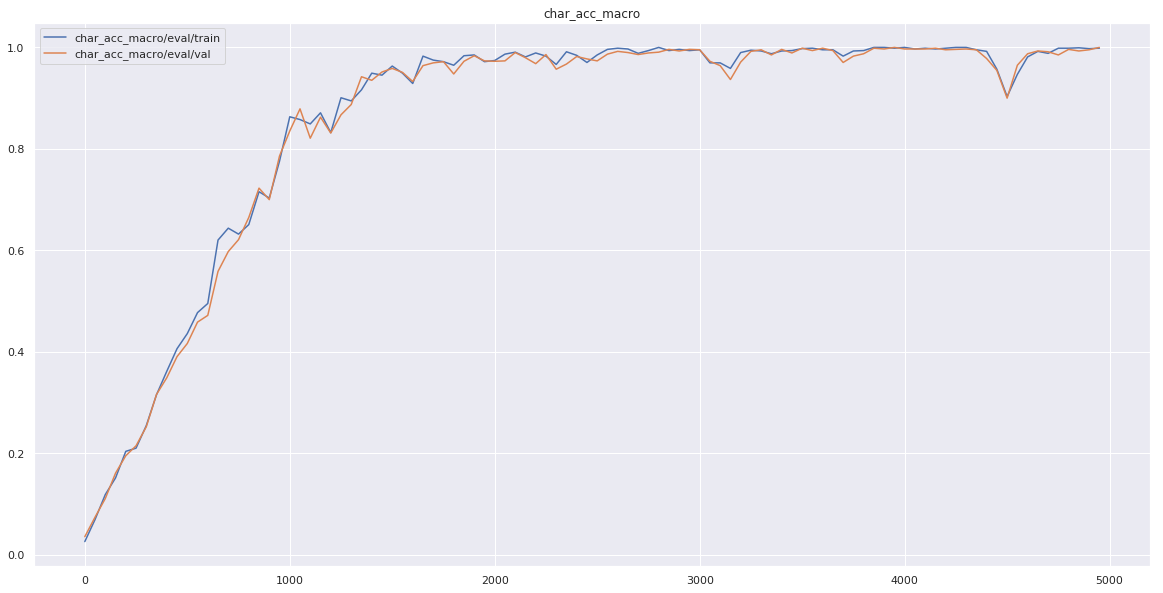

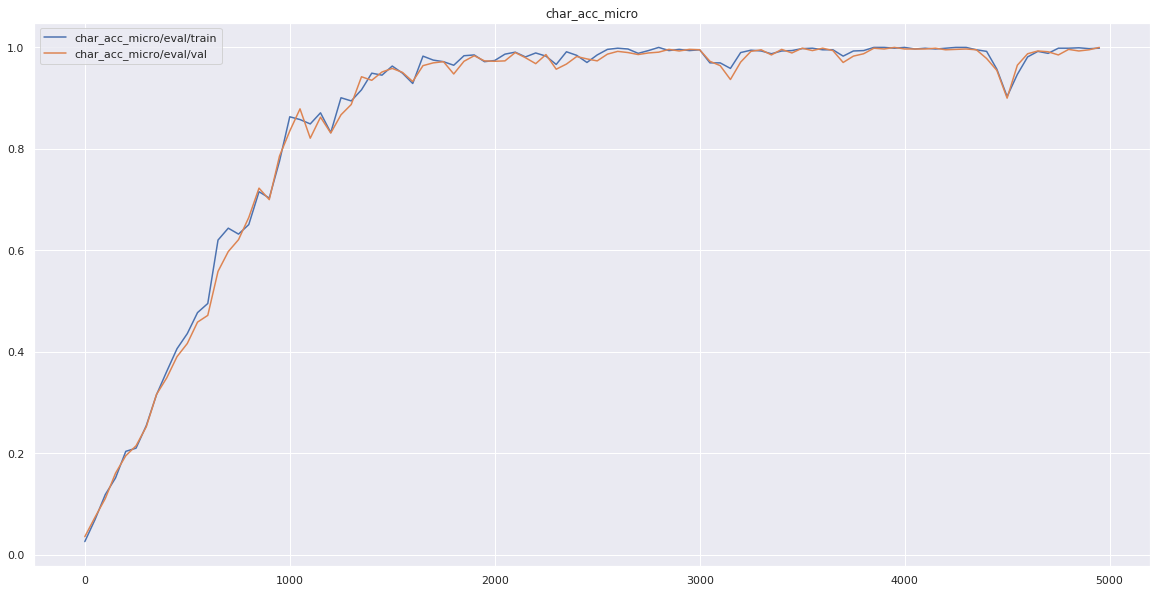

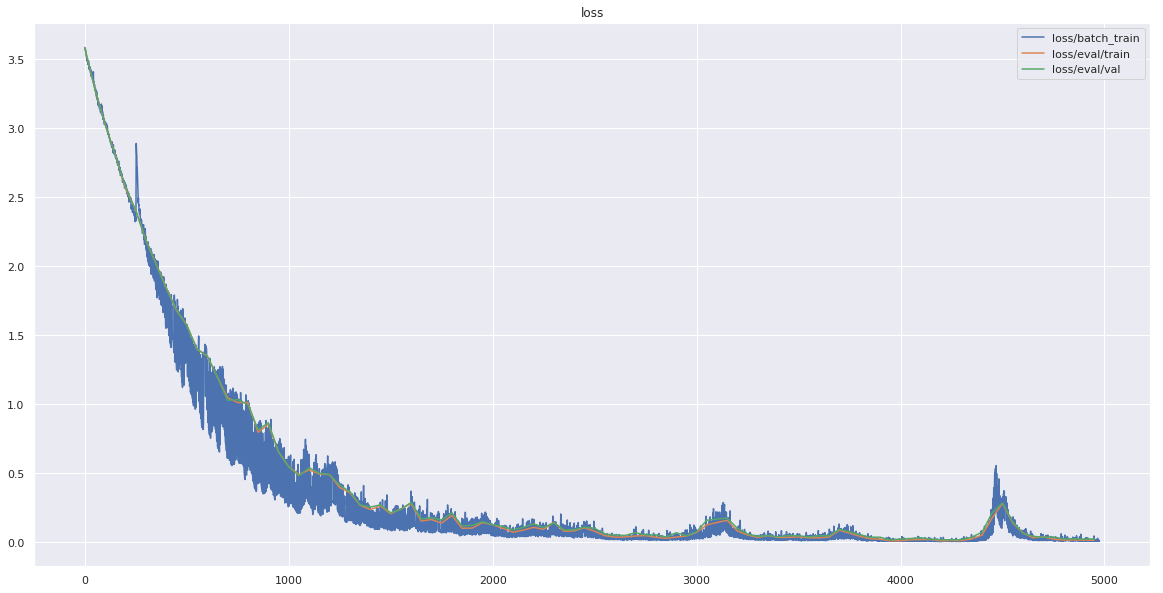

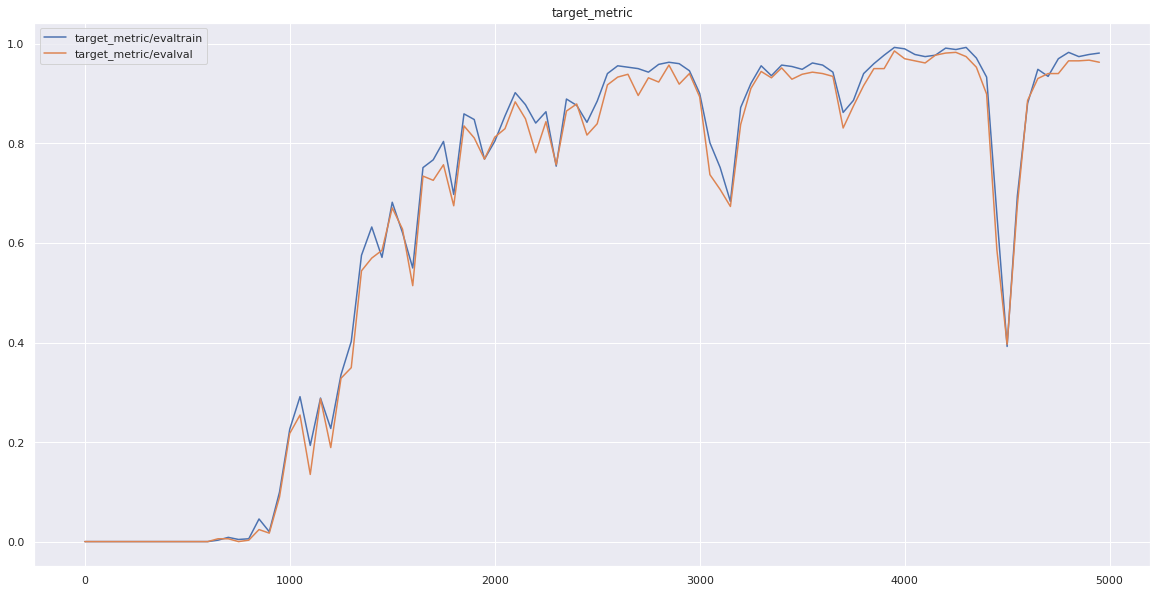

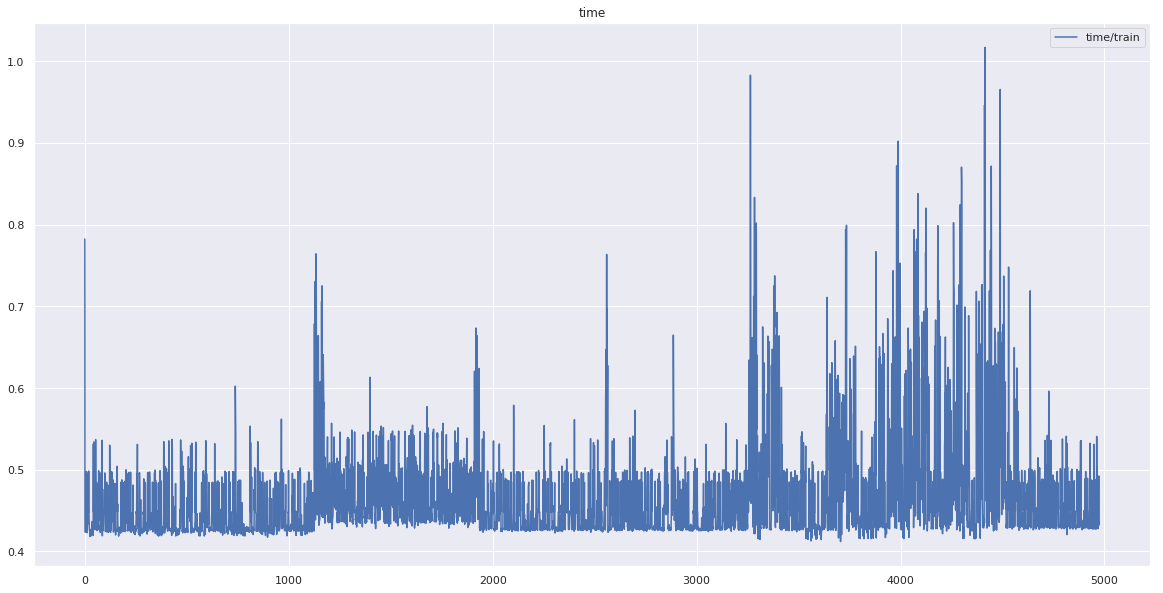

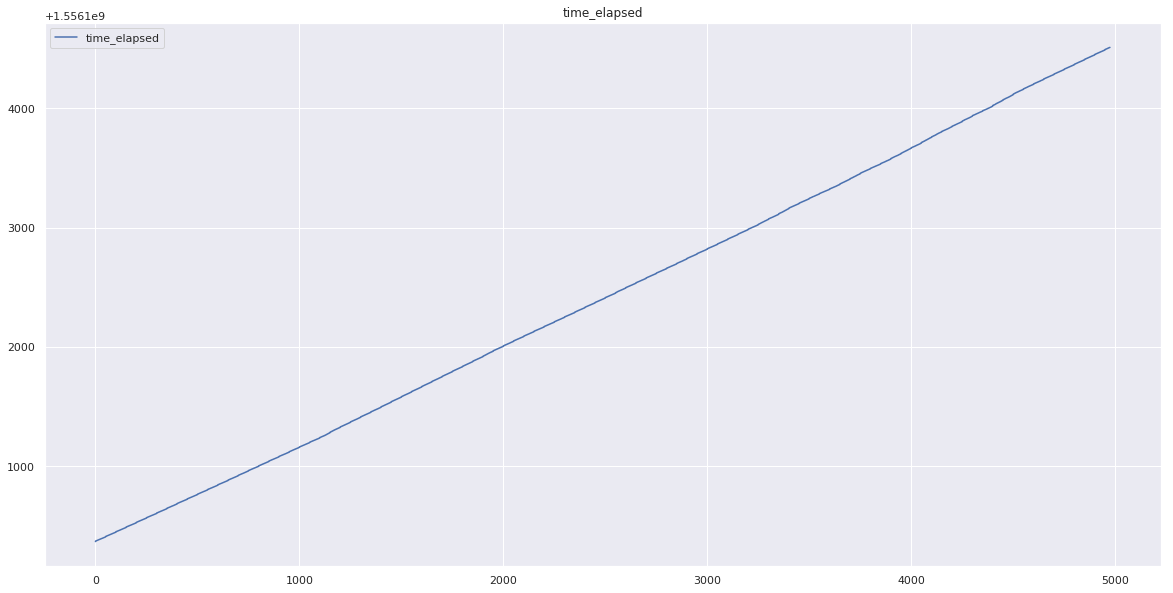

KeyboardInterrupt: 

In [0]:
trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.015597708867490291, 'target': 0.9795, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.012527581963614367, 'target': 0.984375, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.014819483890539348, 'target': 0.9805074257425742, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


### model 2
bidirectional model with lstm, added norm clipping 

the target metric converges more stably

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False, bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":30,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "b_callback_params":{
        "parameters": seq2seq_model.parameters(), 
        "max_norm": 1., 
        "norm_type": 2
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
backward_callback = nn.utils.clip_grad_norm_
trainer = Trainer(seq2seq_model, optimizer, backward_callback=backward_callback)

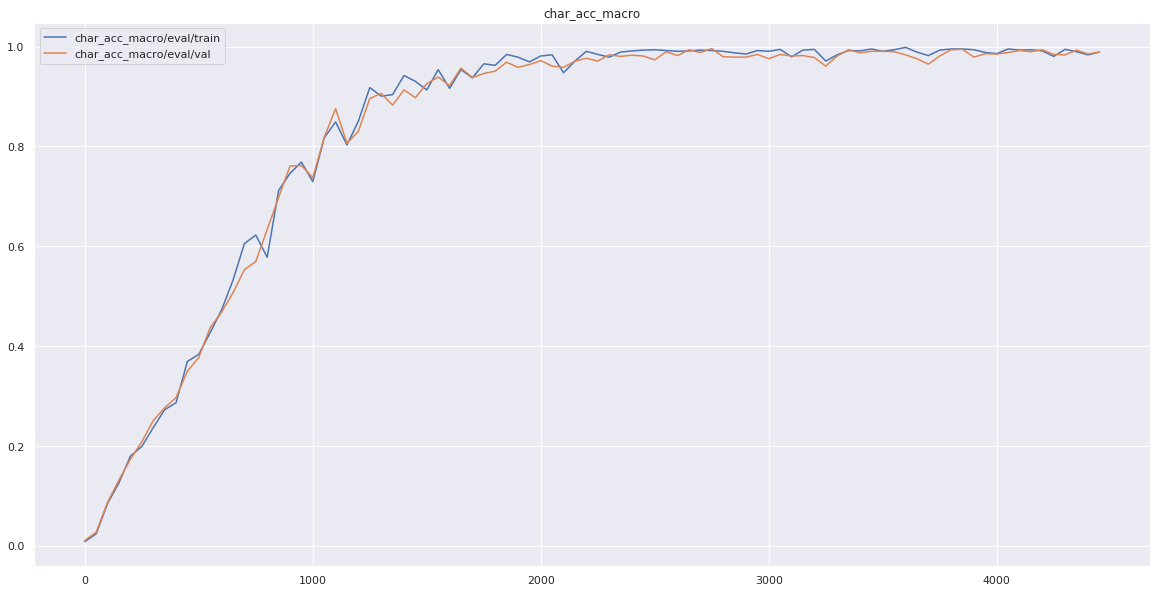

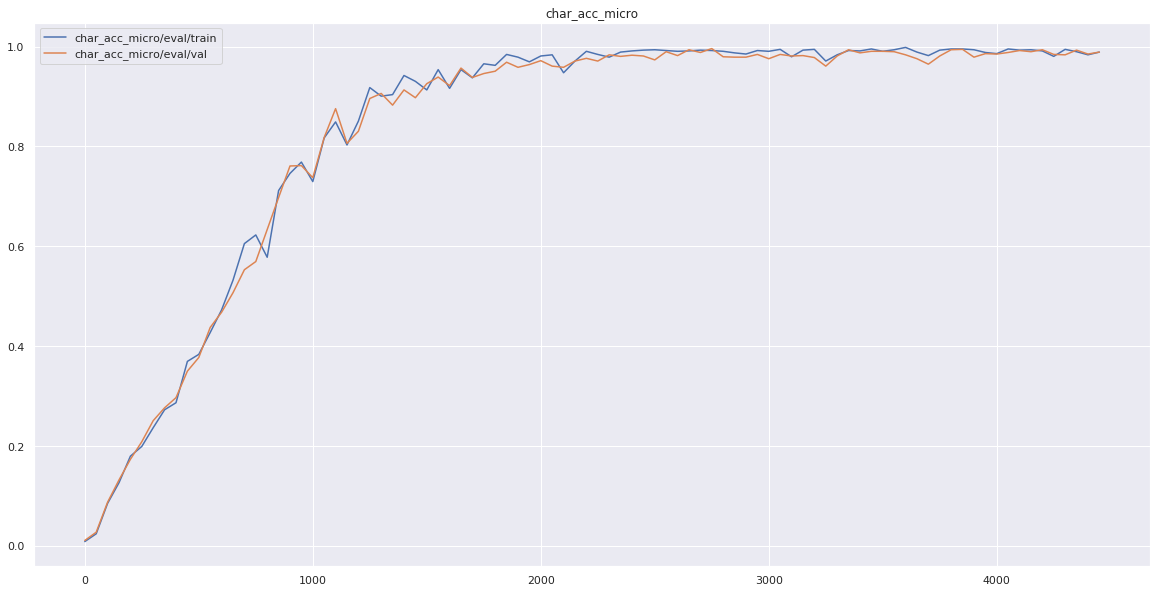

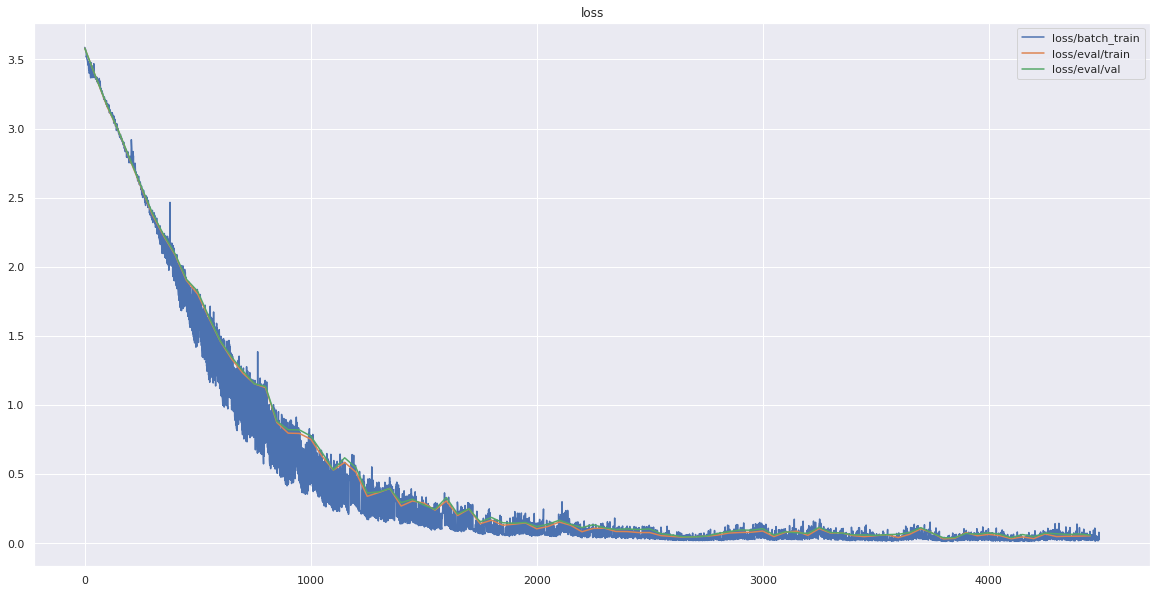

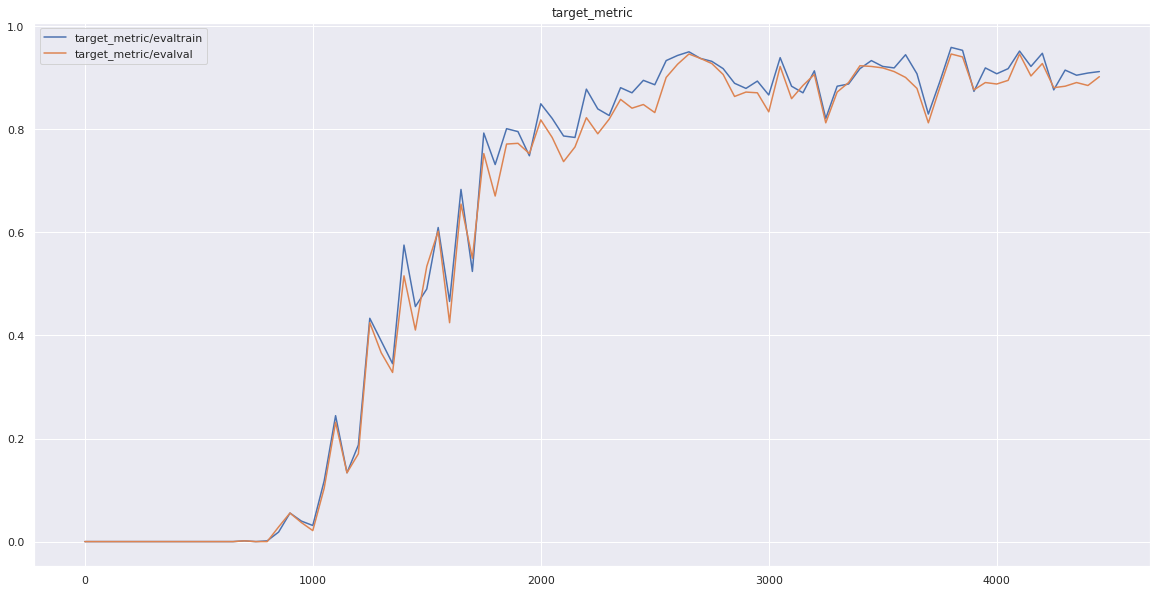

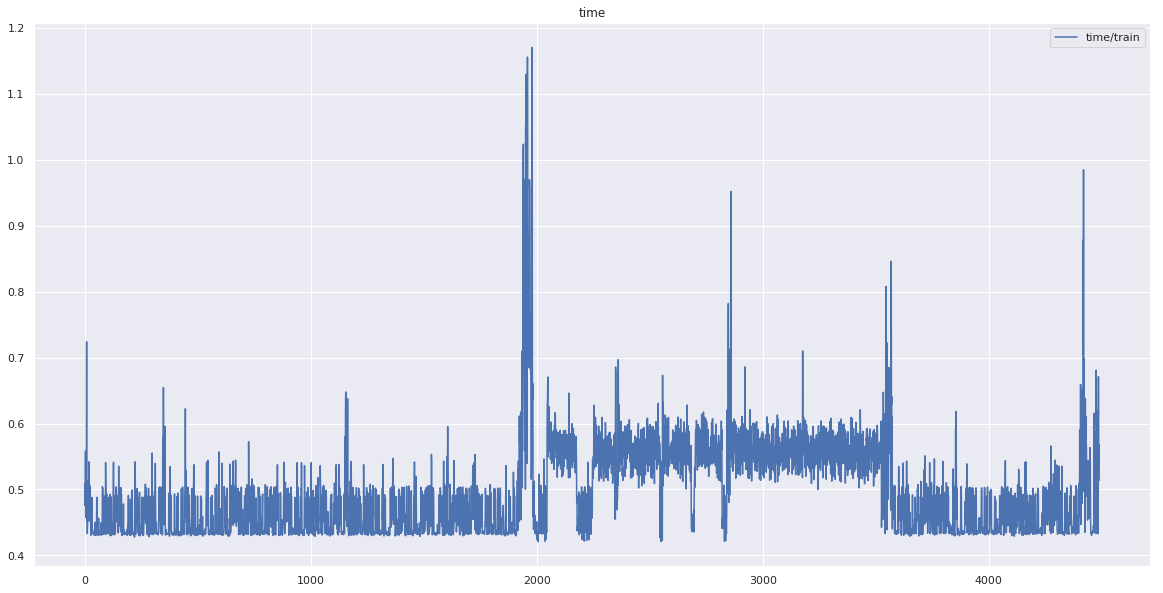

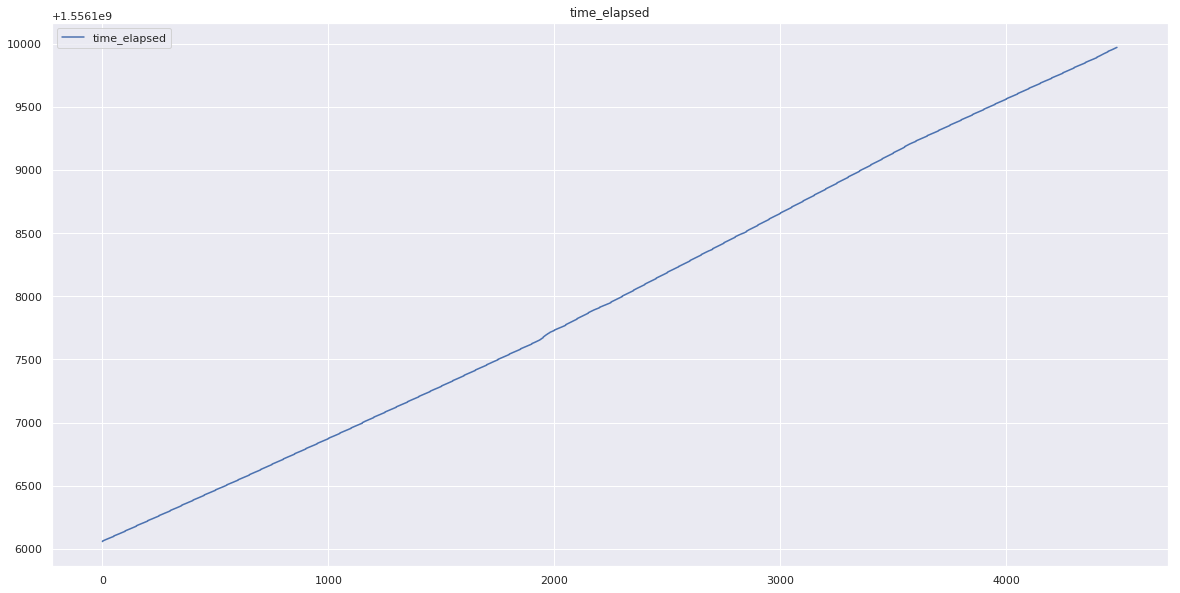

KeyboardInterrupt: 

In [0]:
trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.042721079558134076, 'target': 0.9309, 'char_acc_micro': 0.9875, 'char_acc_macro': 0.9875}
train: {'loss': 0.037310764995763204, 'target': 0.9407487623762376, 'char_acc_micro': 0.9953125, 'char_acc_macro': 0.9953125}
val: {'loss': 0.043085380927613465, 'target': 0.932549504950495, 'char_acc_micro': 0.99140625, 'char_acc_macro': 0.99140625}


### model 3
the same model with gru

the target metric convergency is very unstable again

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False, bidirectional=True, 
    cell_type='gru'
)

params = {
    "epochs":30,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "b_callback_params":{
        "parameters": seq2seq_model.parameters(), 
        "max_norm": 1., 
        "norm_type": 2
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
backward_callback = nn.utils.clip_grad_norm_
trainer = Trainer(seq2seq_model, optimizer, backward_callback=backward_callback)

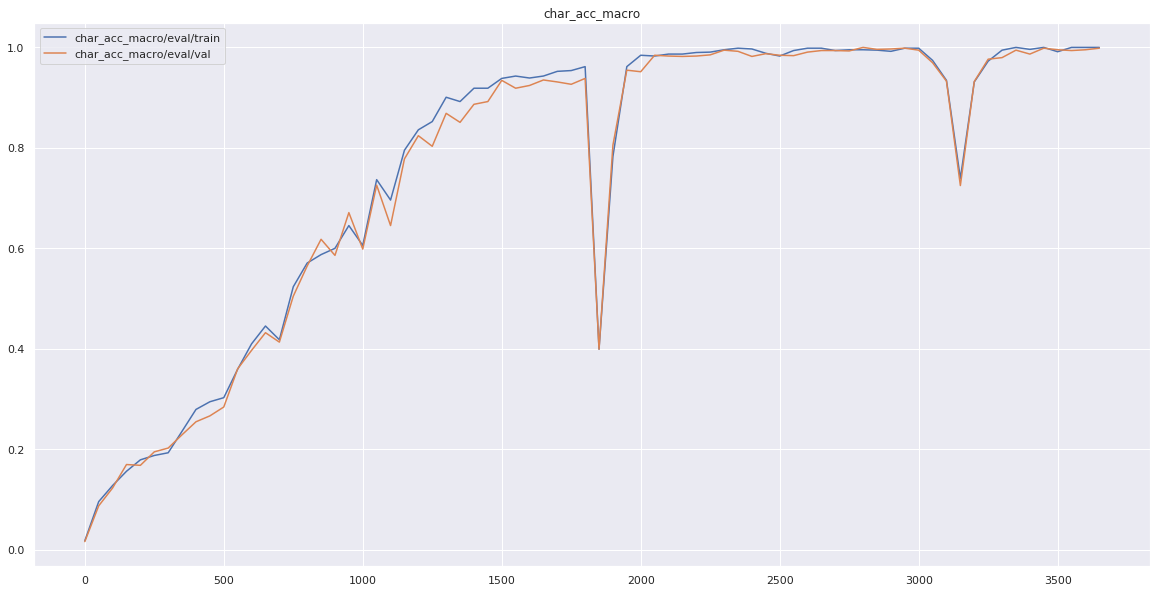

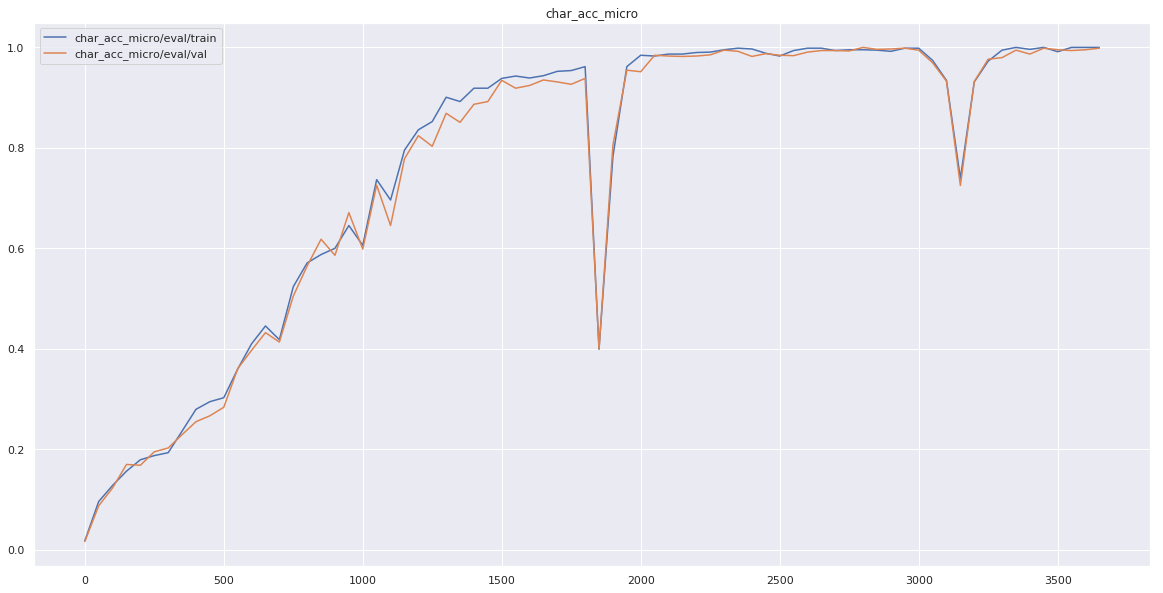

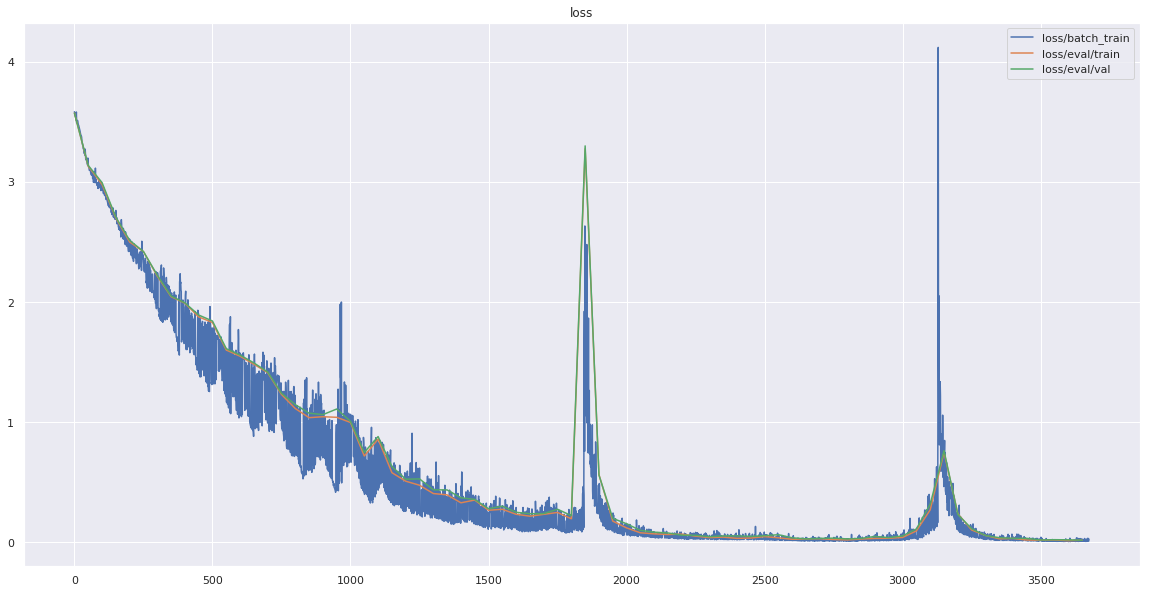

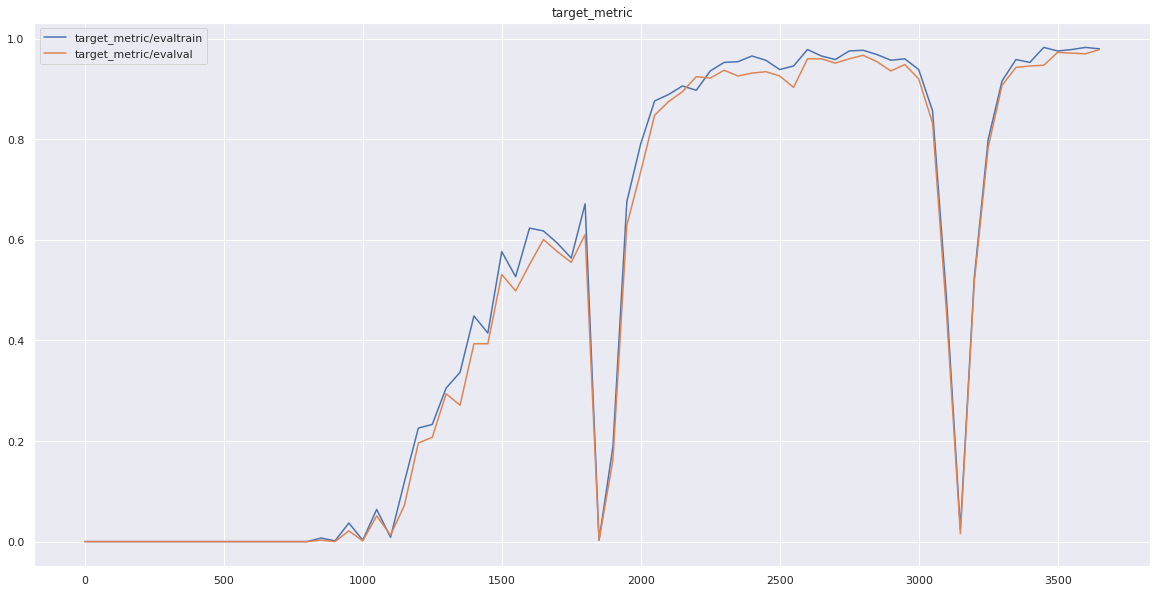

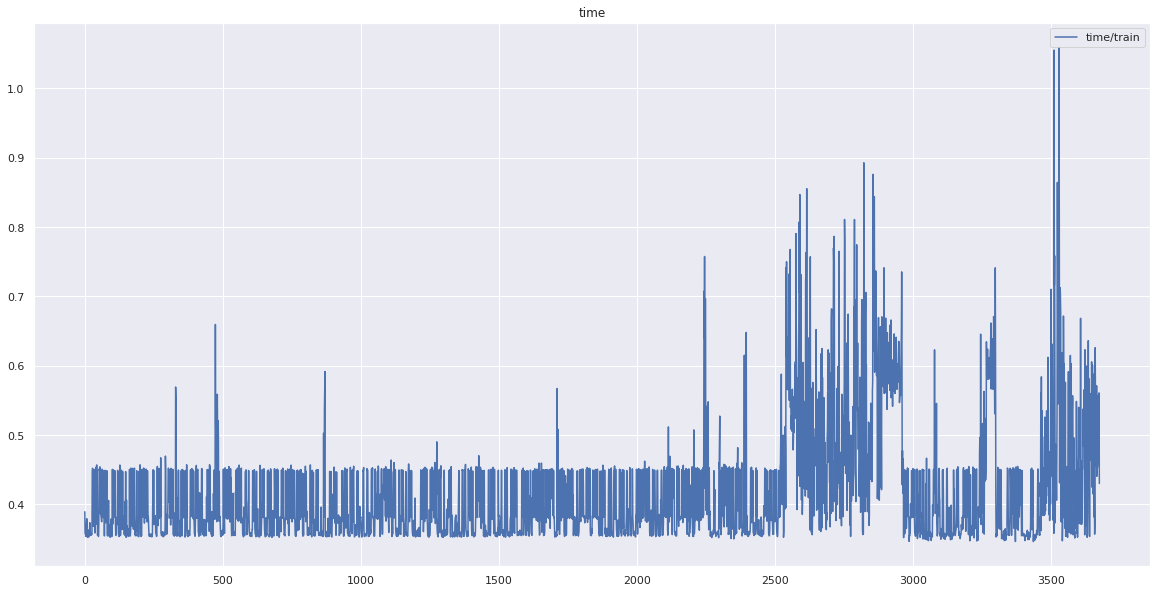

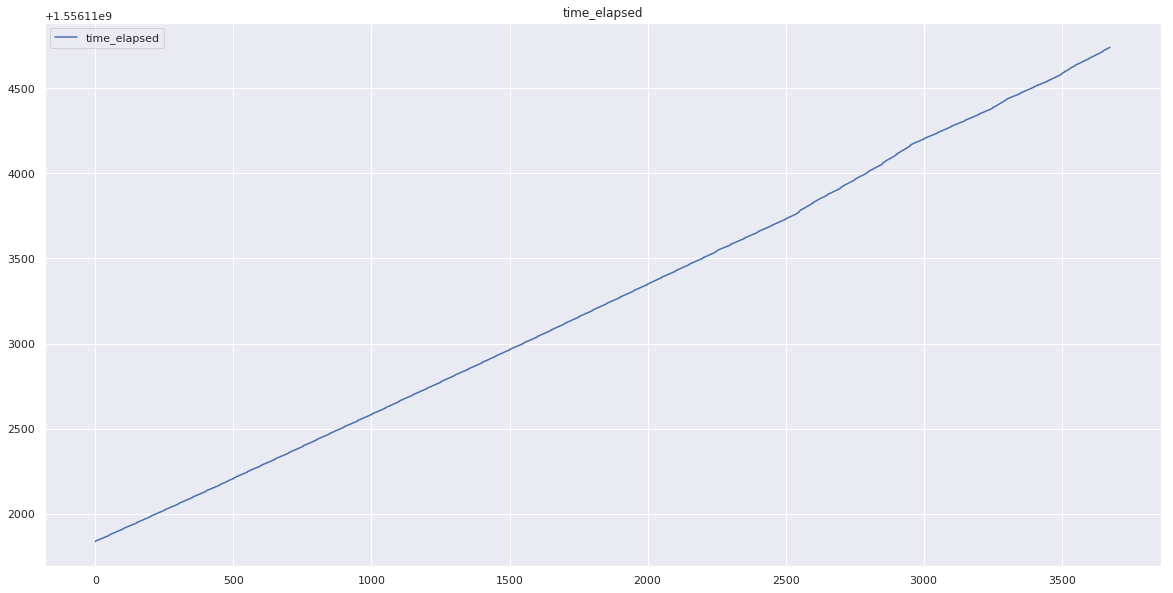

KeyboardInterrupt: 

In [0]:
trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.017445875844359398, 'target': 0.9793, 'char_acc_micro': 0.99375, 'char_acc_macro': 0.99375}
train: {'loss': 0.013816803564677144, 'target': 0.9856126237623762, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.018760859436069678, 'target': 0.9767945544554455, 'char_acc_micro': 0.9984375, 'char_acc_macro': 0.9984375}


### model 4
not training a model actially, but counting mean l2 norm of model parameters gradient without clipping

the result is 1.26 => taking 1. as clip_grad_norm_() argument was a good decision

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False, bidirectional=True, 
    cell_type='gru'
)

params = {
    "epochs":1,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

1.2625106177494425


### model 5

the same model with learning rate sheduler

works better for this model than gradient clipping, the convergency is more stable and fast, no large drops

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False, bidirectional=True, 
    cell_type='gru'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
lr_sheduler = StepLR(optimizer, step_size=1000, gamma=0.5)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=lr_sheduler)

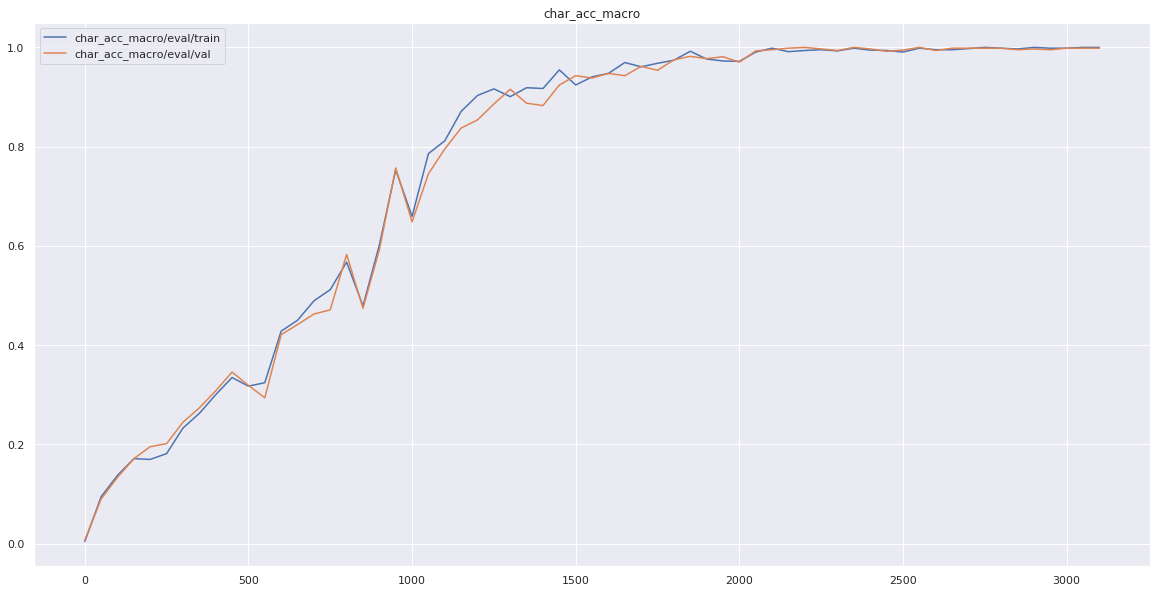

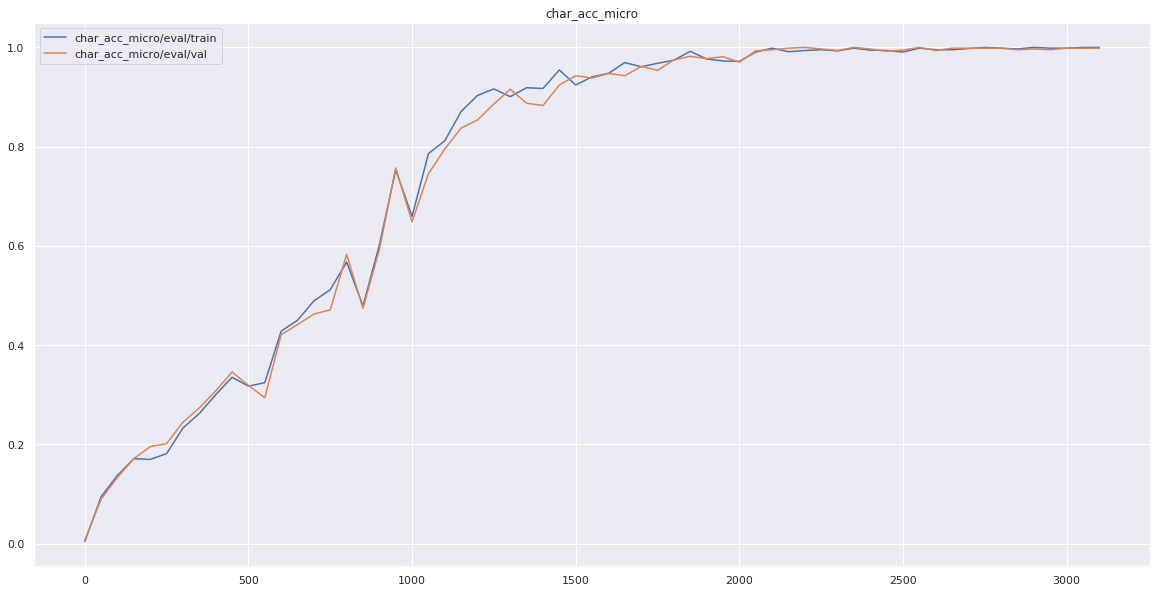

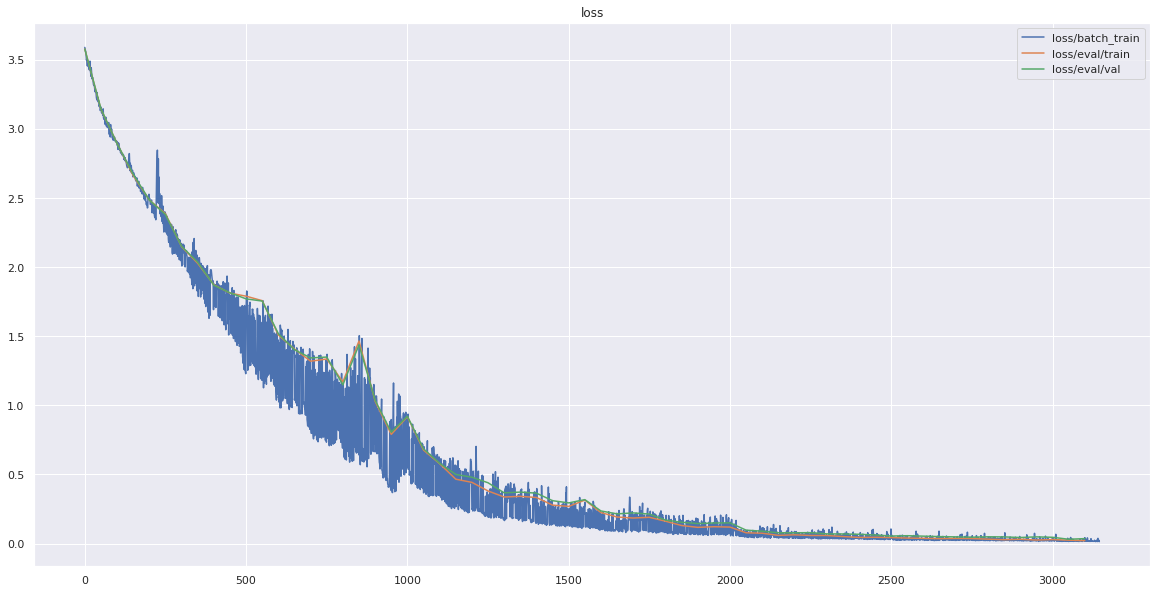

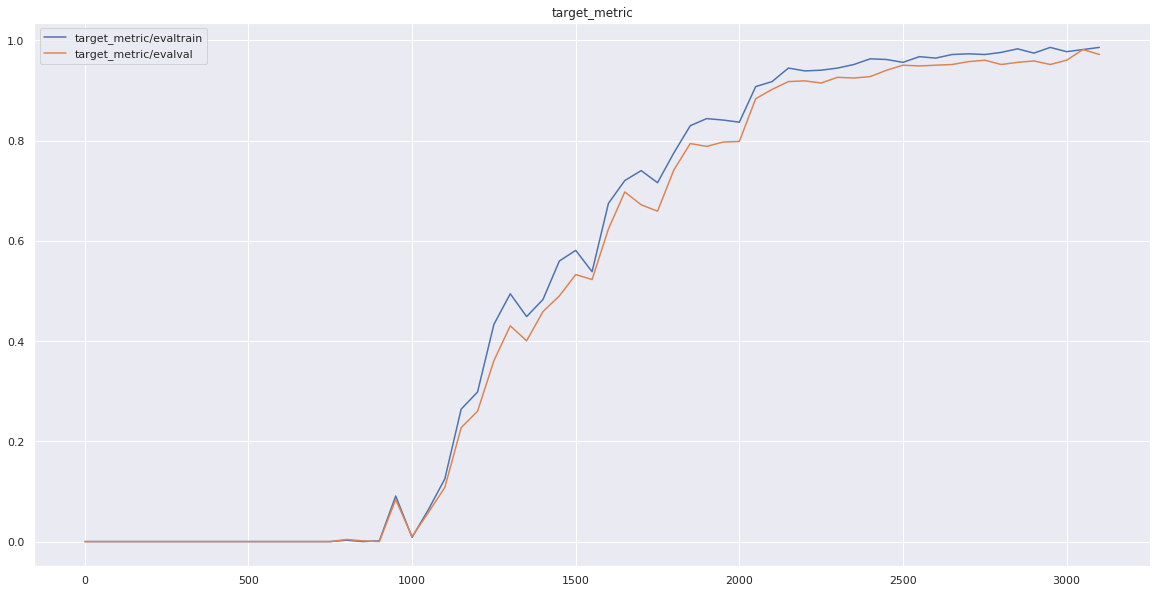

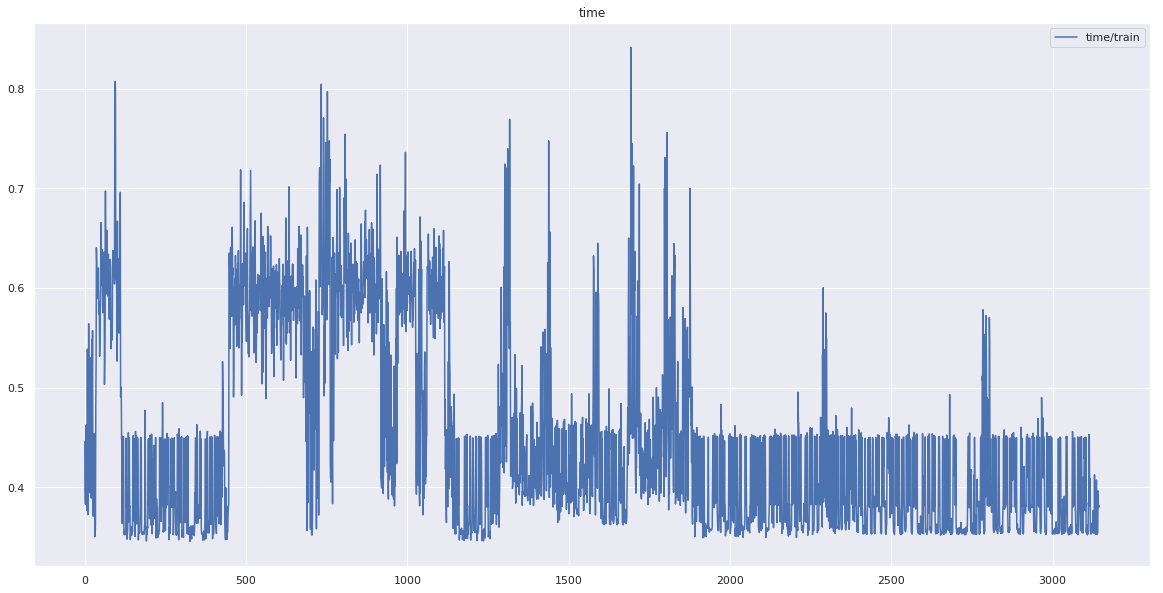

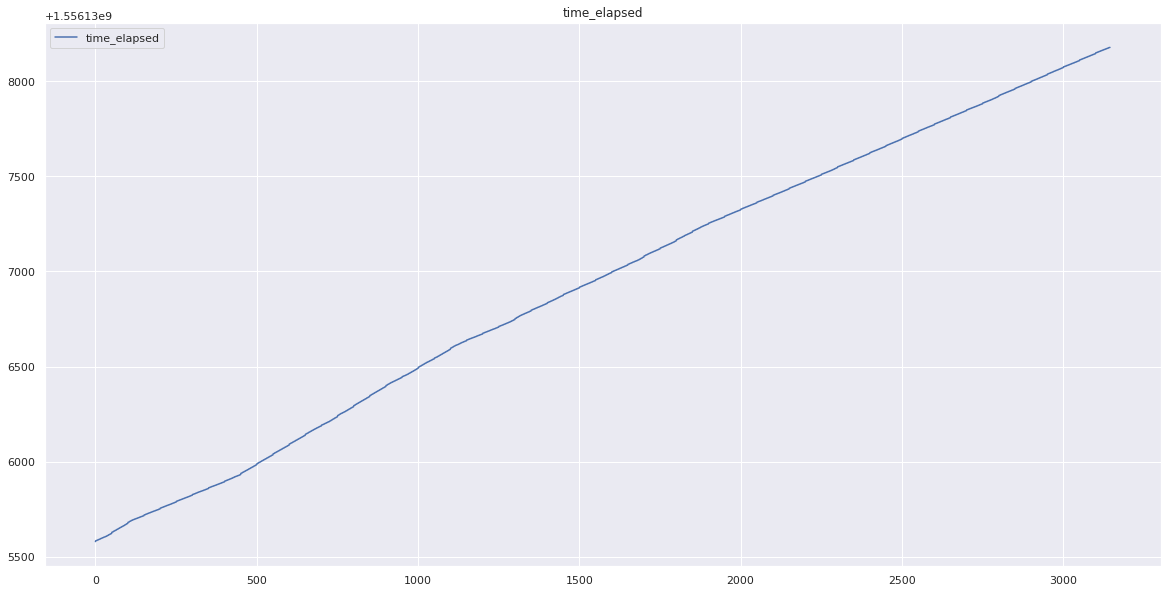

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.030484994247555734, 'target': 0.9752, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.021503544080596747, 'target': 0.9876237623762376, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.030762498091795657, 'target': 0.9746287128712872, 'char_acc_micro': 0.9953125, 'char_acc_macro': 0.9953125}


### model 6

encoder is not bidirectional

very slow and unstable, accuracy rather low even in the highest points

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_encoder=False,
    attention_after_encoder=False,
    bidirectional=False, 
    cell_type='lstm'
)

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

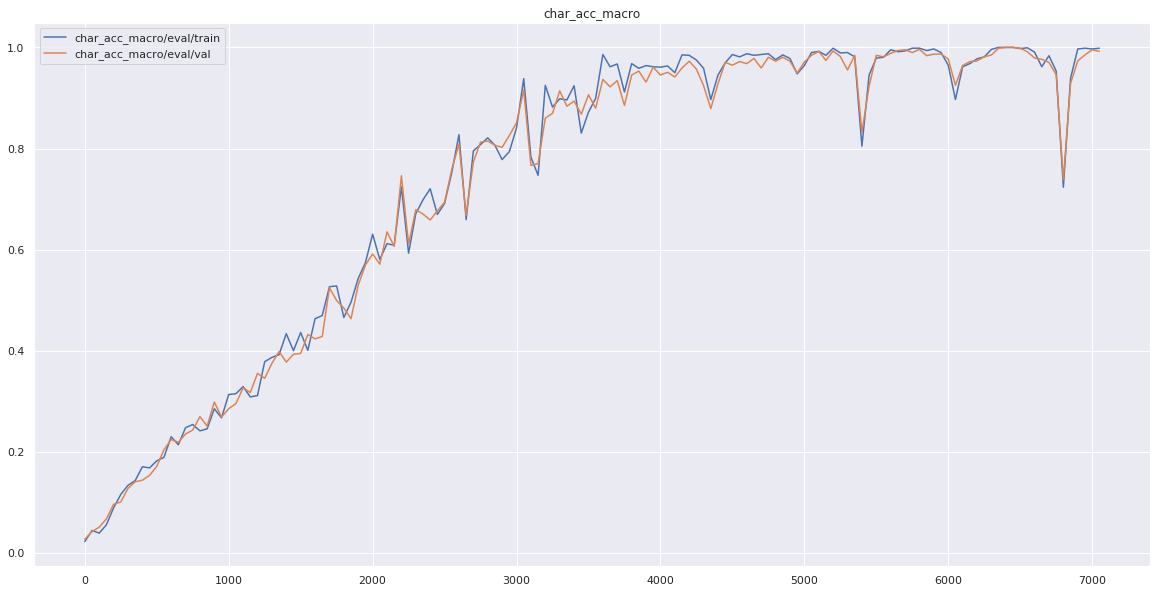

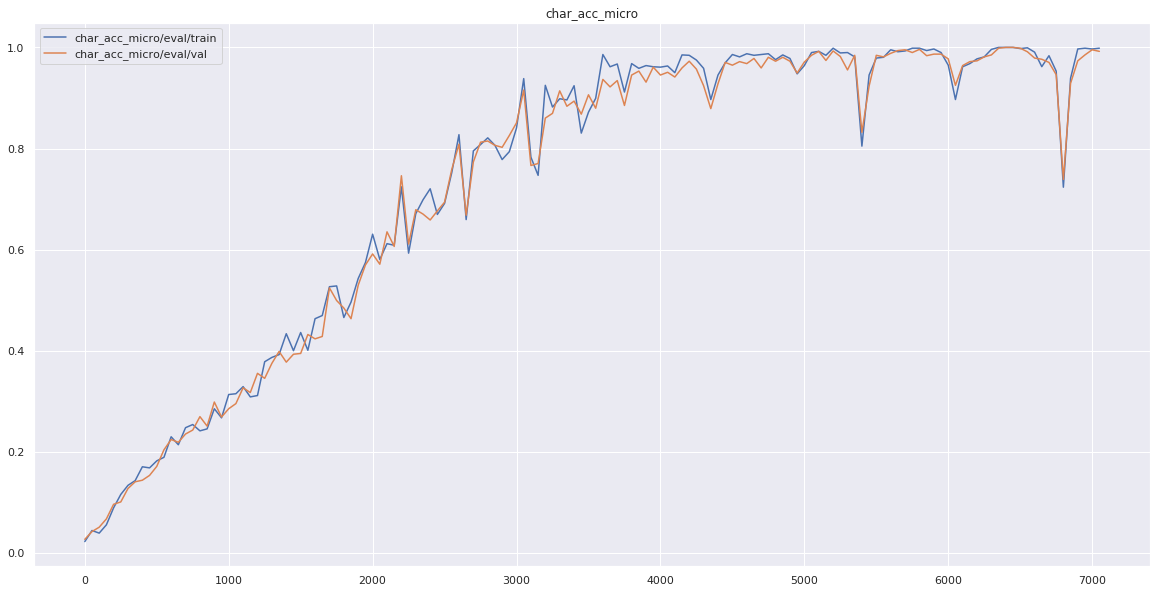

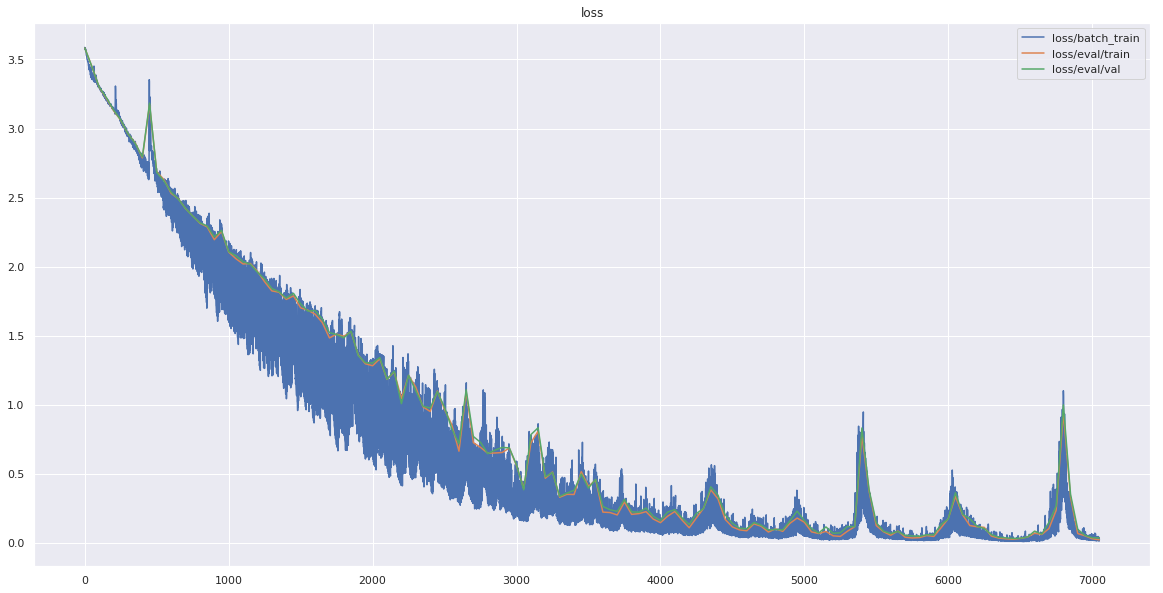

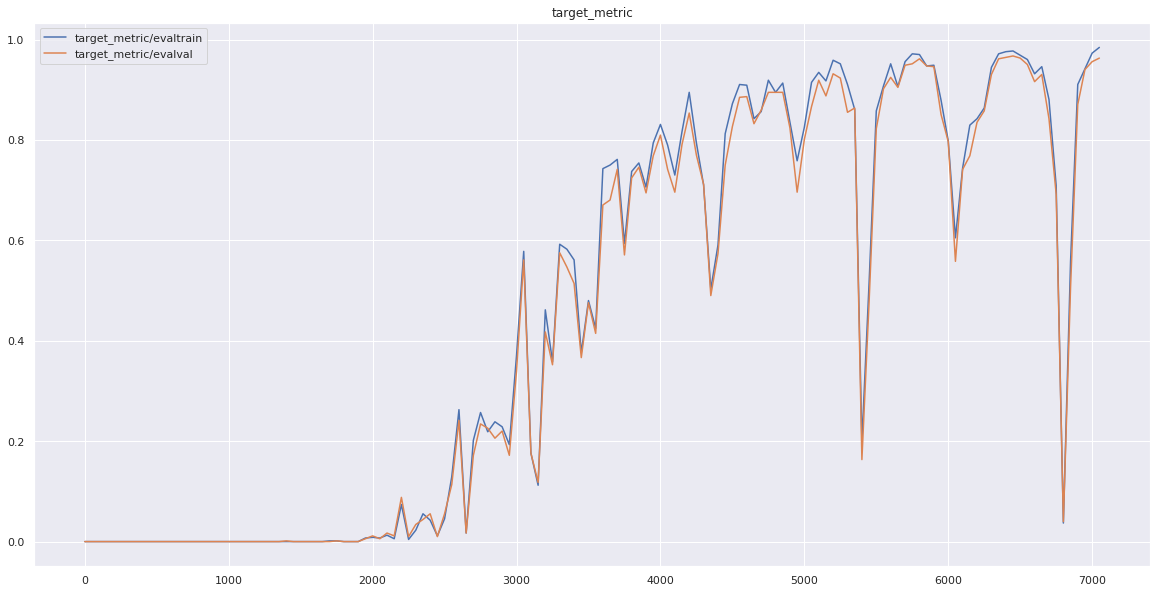

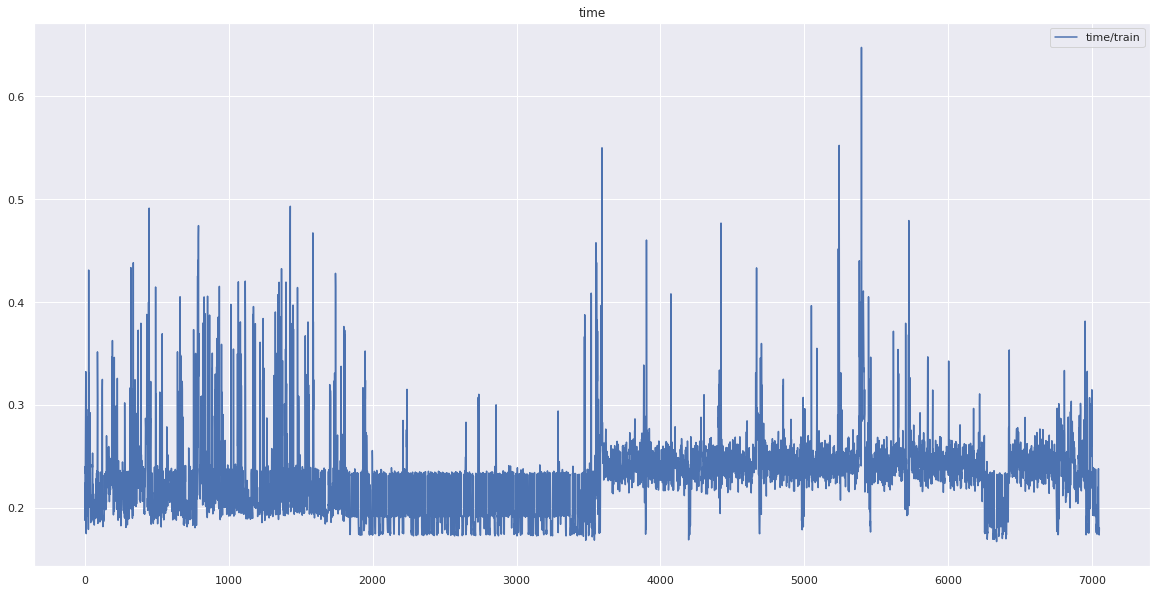

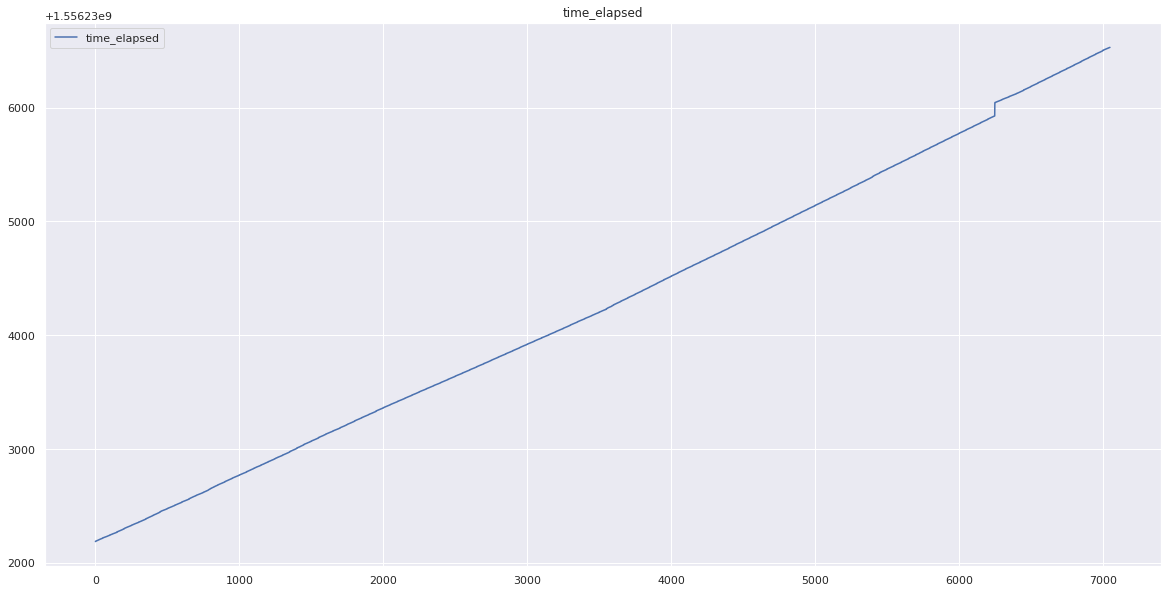

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

цйщюзврмьжирихнфцссз || зссцфнхирижьмрвзющйц || зссцфнхирижьмрвзющйц
нюсзсяфвцфшусэжхръпй || йпърхжэсушфцвфясзсюн || йпърхжэсушфцвфясзсюн
ыпуйпьшъжлщйаъфгоаоц || цоаогфъайщлжъшьпйупы || цоаогфъайщлжъшьпйупы
чузшышцхтчрлмввтачюм || мючатввмлрчтхцшышзуч || мючатввмлрчтхцшышзуч
увпдбеюйеюоумщчефчиэ || эичфечщмуоюейюебдпву || эичфечщмуоюейюебдпву


In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.03306568170785904, 'target': 0.9682, 'char_acc_micro': 0.99375, 'char_acc_macro': 0.99375}
train: {'loss': 0.026987793514191515, 'target': 0.9758663366336634, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.032556787004122636, 'target': 0.9679764851485149, 'char_acc_micro': 0.996875, 'char_acc_macro': 0.996875}


### model 7

using sgd with momentum as optimizer

works very bad, the loss stops decreasing

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    bidirectional=True, 
    attention_before_decoder=False,
    attention_after_decoder=False,
    cell_type='lstm'
)

params = {
    "epochs":30,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.SGD(seq2seq_model.parameters(), lr=1.0, momentum=0.9)
trainer = Trainer(seq2seq_model, optimizer)

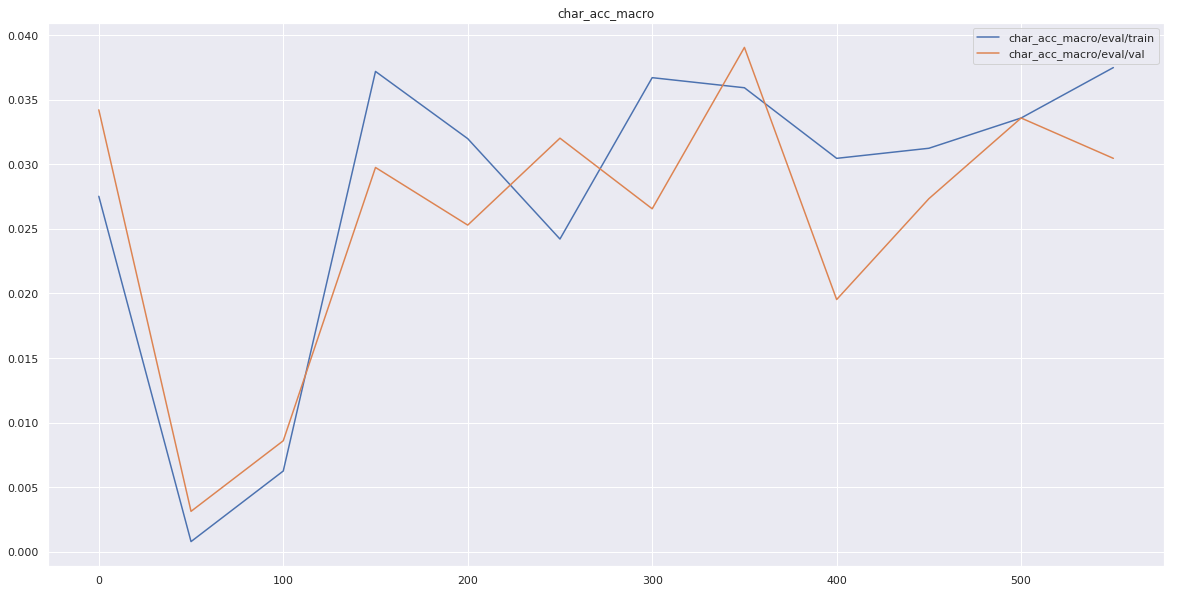

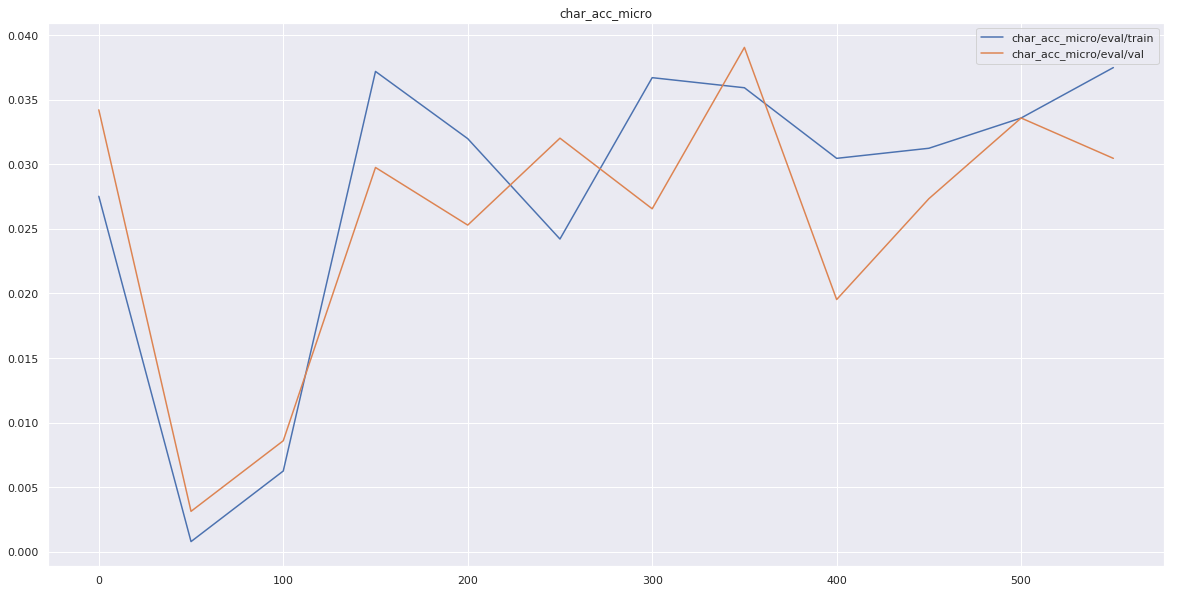

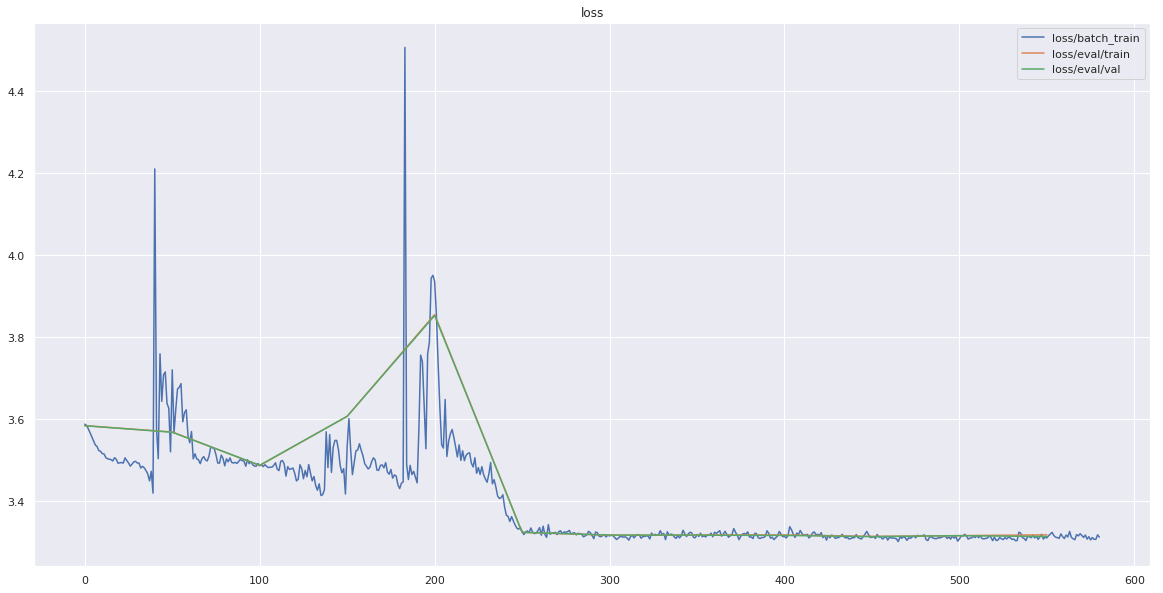

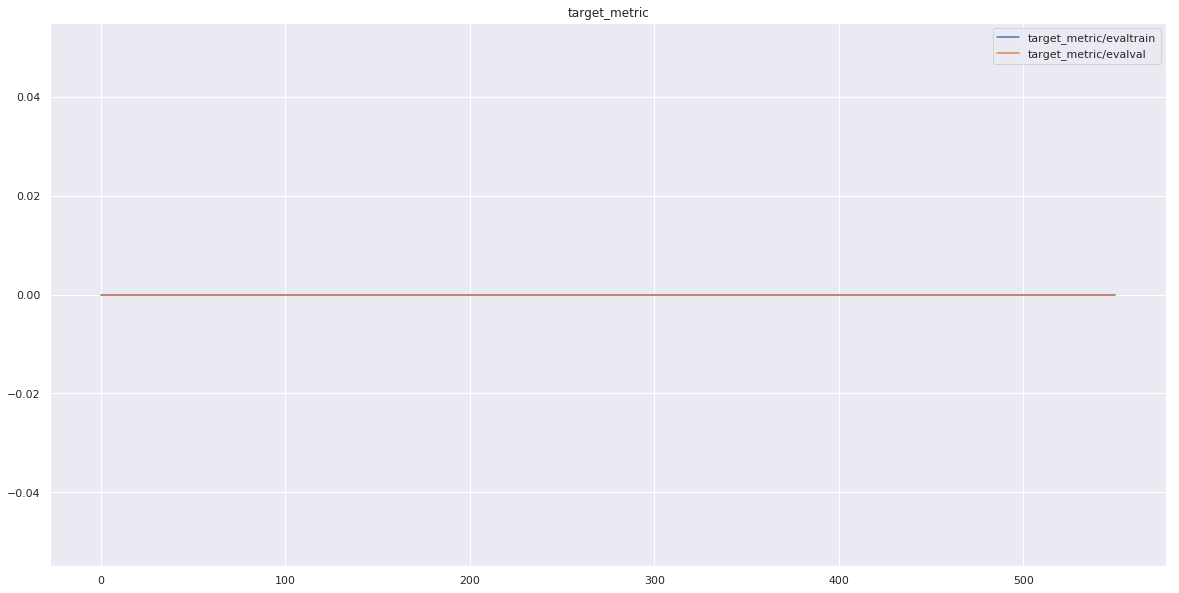

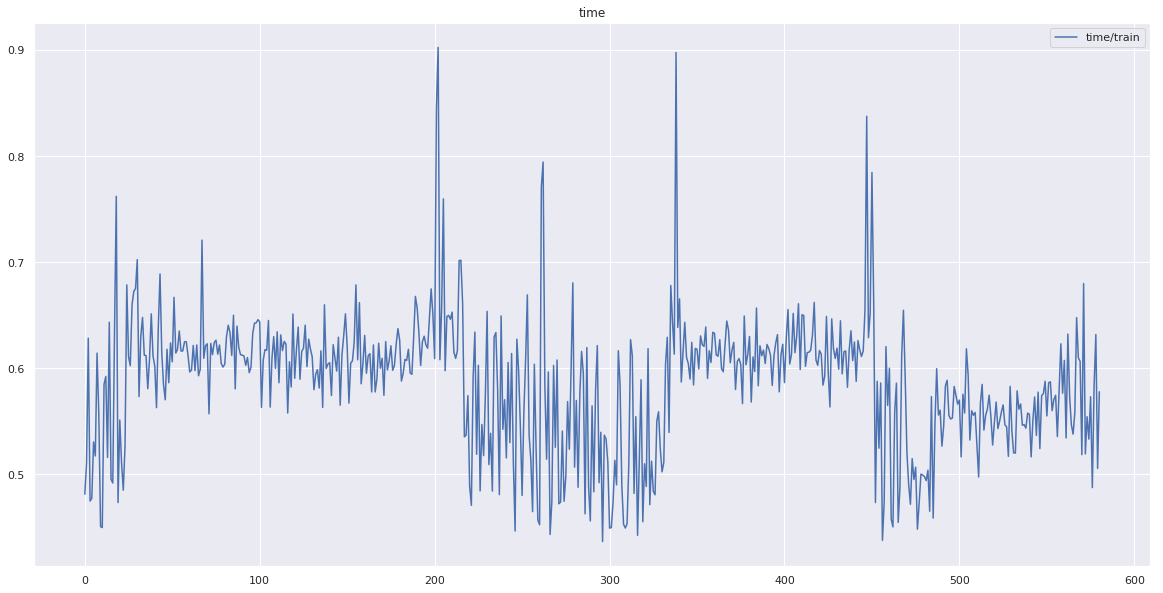

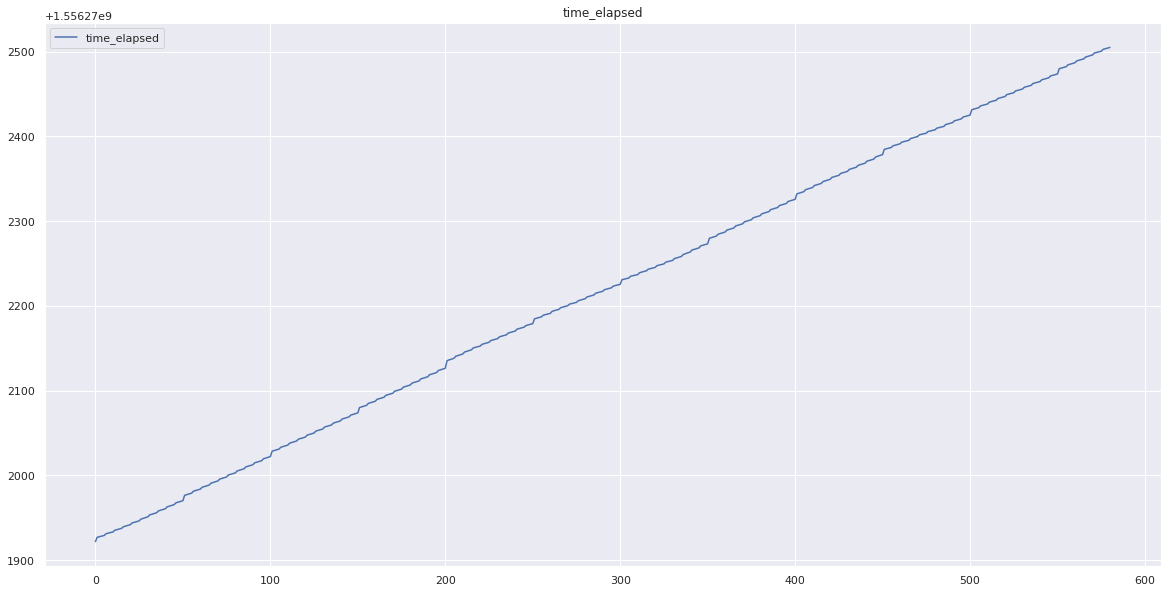

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

### model 8

using gpu instead of cpu on model 1

works much faster (each iteration takes abous 0.05 sec instead of 0.5 sec, which is almoыt 10 times faster)

it also came out that showing plots takes much time. after 1500 iterations the parameter 'show_every' was changed from 5 to 100, and this point is seen at the plot 'time elapsed'

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_encoder=False,
    attention_after_encoder=False,
    bidirectional=True, 
    cell_type='lstm'
).cuda()

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

In [0]:
params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":100
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

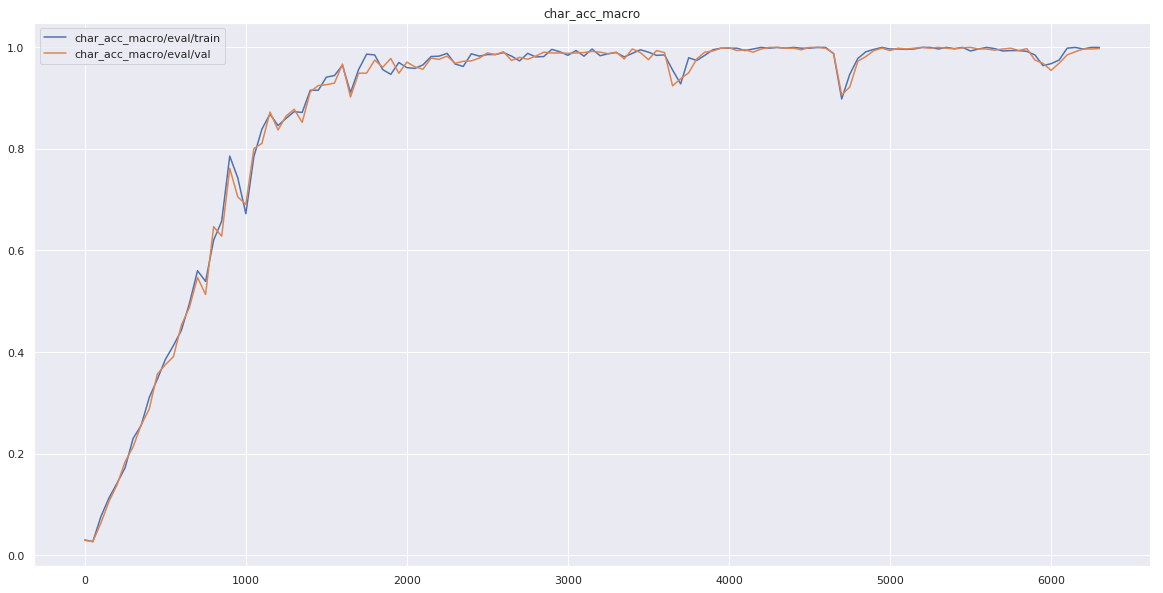

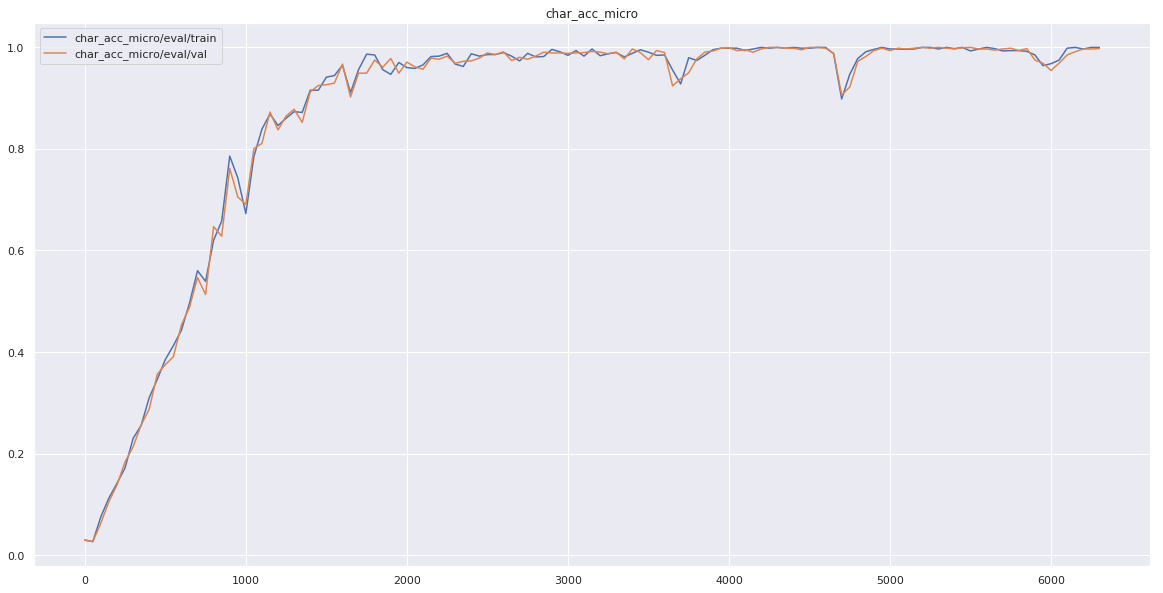

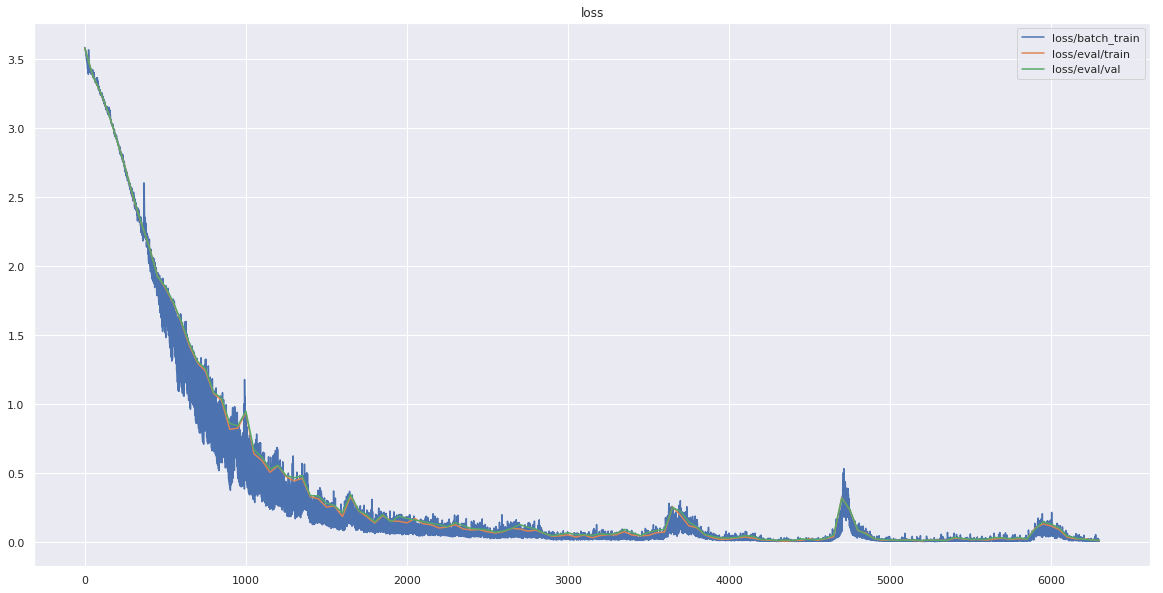

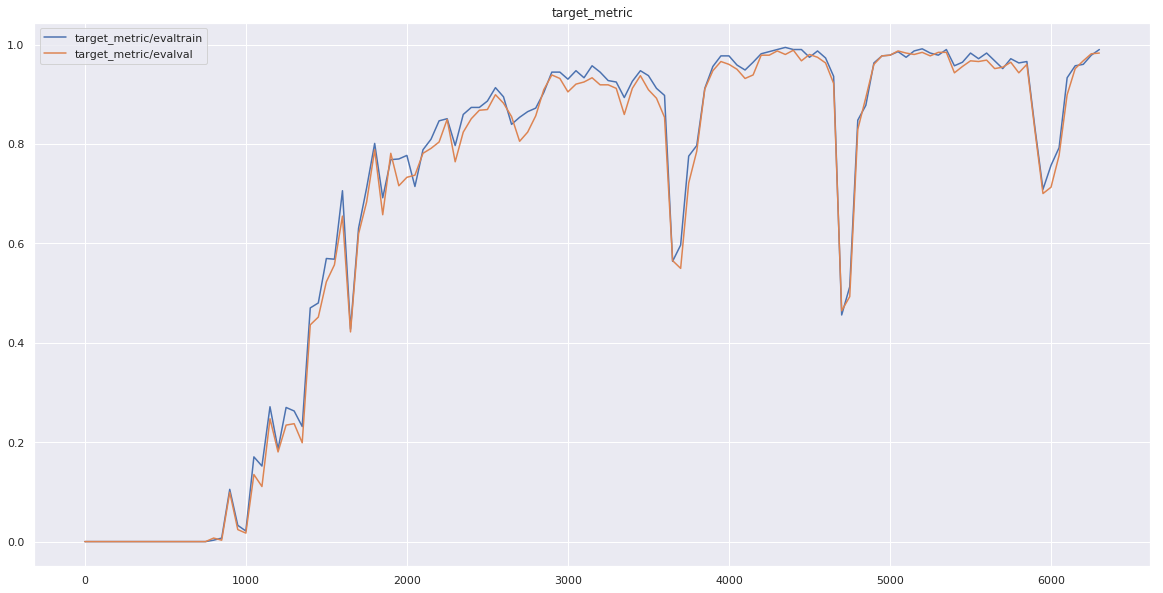

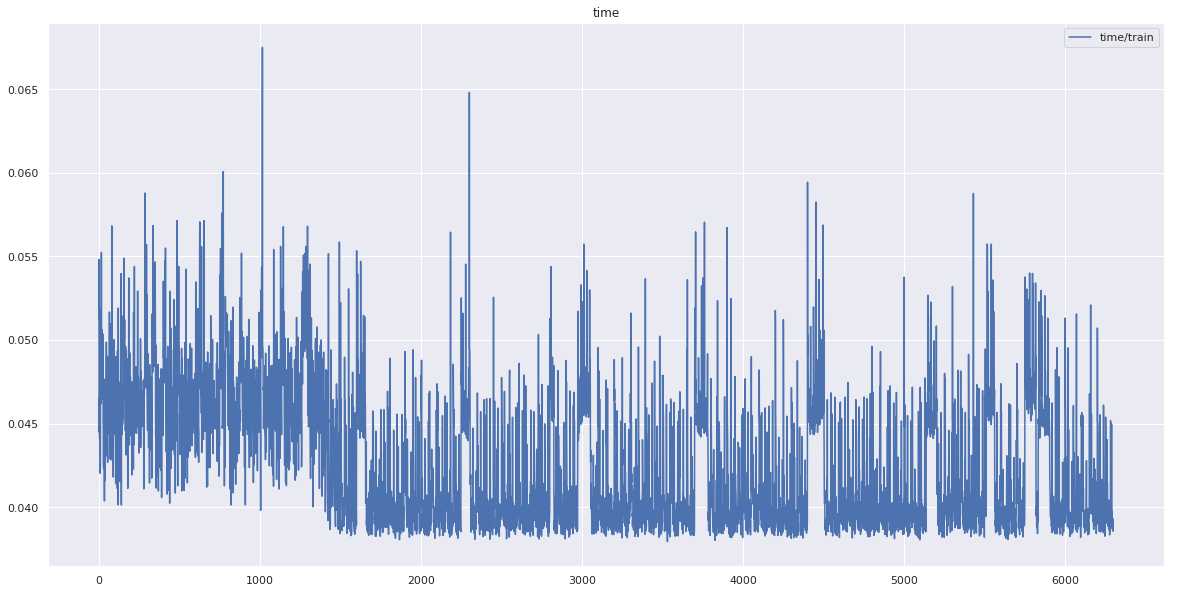

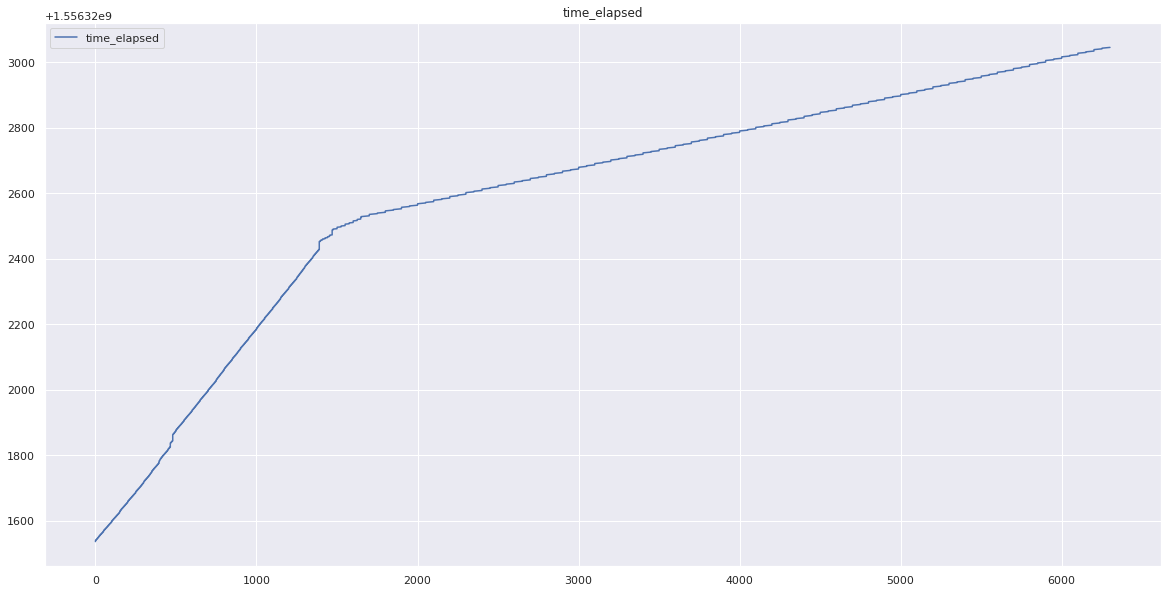

In [167]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [170]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

жрмзкципцичэаюяъкьнв || внькъяюаэчицпицкзмрж || внькъяюаэчицпицкзмрж
выеъжэаблбйдсеияеоав || ваоеяиесдйблбаэжъеыв || ваоеяиесдйблбаэжъеыв
мэккиакяяоггжсгцййтх || хтййцгсжггояякаиккэм || хтййцгсжггояякаиккэм
юовхгюобфшчяфюсмоицз || зциомсюфячшфбоюгхвою || зциомсюфячшфбоюгхвою
глэвркщхюанюбьфйчйфм || мфйчйфьбюнаюхщкрвэлг || мфйчйфьбюнаюхщкрвэлг


In [171]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.022822934079170226, 'target': 0.9632, 'char_acc_micro': 0.99375, 'char_acc_macro': 0.99375}
train: {'loss': 0.019451827811316984, 'target': 0.968440594059406, 'char_acc_micro': 0.9953125, 'char_acc_macro': 0.9953125}
val: {'loss': 0.02344727562740445, 'target': 0.9602413366336634, 'char_acc_micro': 0.9976562499999999, 'char_acc_macro': 0.99765625}


### model 9

the same model 1 on gpu,  max_len of sequence is 10 (2 times shorter)

time for training iteration approximately linearly depends on length of sequence, its average value 0.25 sec (according to the plot)

the target metric converges 2 or 3 times faster, the convergency is very stable


In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=10,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_encoder=False,
    attention_after_encoder=False,
    bidirectional=True, 
    cell_type='lstm'
).cuda()

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":50
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

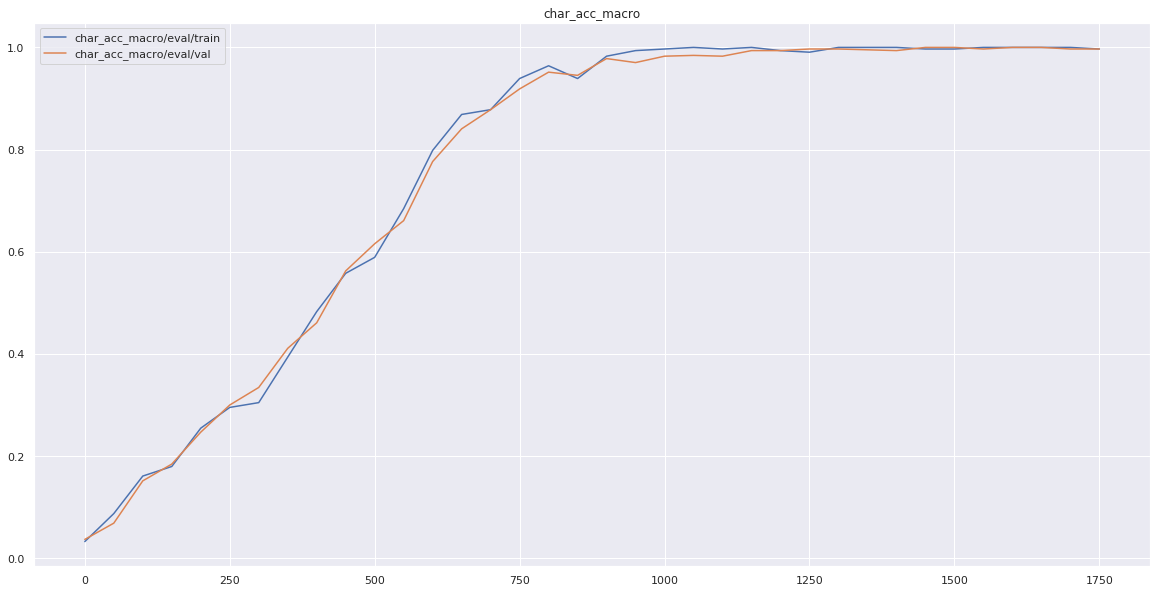

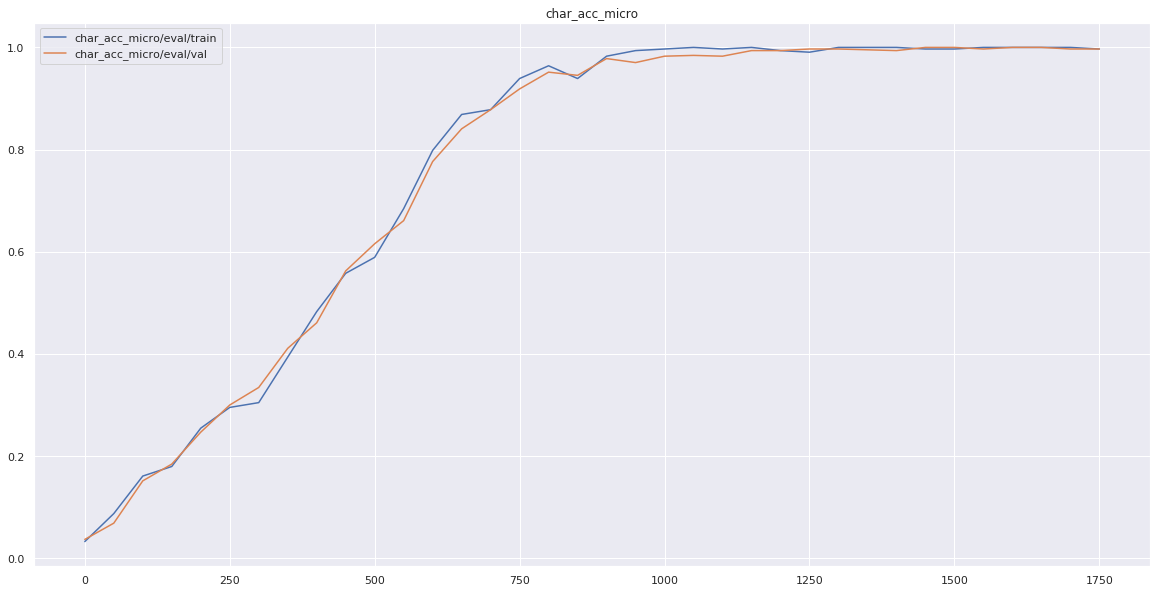

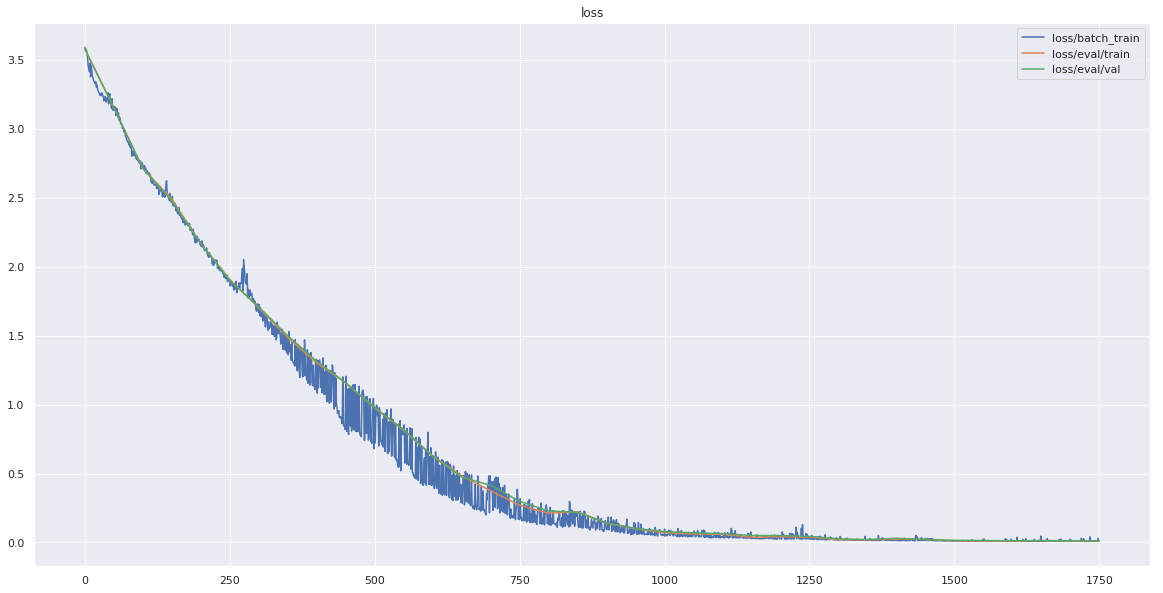

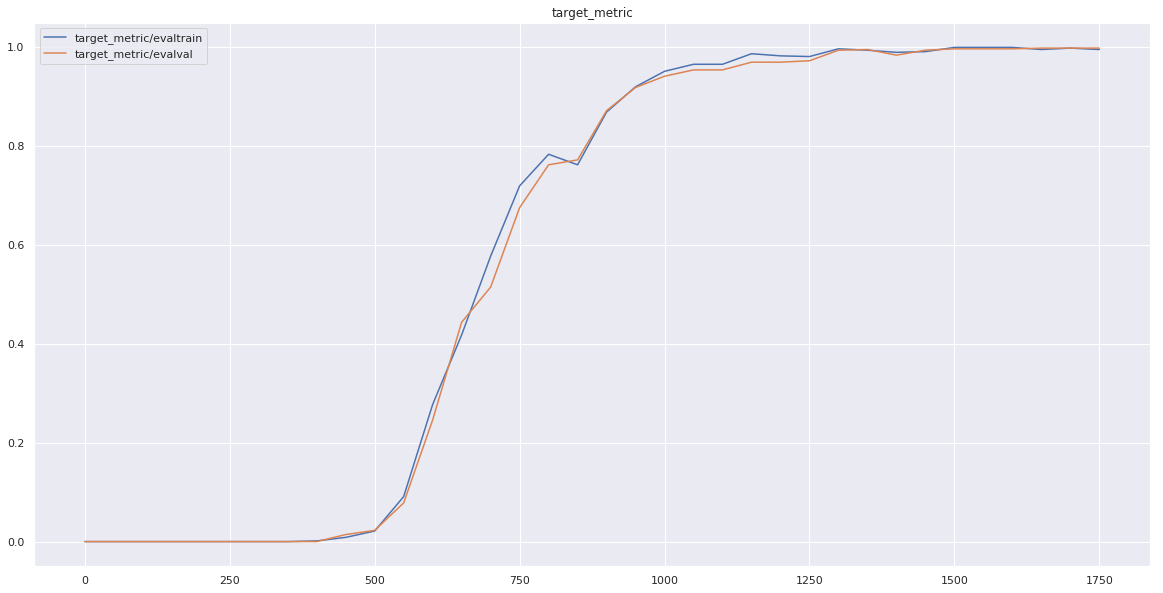

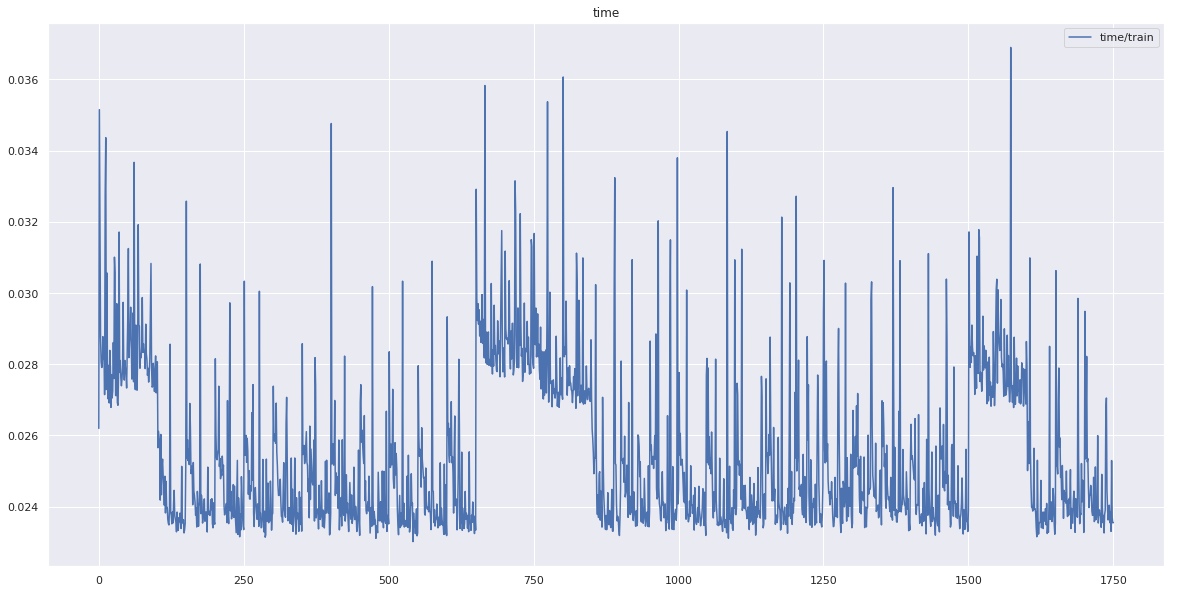

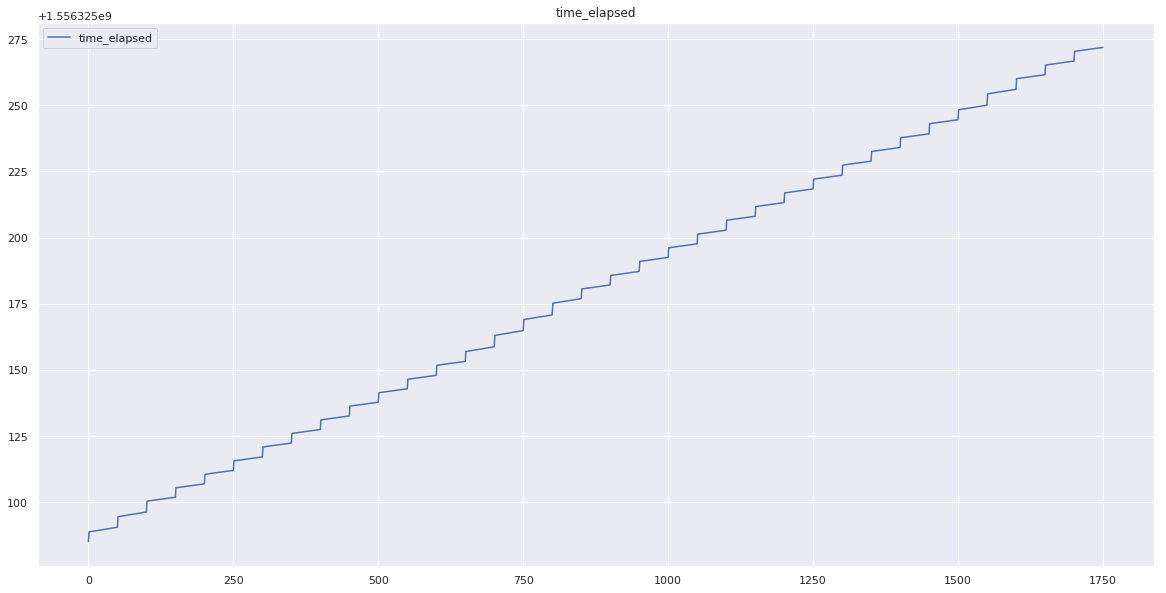

In [178]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [179]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

оэыолбвшрл || лршвблоыэо || лршвблоыэо
ьэзацчъону || уноъчцазэь || уноъчцазэь
кьтаквбмхэ || эхмбвкатьк || эхмбвкатьк
югащсттхшн || ншхттсщагю || ншхттсщагю
яффвоэдхфз || зфхдэовффя || зфхдэовффя


In [180]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.012508252111077308, 'target': 0.9954, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.009624160254503241, 'target': 0.9976794554455446, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.014148798513014128, 'target': 0.9938118811881188, 'char_acc_micro': 0.996875, 'char_acc_macro': 0.996875}


## Experiments with attention seq2seq  (2 points)

Compare performance (and times for training) of seq2seq model and attention seq2seq model.
A bidirectional model with attention and should be able to learn reverse (== copy) sequence in around 20-30 minutes. 

### model 1

attention after decoder, works MUCH better than models without attention, after 200 iterations target metric values become very close to 1

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_after_decoder=True,
    attention_before_decoder=False,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

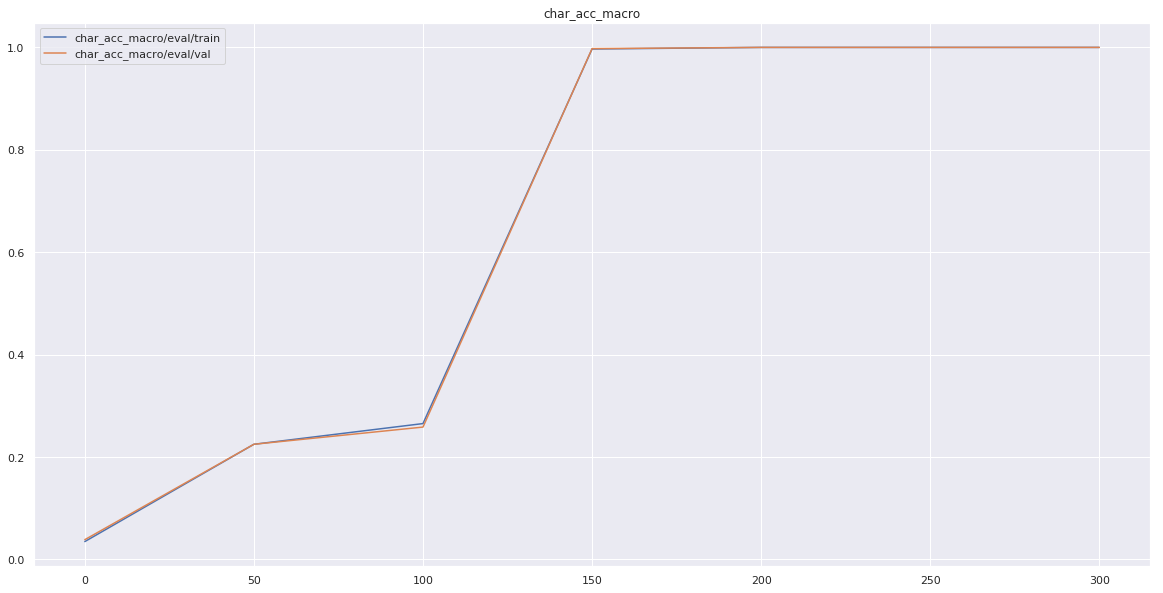

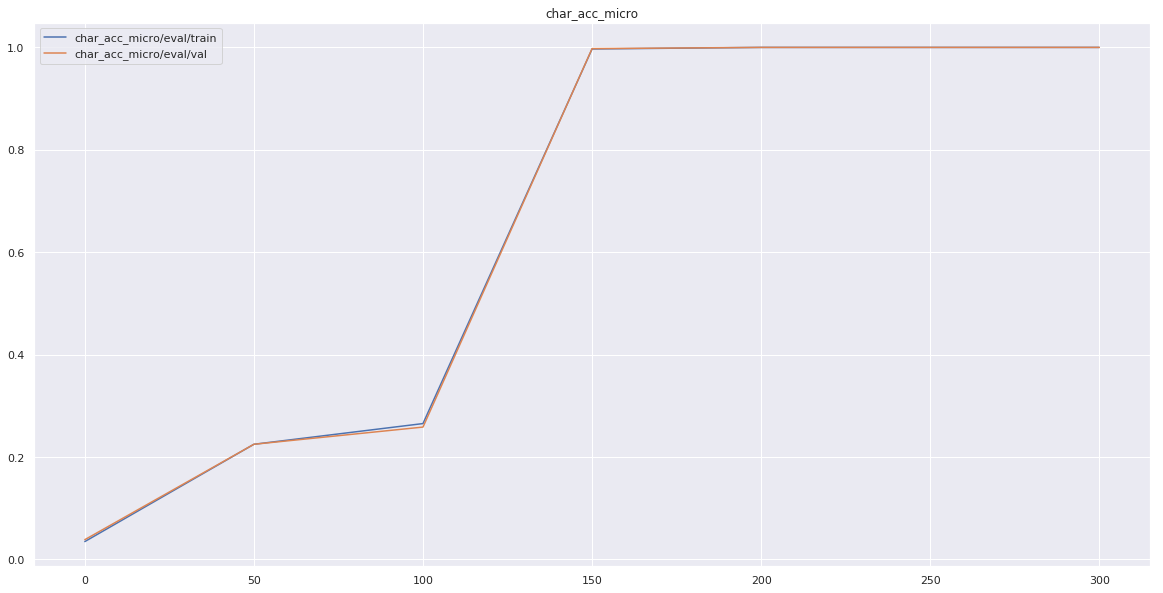

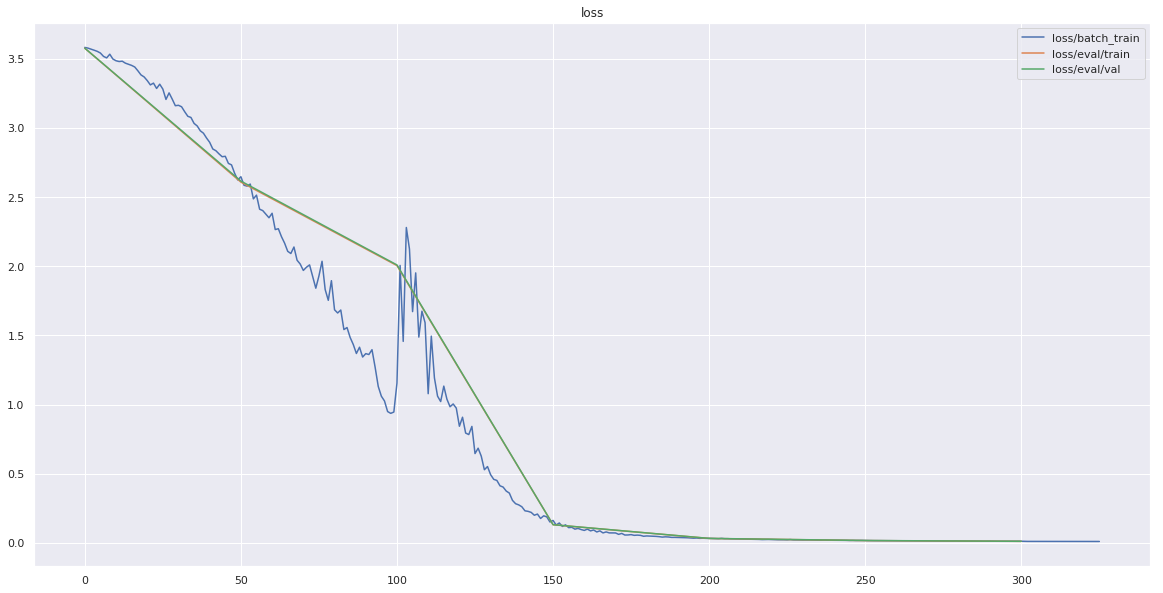

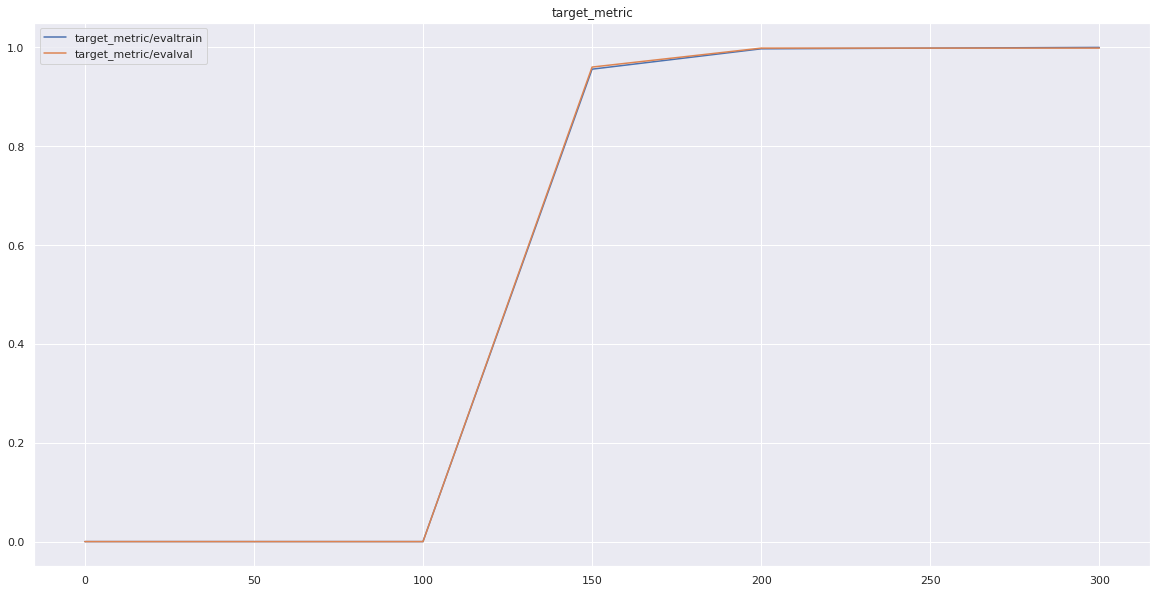

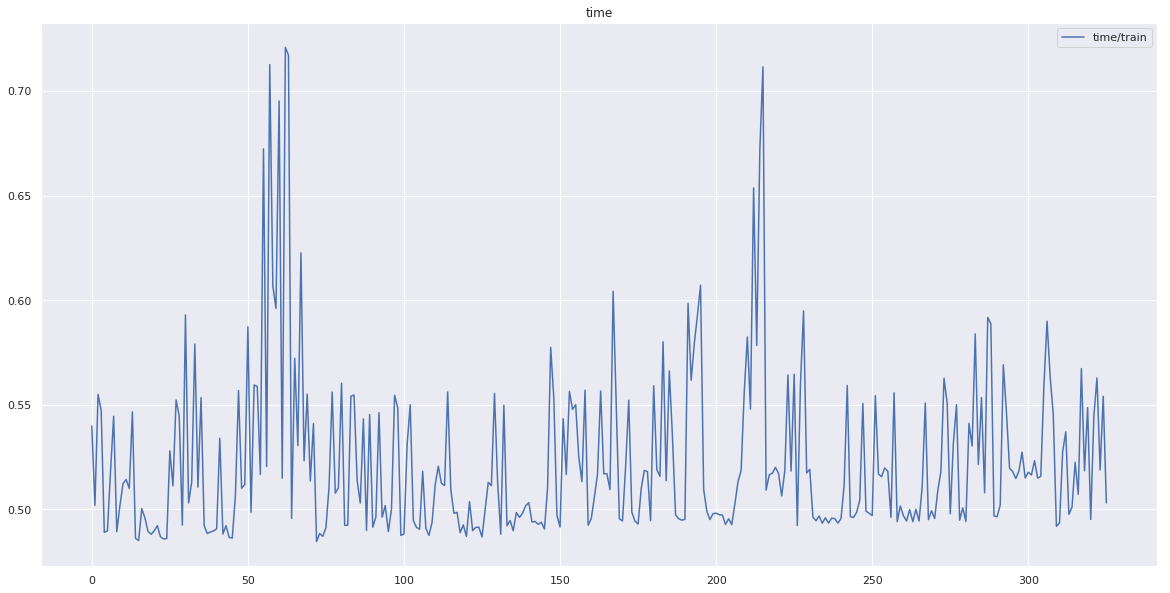

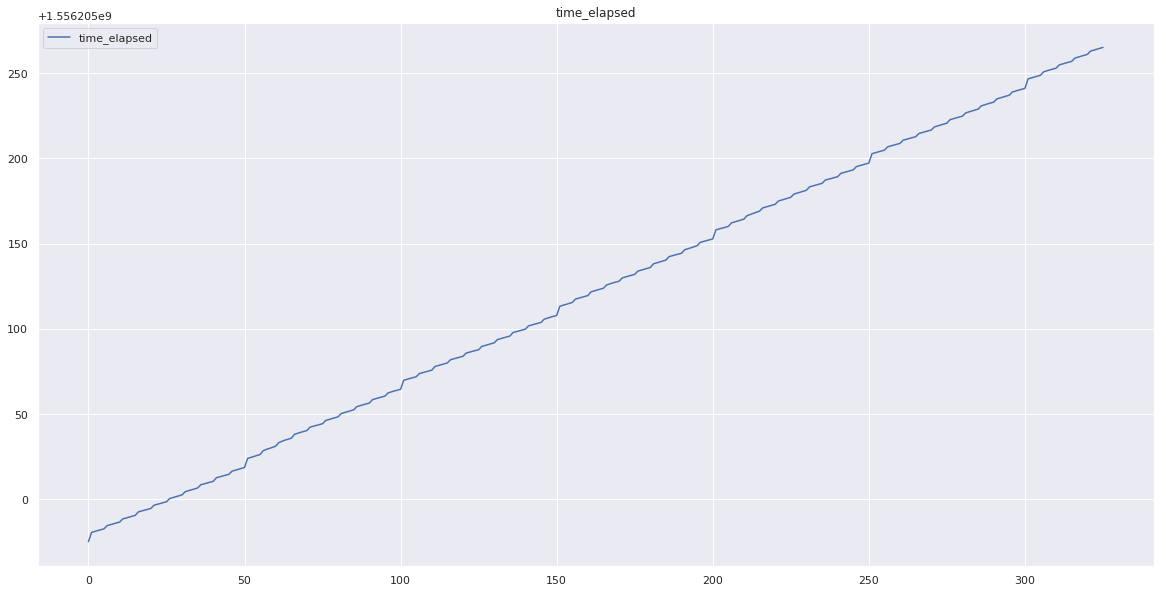

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.009728252586722374, 'target': 0.9999, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.009699311494679735, 'target': 0.9998452970297029, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.009749414961748195, 'target': 0.9998452970297029, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


### model 2

attention before decoder

very unstable, the model without attention shows even better performance

the training was stopped early because it was obvious the results would be bad

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_after_decoder=False,
    attention_before_decoder=True,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

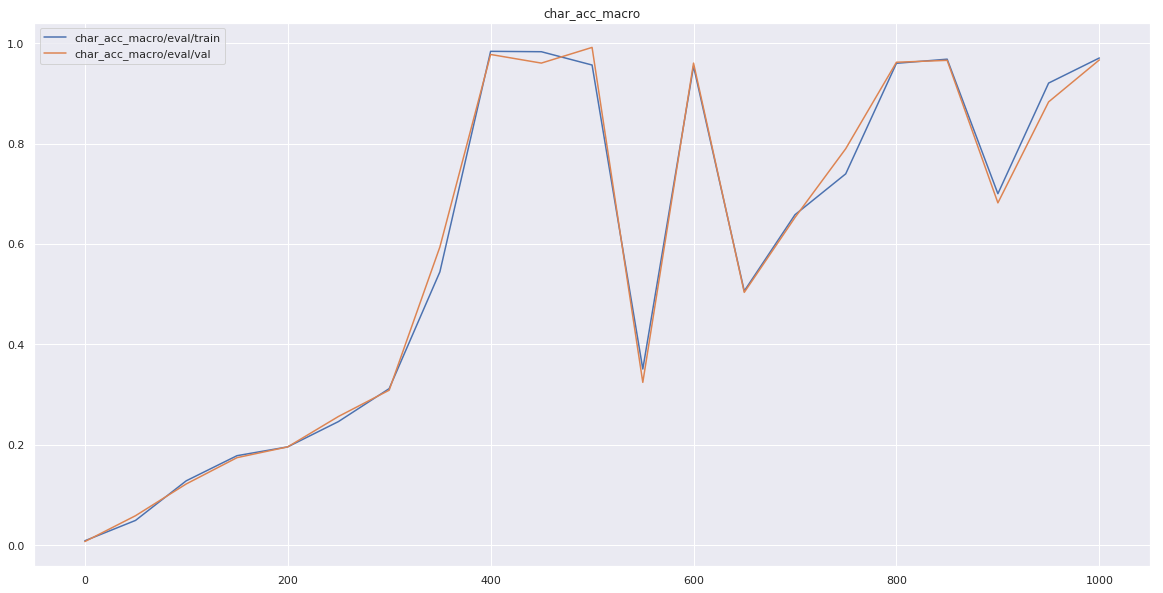

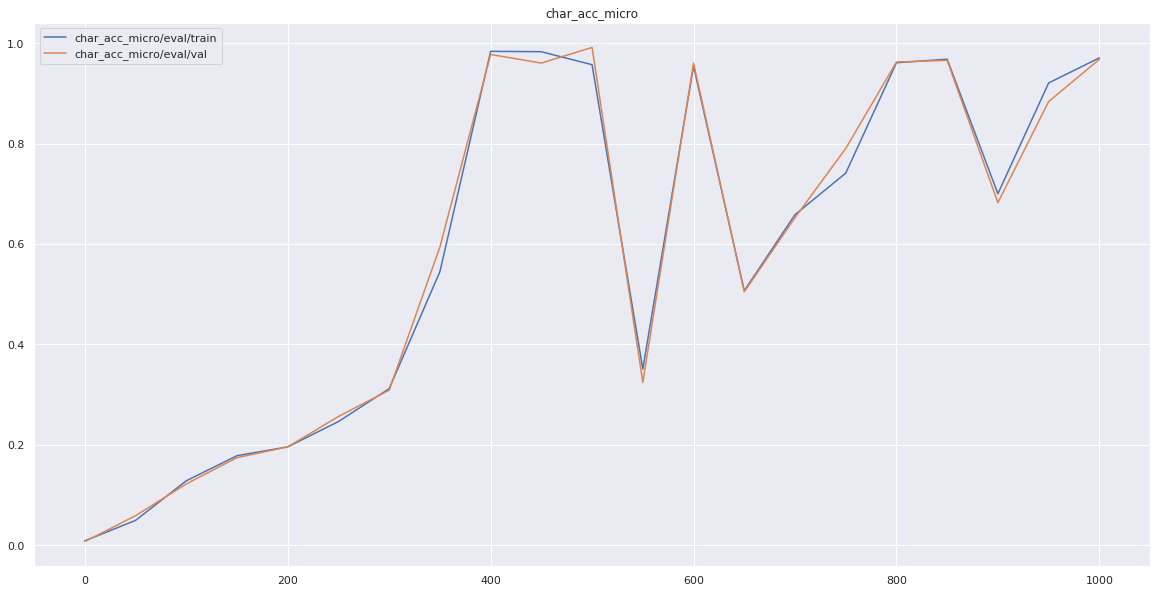

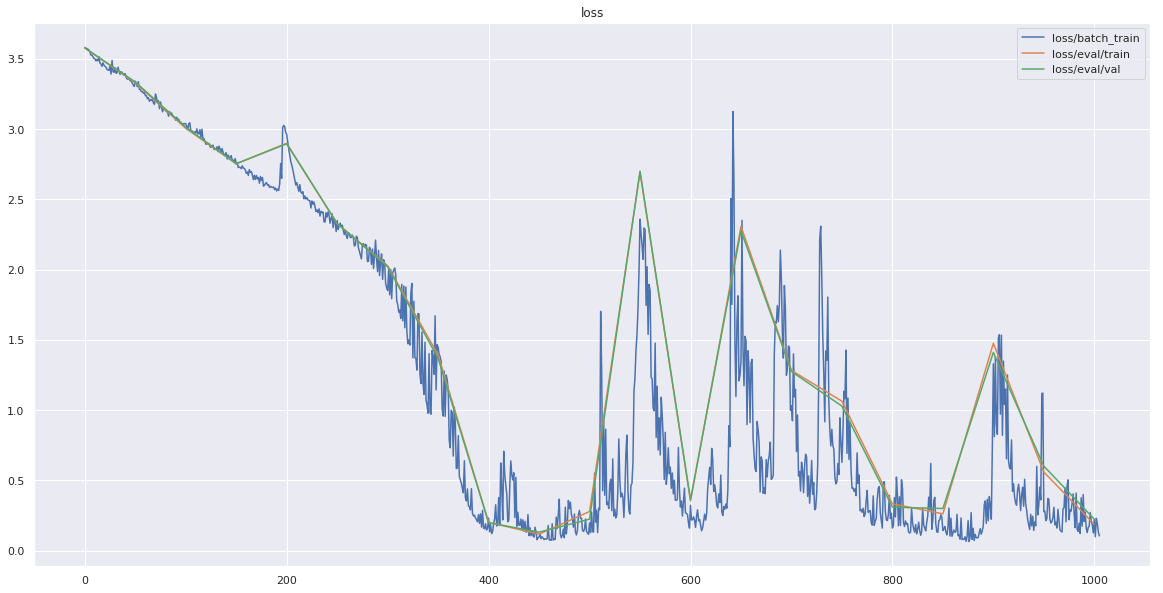

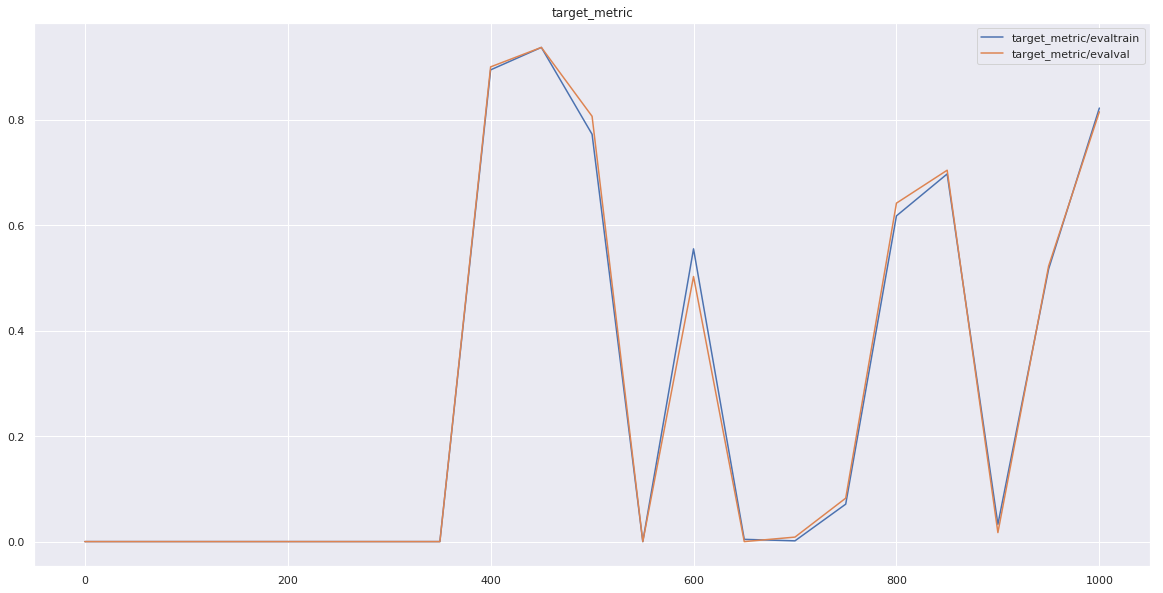

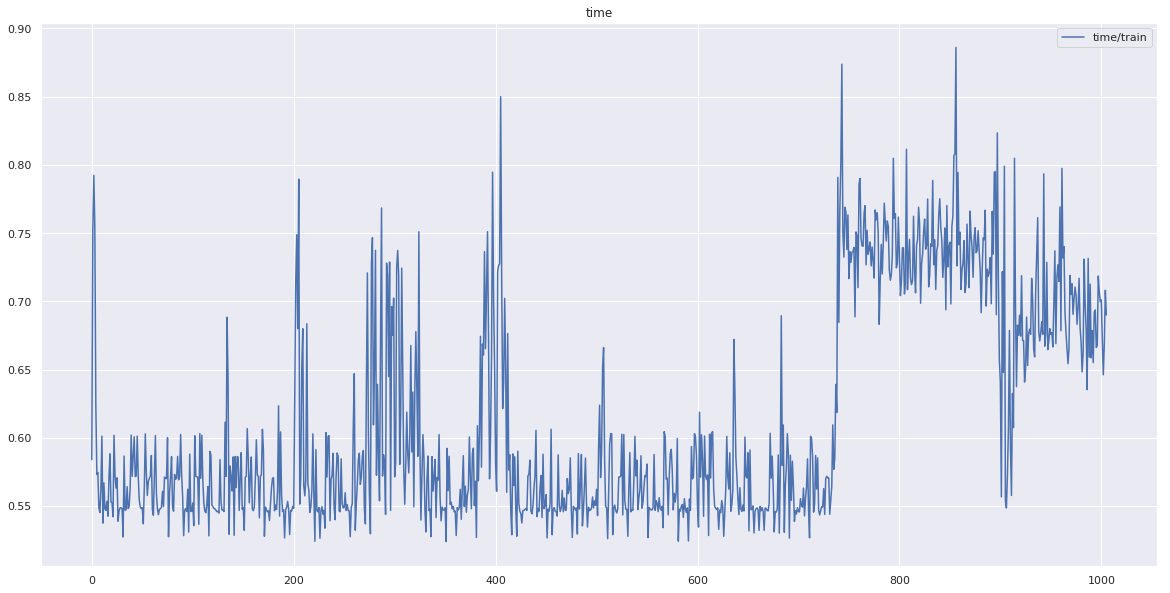

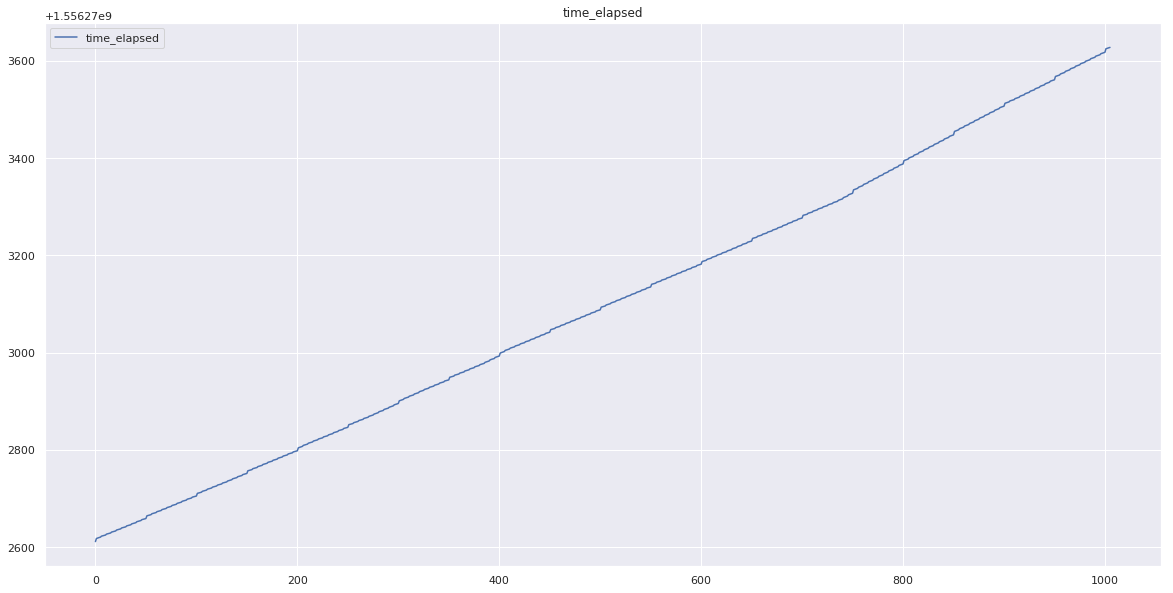

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

### model 3

attention both before and after decoder

in this task works practically the same as the model with attention only after decoder (converges after 200 iterations)

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_decoder=True,
    attention_after_decoder=True,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

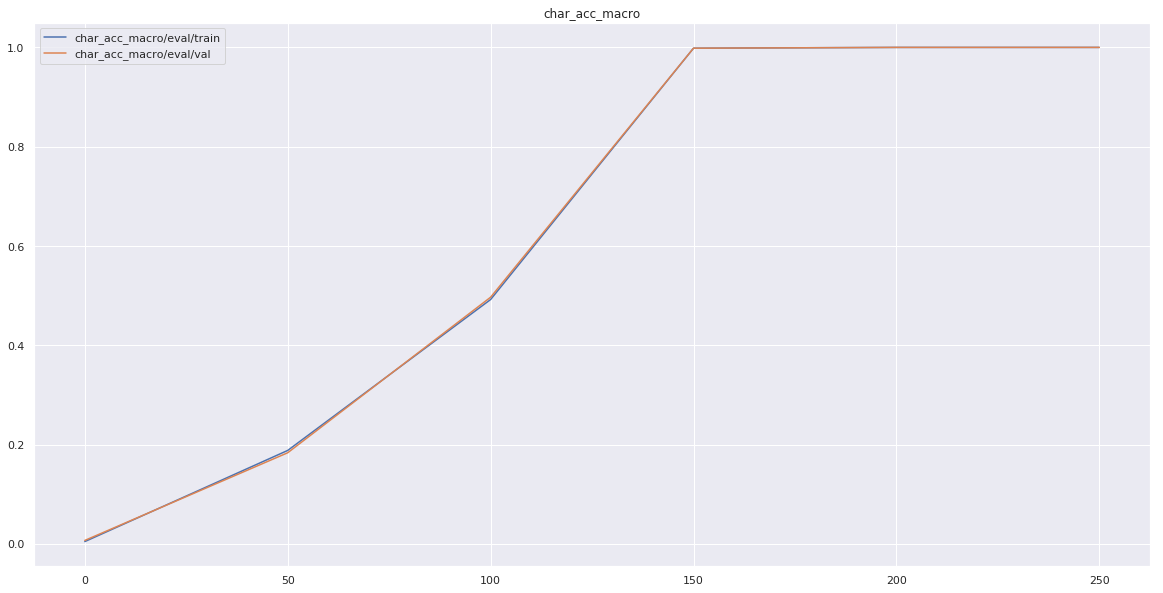

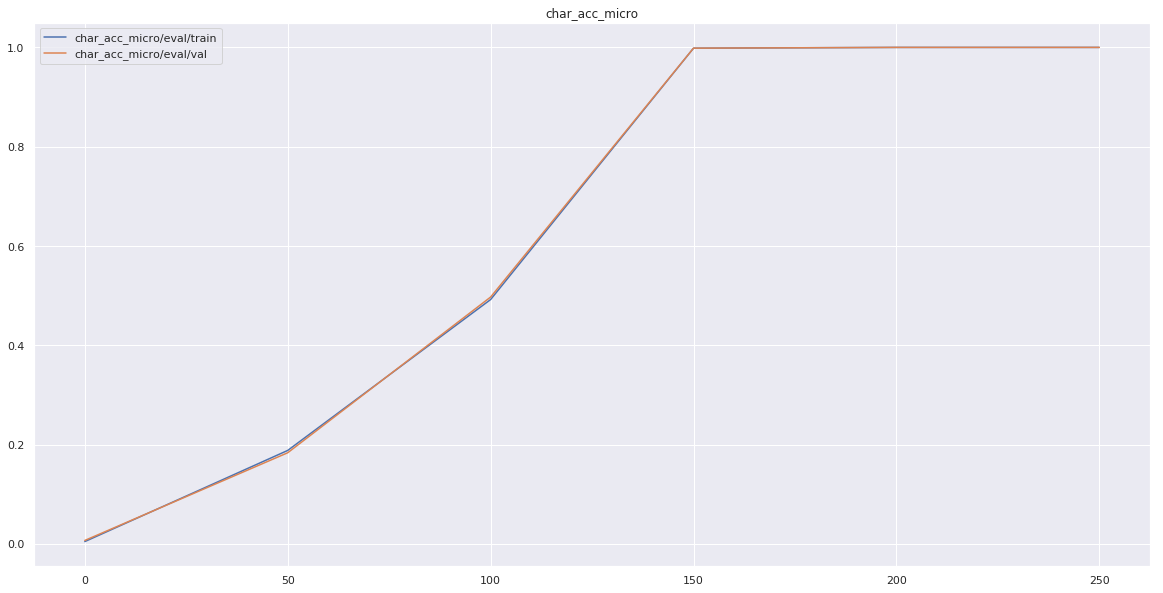

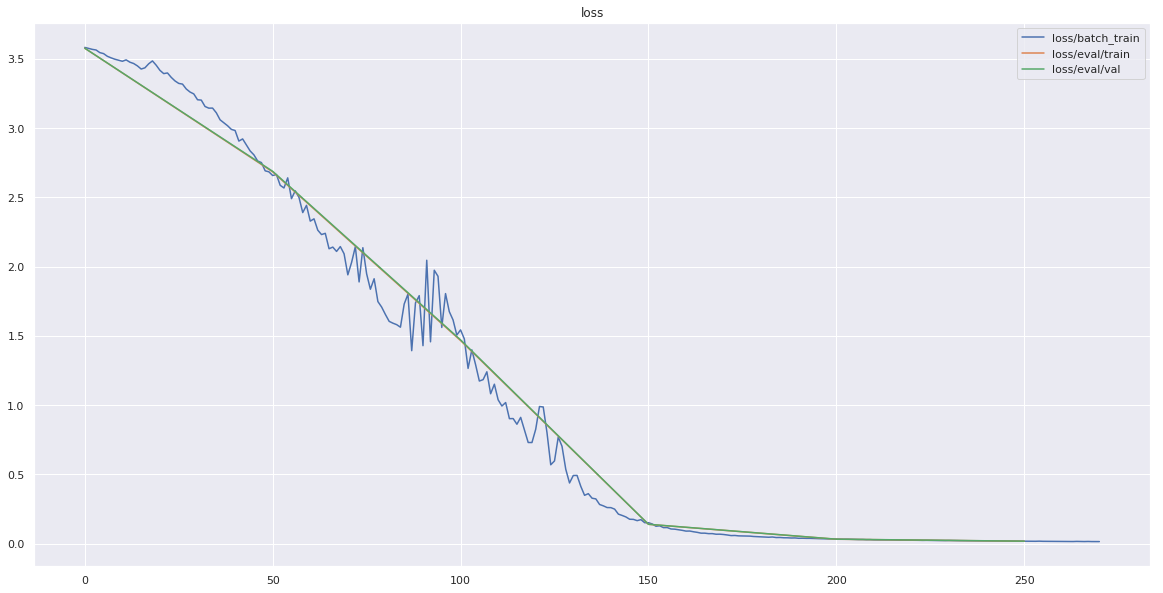

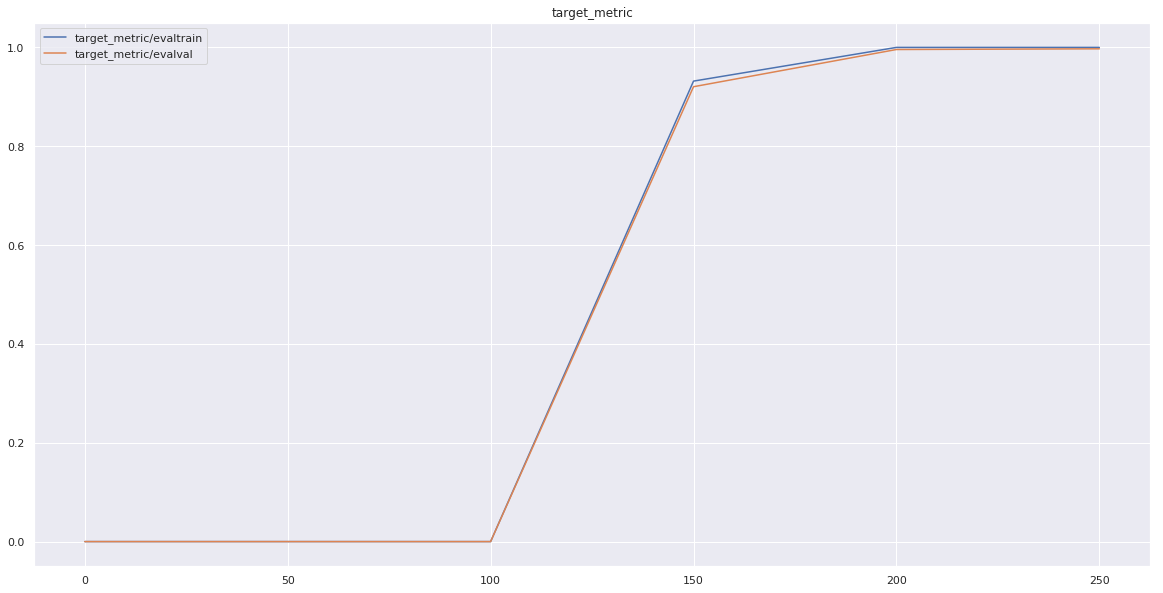

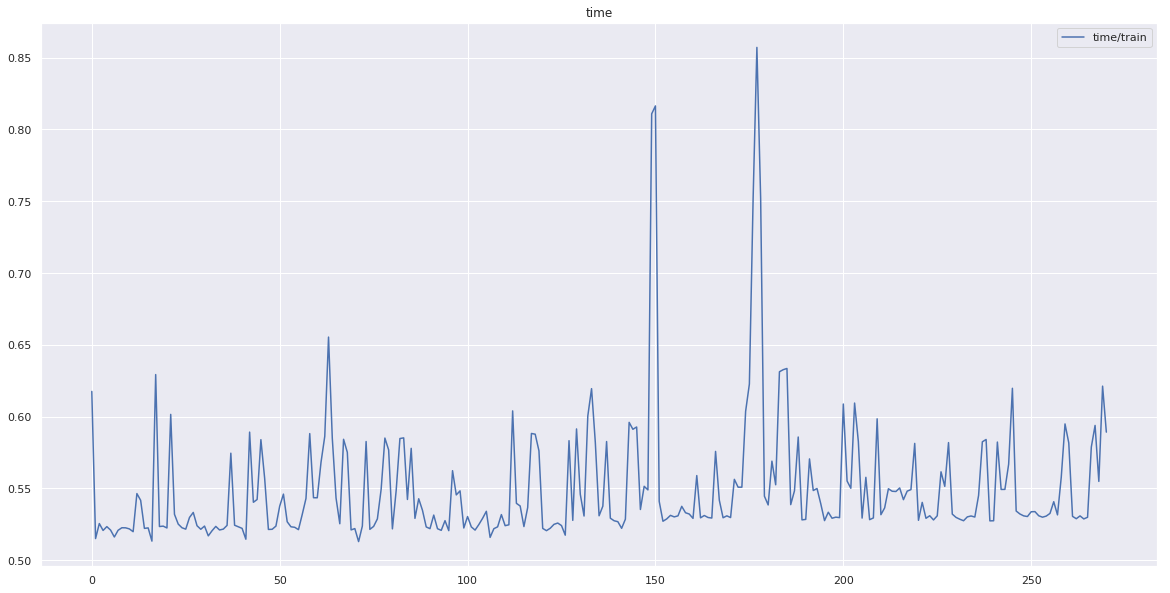

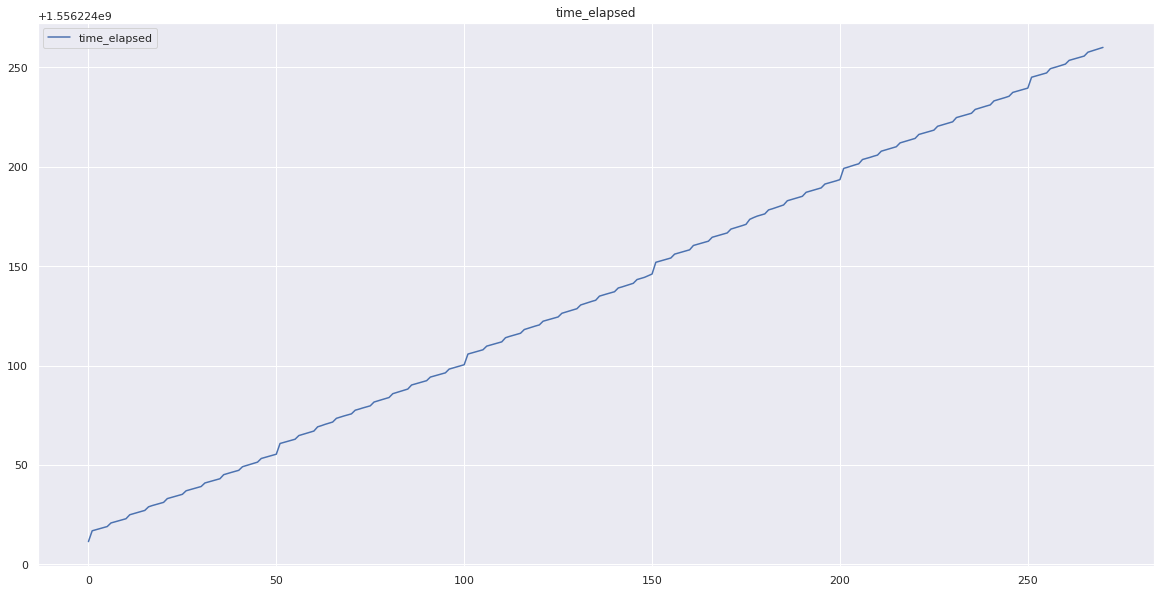

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

юнжчсгввтдуьржжтюгмт || тмгютжжрьудтввгсчжню || тмгютжжрьудтввгсчжню
ъшщшчцмдсейьбукшркуш || шукршкубьйесдмцчшщшъ || шукршкубьйесдмцчшщшъ
гпсетдыщрцамбфвлхрив || вирхлвфбмацрщыдтеспг || вирхлвфбмацрщыдтеспг
кзлъшюузвмддурфэбшнр || рншбэфруддмвзуюшълзк || рншбэфруддмвзуюшълзк
уиояоуииьшенщкйтейфд || дфйетйкщнешьииуояоиу || дфйетйкщнешьииуояоиу


In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.0136464571967721, 'target': 0.9992, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.013569358348993971, 'target': 0.999690594059406, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.013671566160524836, 'target': 0.9993811881188119, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


### model 4

general attention

in this task shows the same performance as dot attention

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_decoder=False,
    attention_after_decoder=True,
    bidirectional=True, 
    attention_type='general',
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

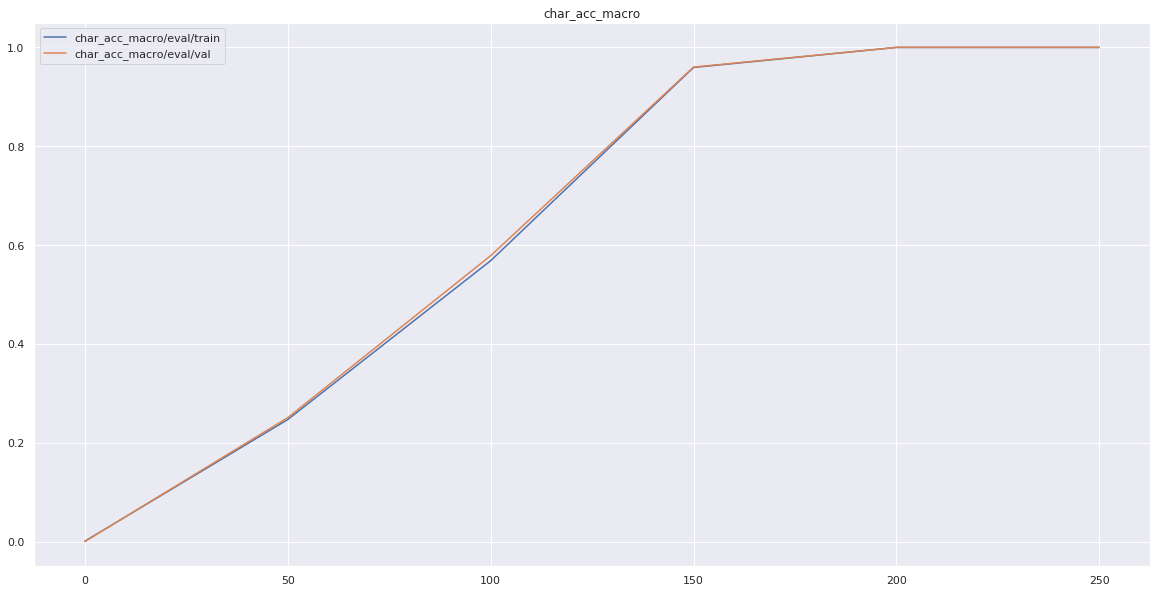

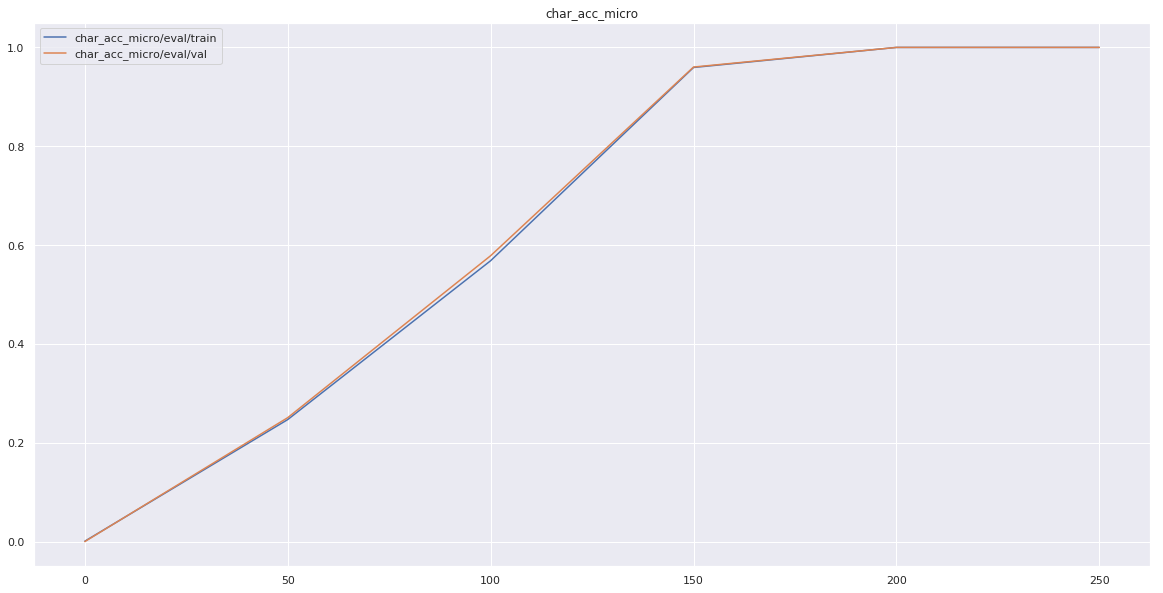

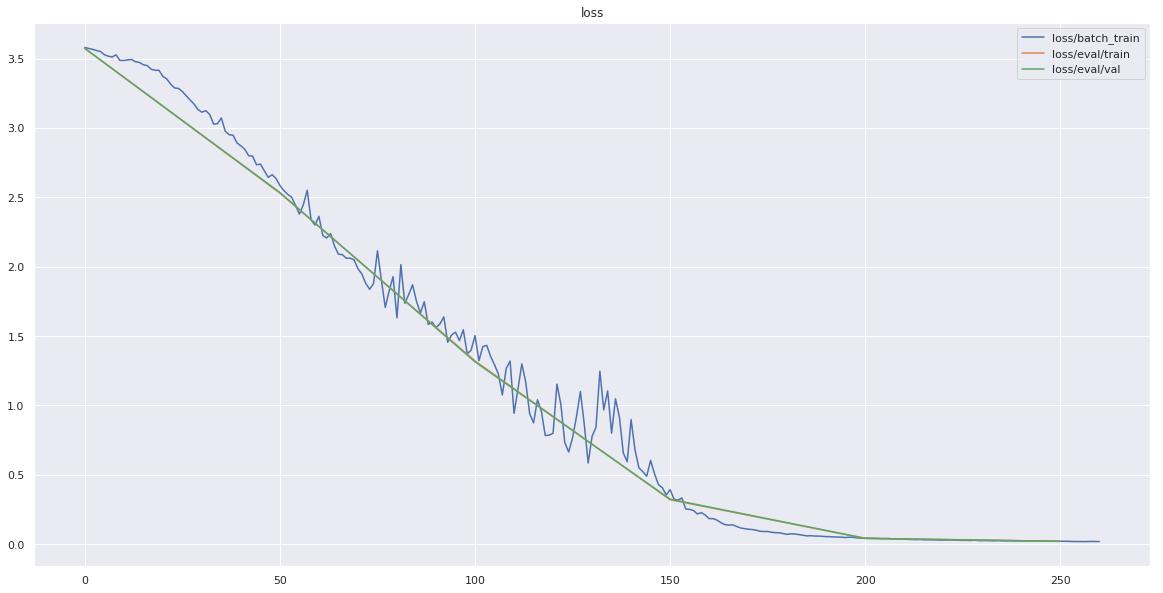

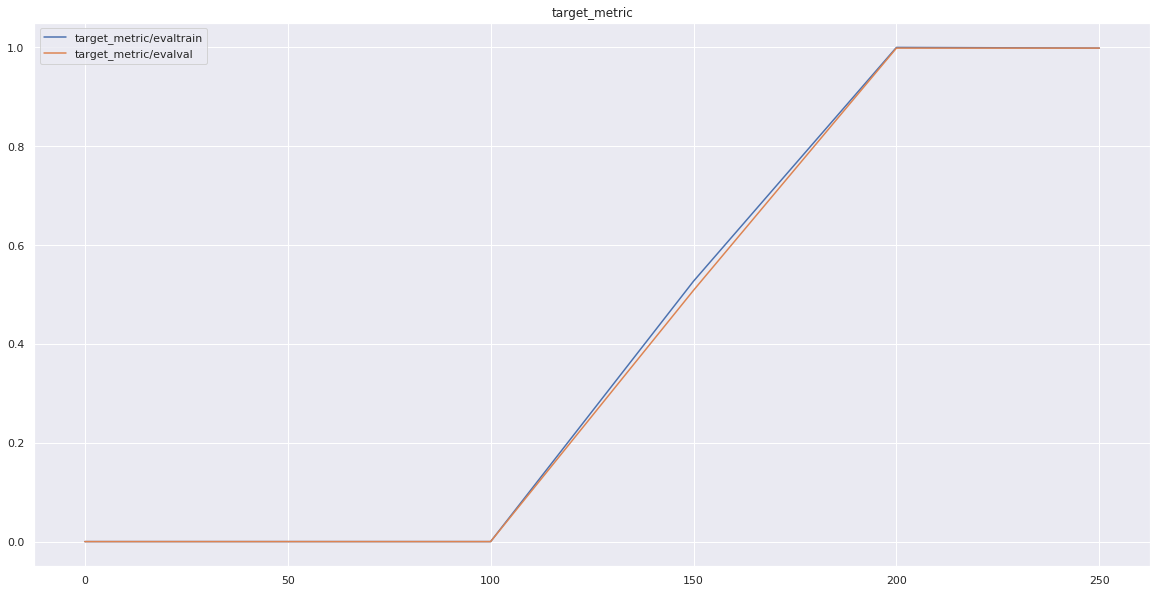

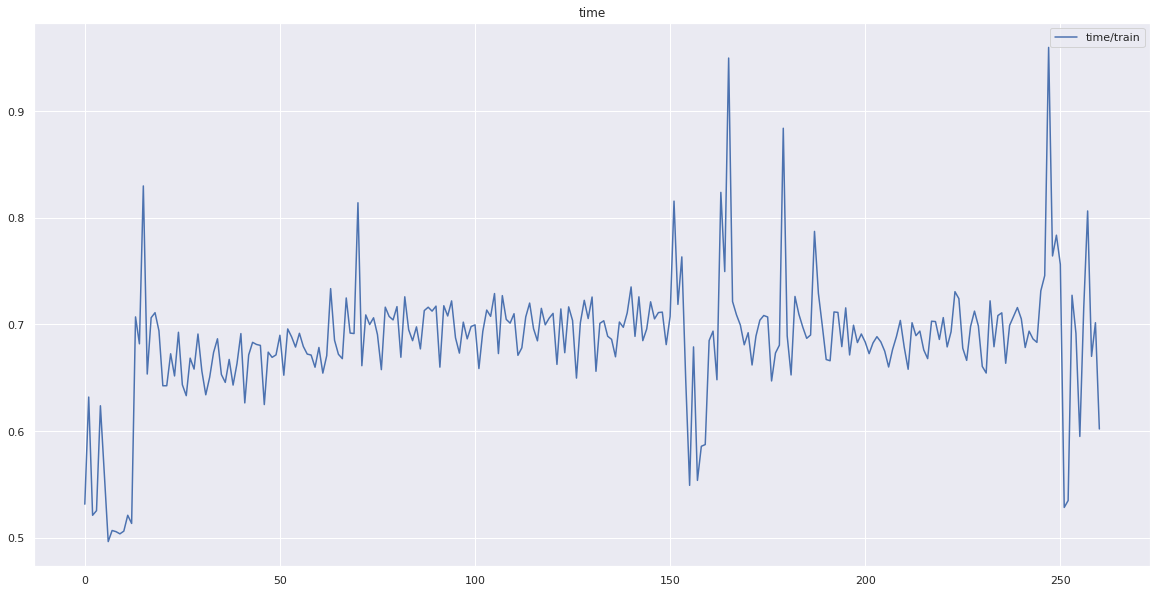

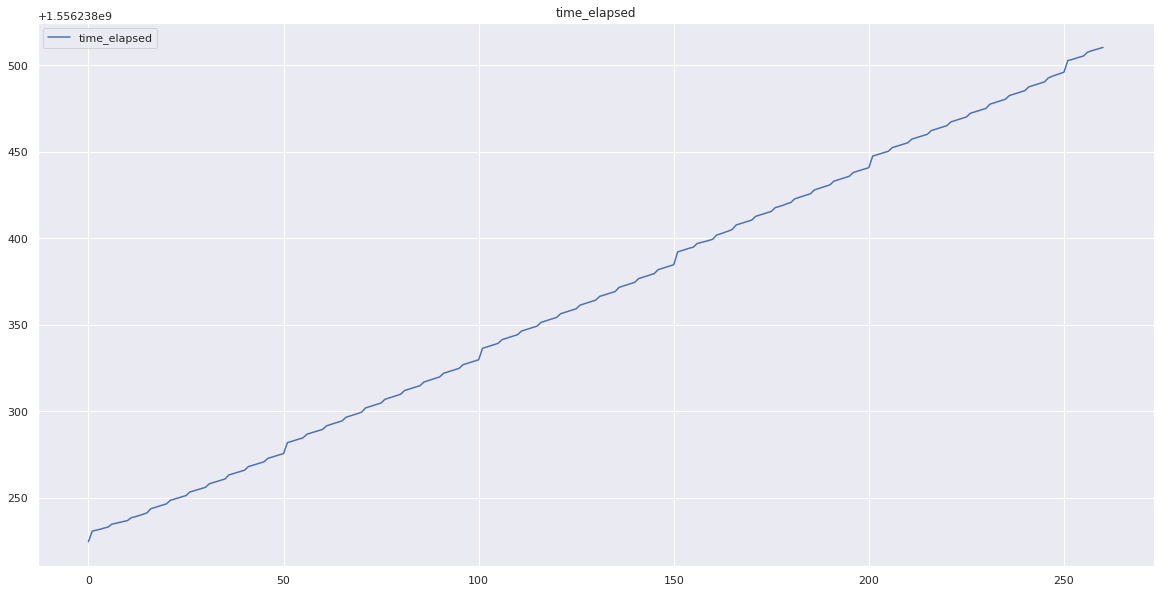

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

дсщеятпхняъсурмчкгтз || зтгкчмрусъянхптяещсд || зтгкчмрусъянхптяещсд
дщйиячзюцкэдбмзкмкдй || йдкмкзмбдэкцюзчяийщд || йдкмкзмбдэкцюзчяийщд
чердокыъжзимппллкябс || сбякллппмизжъыкодреч || сбякллппмизжъыкодреч
фдгэщюжзэкльноовбймм || ммйбвооньлкэзжющэгдф || ммйбвооньлкэзжющэгдф
вффняяъеэтйсвзбшжзйг || гйзжшбзвсйтэеъяянффв || гйзжшбзвсйтэеъяянффв


In [0]:
print('test:', evaluate_result_test)
print('train:', evaluate_result_train)
print('val:', evaluate_result_val)

test: {'loss': 0.018427634066343308, 'target': 0.9984, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
train: {'loss': 0.01834454789462656, 'target': 0.9992264851485149, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
val: {'loss': 0.018517444850784718, 'target': 0.9979888613861386, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


### Attention visualization  

Now let's look at what the attention mechanism has learnt.

In [0]:
# Implement this function
# Tip: use seaborn heatmap
def visualize_attention(text_x, text_y, attention_weights, axis):
    sns.set()
    df = pd.DataFrame(attention_weights, index=text_x, columns=text_y)
    sns.heatmap(df, ax=axis, xticklabels=True, yticklabels=True, square=True)
    axis.set_xticklabels(text_y, rotation=0)

In [0]:
def use(line, model, loss_object, max_output_length):
    """
    line: line to transform
    model: seq2seq model
    loss_object: Seq2SeqUser for the model
    
    uses and prints
    """
    decoded, preds, debug_info = loss_object.use(seq2seq_model, list(line),
                                                 max_output_length=max_output_length)
    decoded = decoded[0]
    attention_weights = debug_info['attention_weights'][0]
    print(line, " -> ", decoded)
    

In [0]:
def use_and_visualize(line, model, loss_object, max_output_length):
    """
    line: line to transform
    model: seq2seq model
    loss_object: Seq2SeqUser for the model
    
    uses the model, prints the output and visualizes the attention mask
    """
    decoded, preds, debug_info = loss_object.use(seq2seq_model, list(line),
                                                 max_output_length=max_output_length)
    attention_weights = debug_info['attention_weights'][0]
    print(line, " -> ", decoded[0])
    visualize_attention(
        text_x=debug_info['sequence_padded'],
        text_y=debug_info['decoded_padded'],
        attention_weights=attention_weights
    )

In [0]:
# Use this if your loss object stores the samples from the evaluation
def visualize_func(ind, axis, loss_object):
    item = (loss_object.raw_samples[ind][0], loss_object.attention_weights[ind][0])
    visualize_attention(item[0][0], item[0][2], item[1], axis)

Visualize attention weights and explain them.
Try to generate various inputs to produce interesting outputs.
Try to break the model and make in return nonsense for a reasonable input.

Describe what you see.
Why is attention like that? (Results may differ).

Attention weight during different periods of training were visualized for the progress to be seen. At the beginning all the weights were practically the same (their values are the ones that sum into 1), while at the last iterations each token has the weight referring to the same token close to one (the matrix is almost diagonal, except for <eos> token).

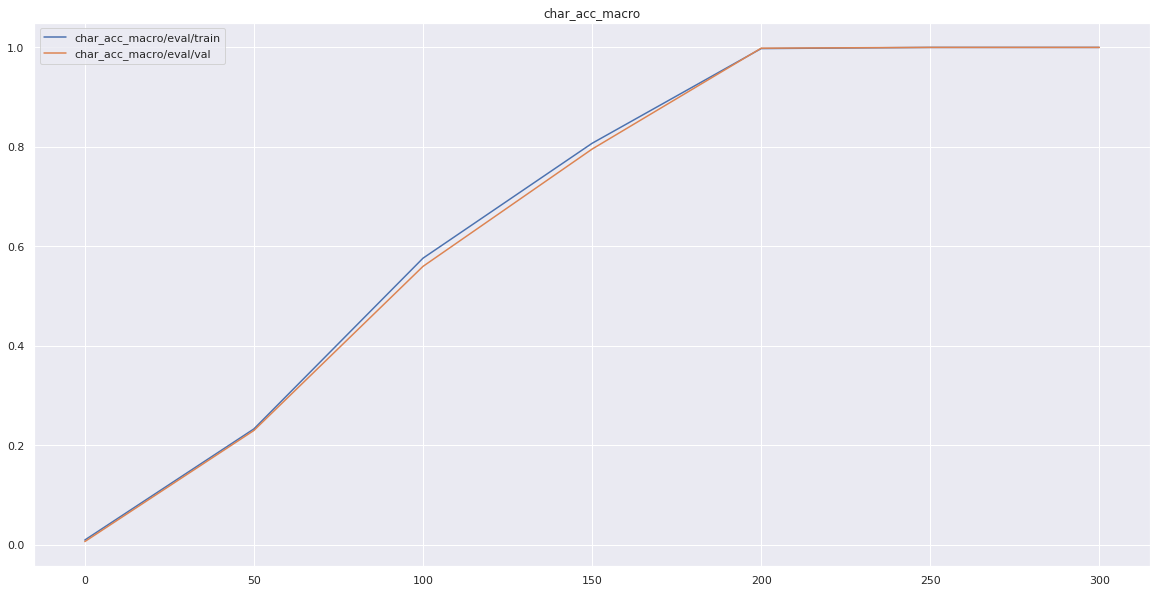

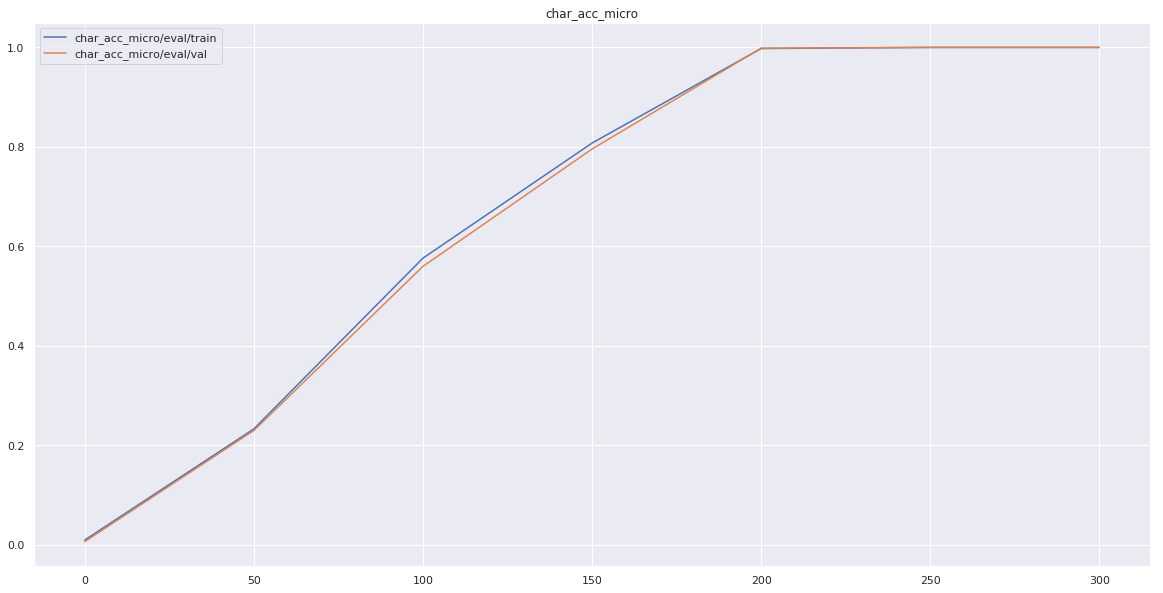

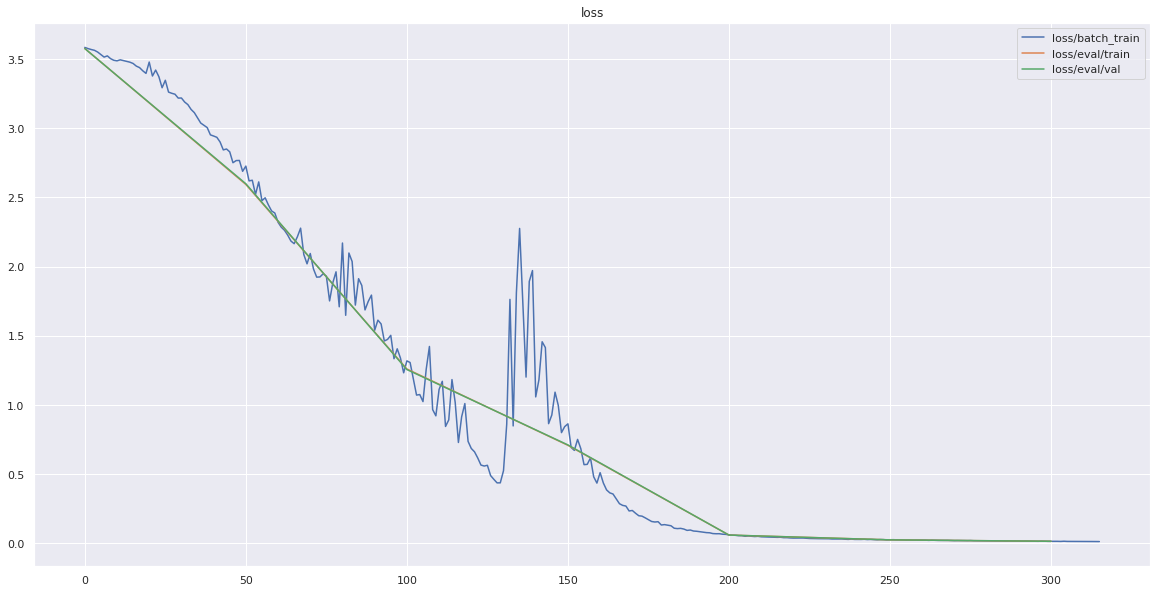

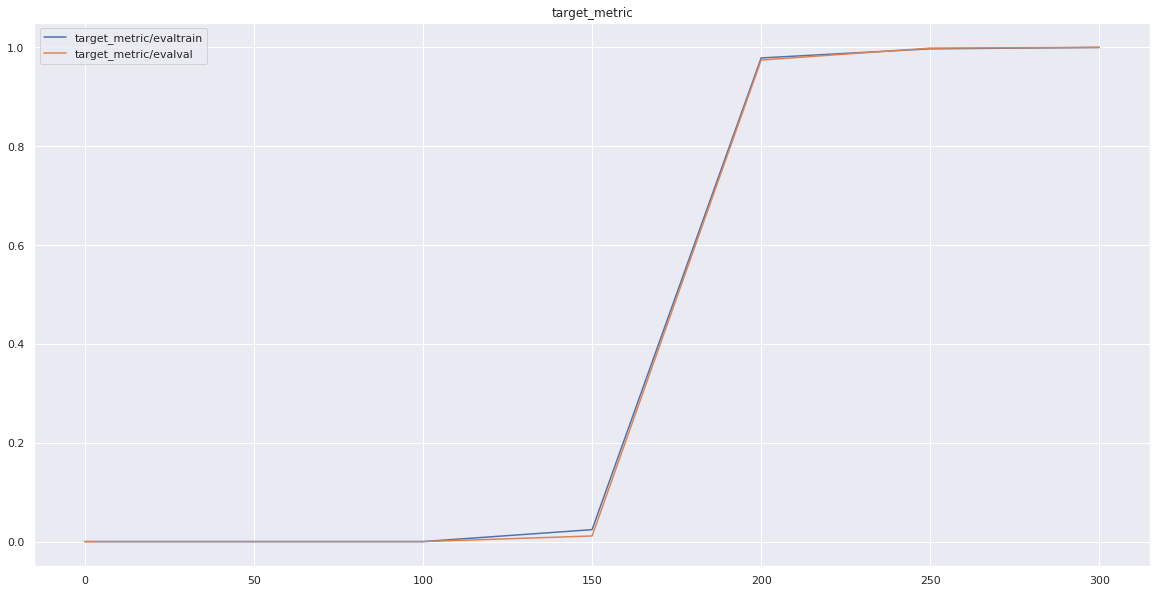

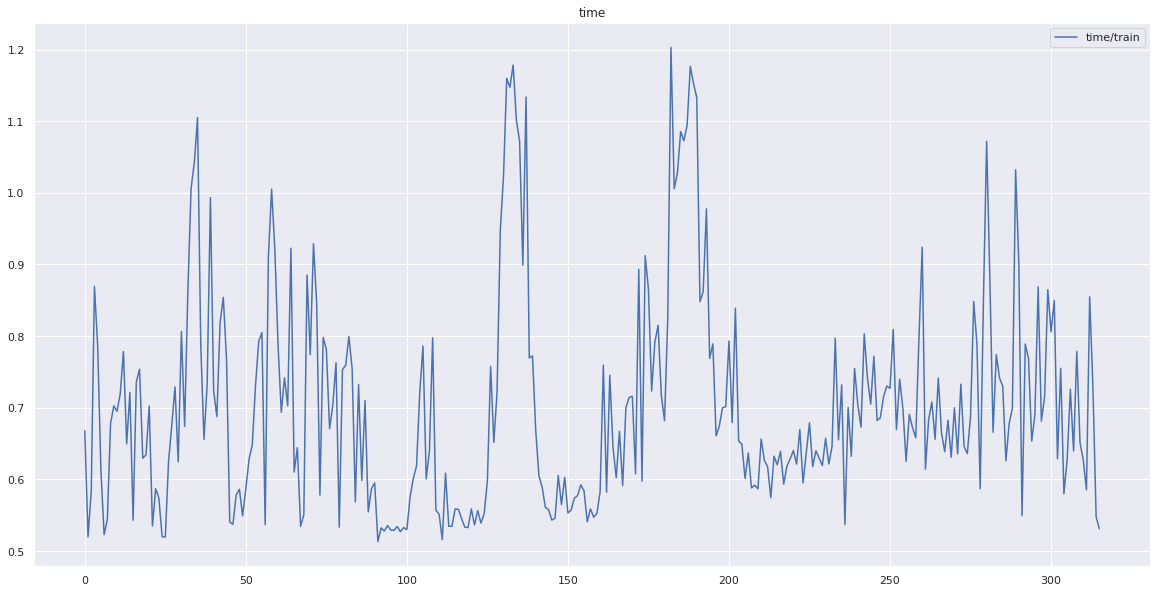

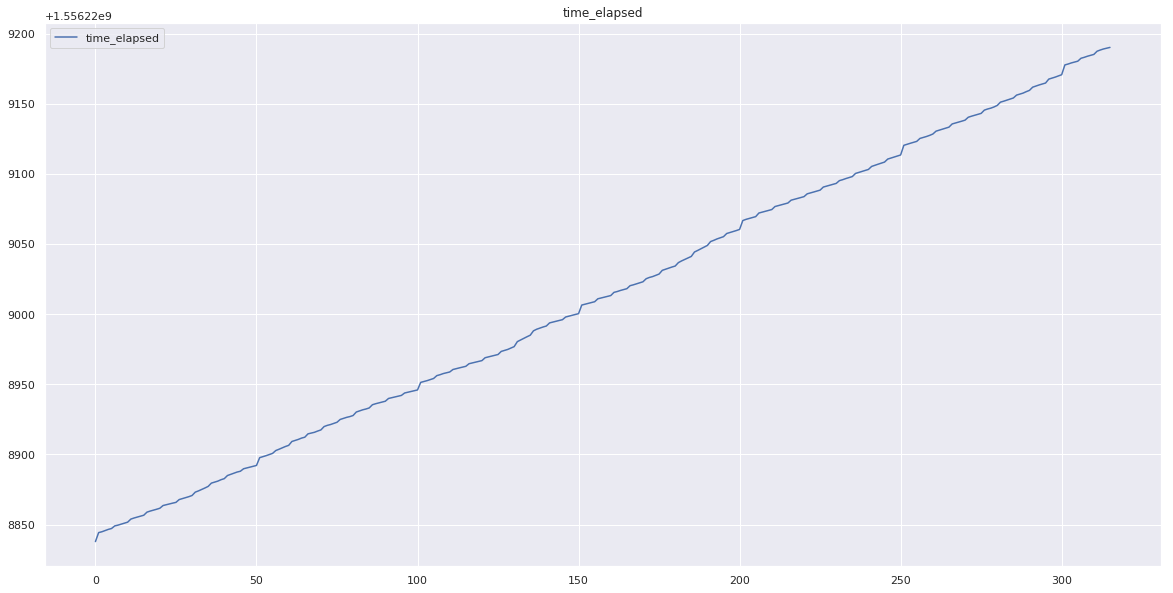

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_decoder=True,
    attention_after_decoder=True,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

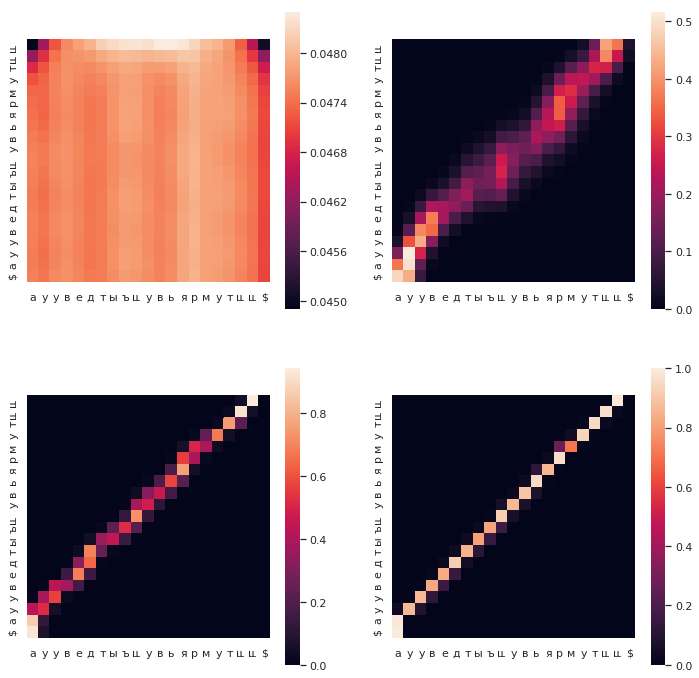

In [0]:
fix, axs = plt.subplots(2, 2, figsize=(12, 12))
visualize_func(0, axs[0, 0], loss_object)
visualize_func(1, axs[0, 1], loss_object)
visualize_func(2, axs[1, 0], loss_object)
visualize_func(5, axs[1, 1], loss_object) 
plt.show()

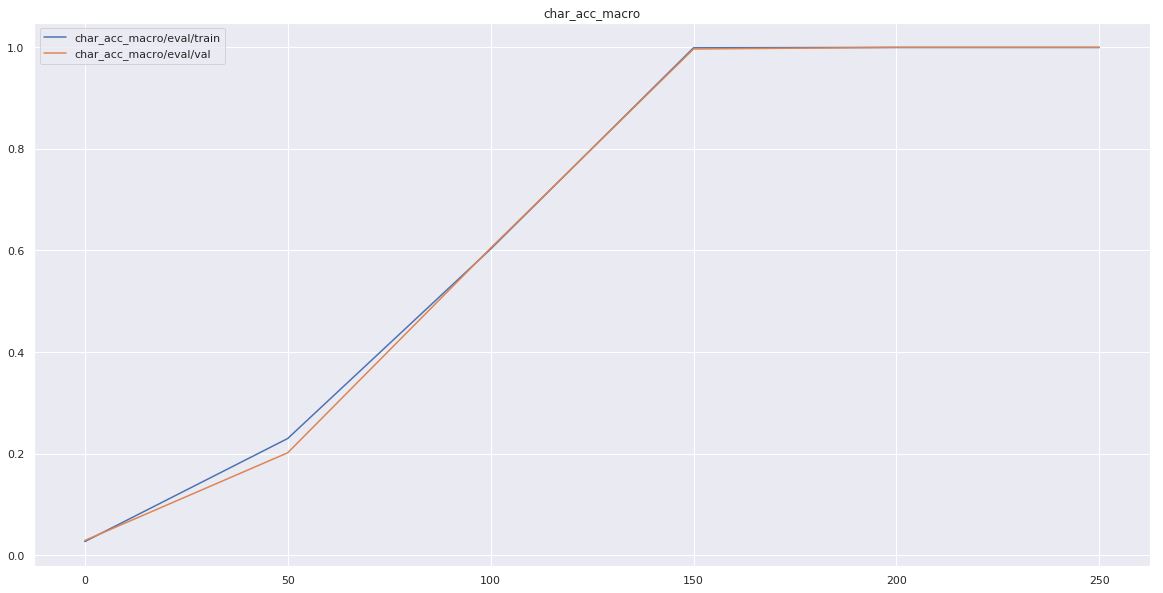

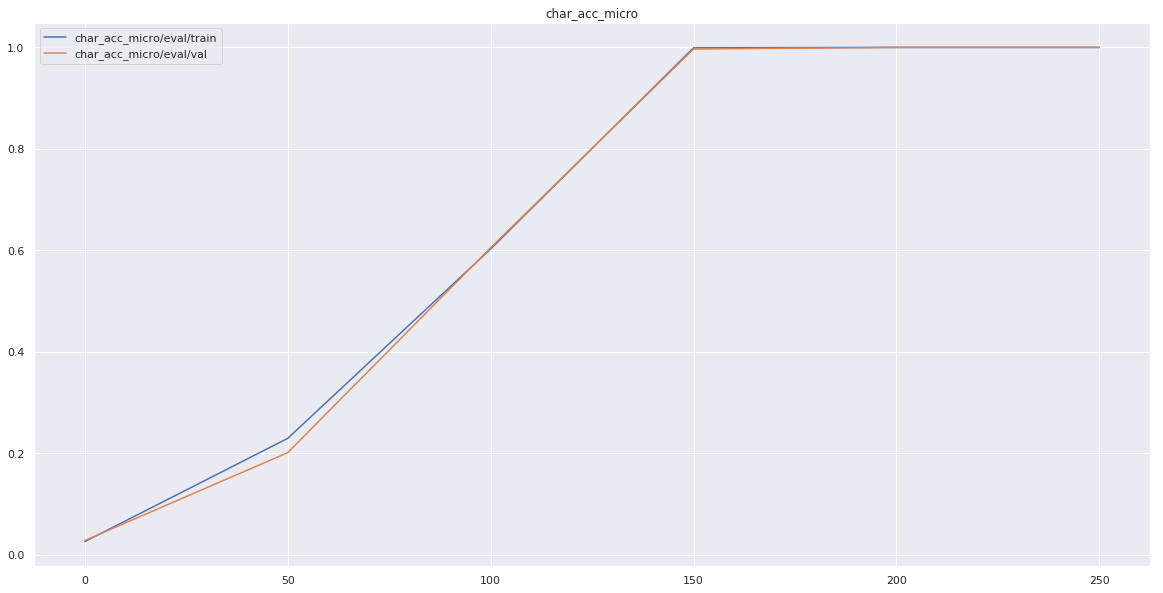

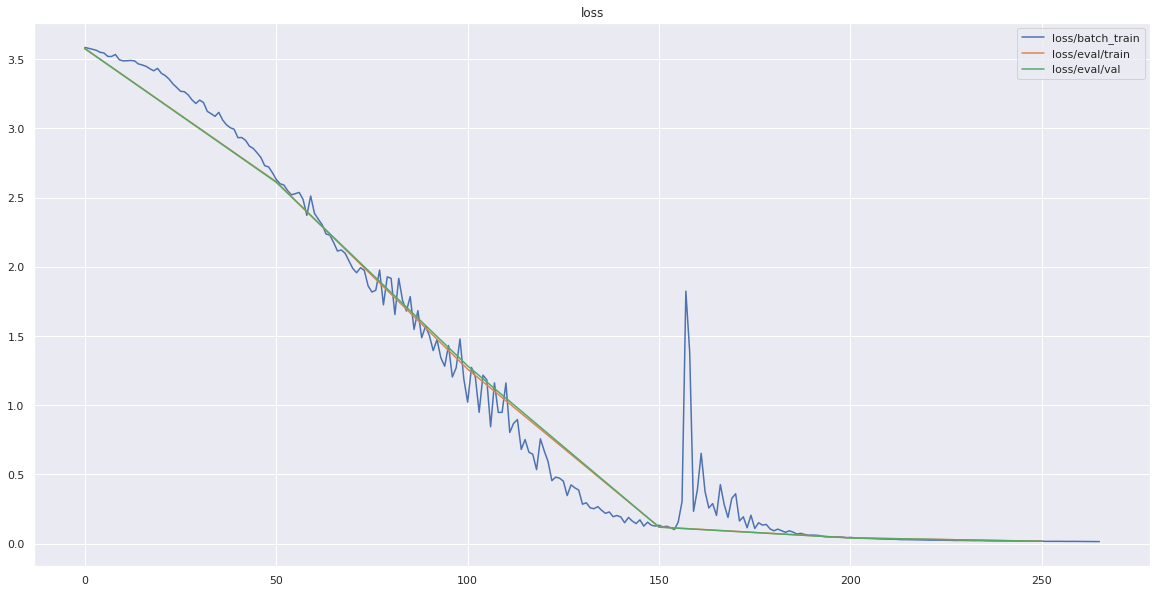

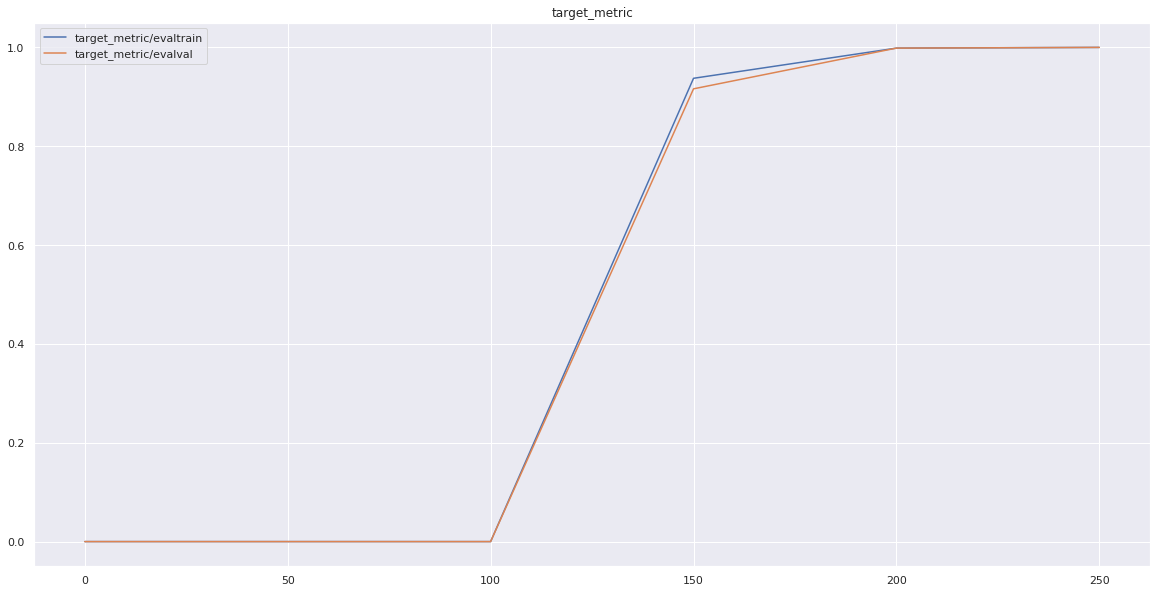

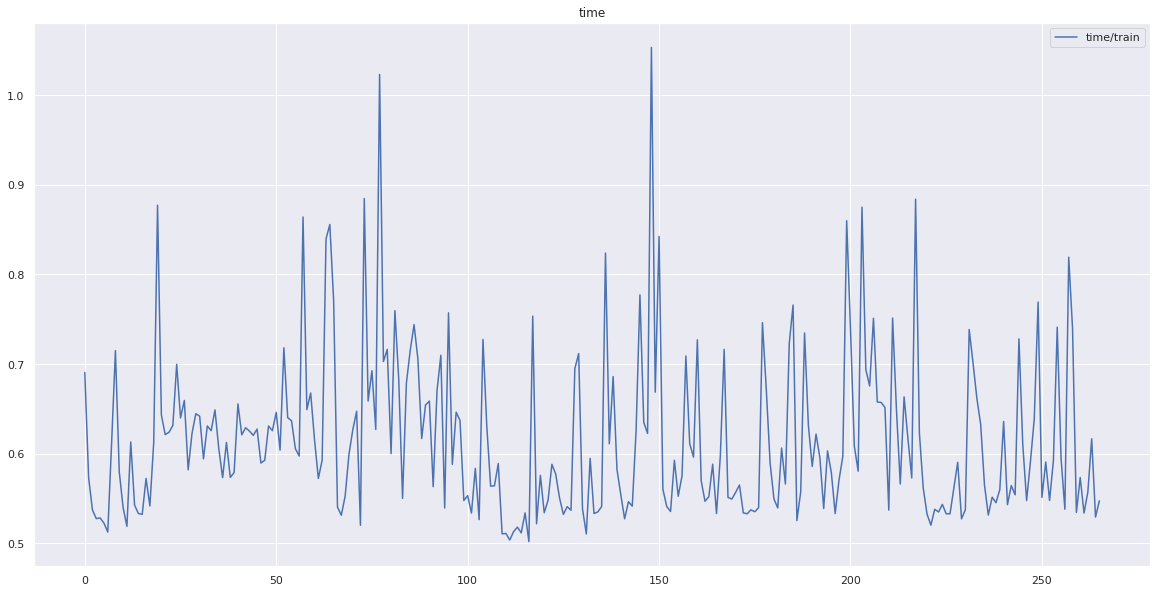

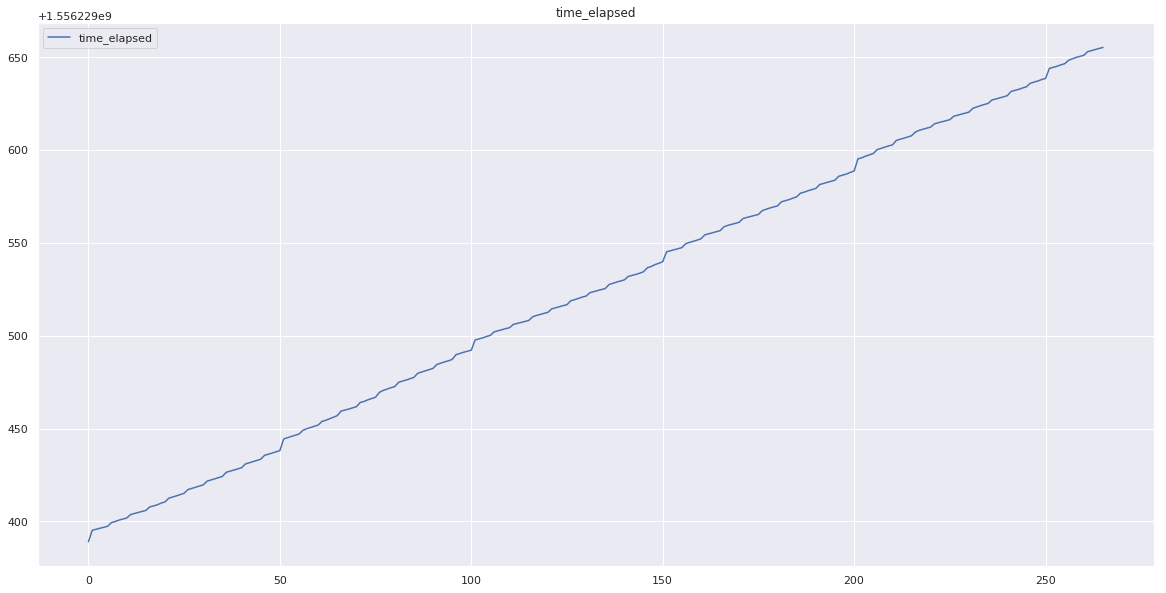

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_decoder=False,
    attention_after_decoder=True,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

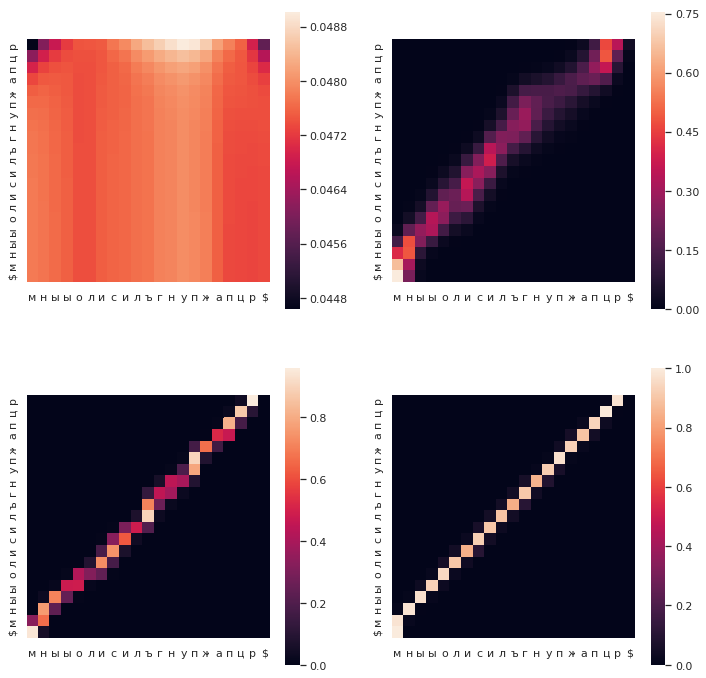

In [0]:
fix, axs = plt.subplots(2, 2, figsize=(12, 12))
visualize_func(0, axs[0, 0], loss_object)
visualize_func(1, axs[0, 1], loss_object)
visualize_func(2, axs[1, 0], loss_object)
visualize_func(5, axs[1, 1], loss_object) 
plt.show()

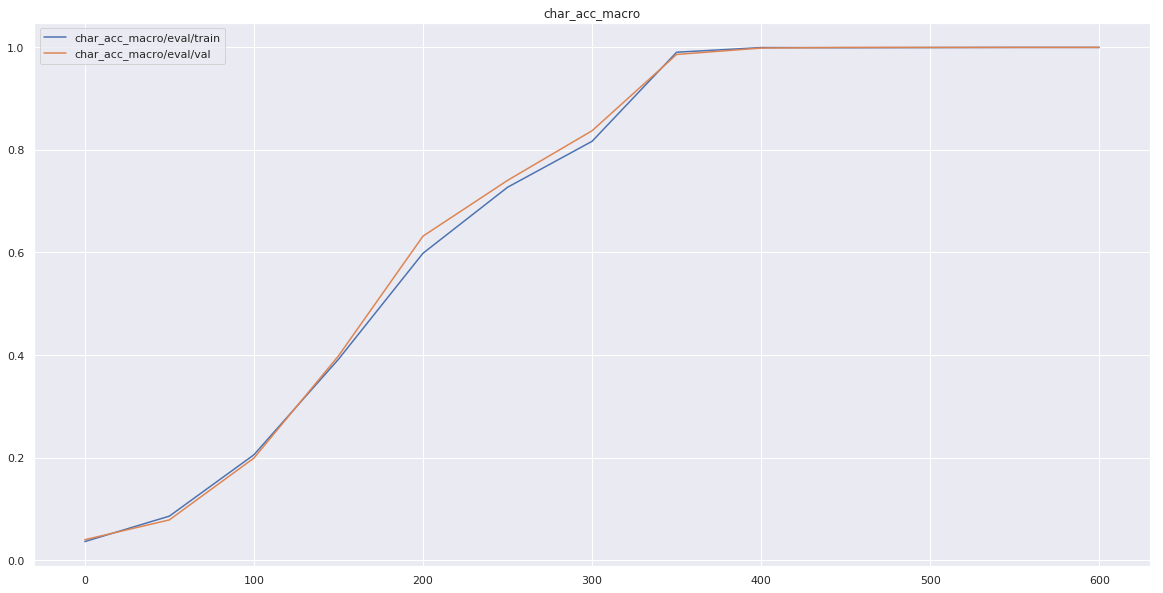

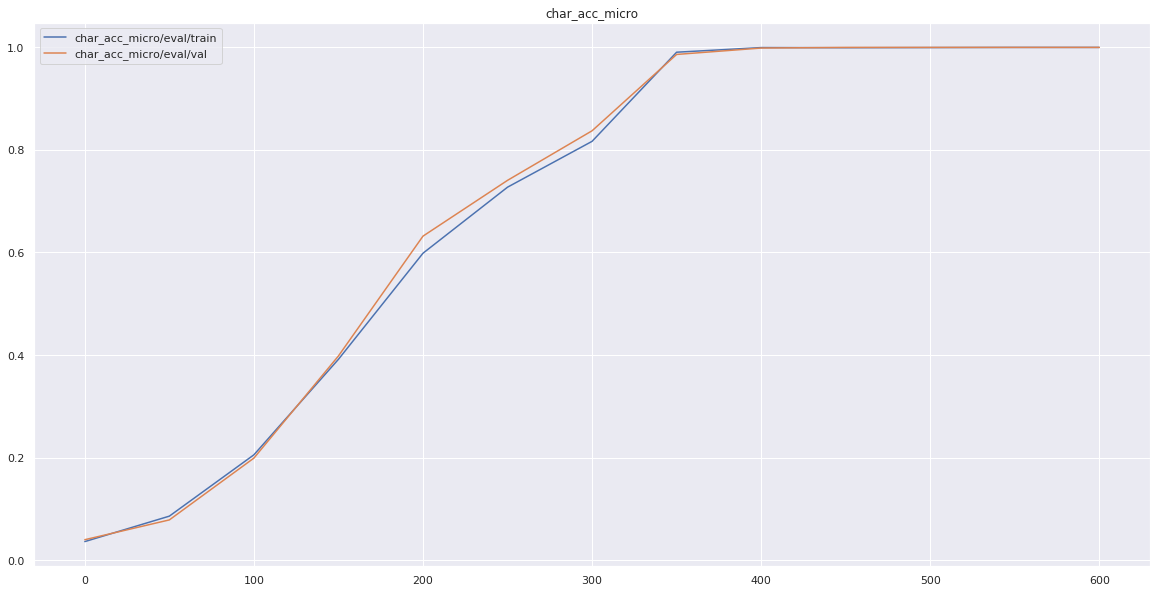

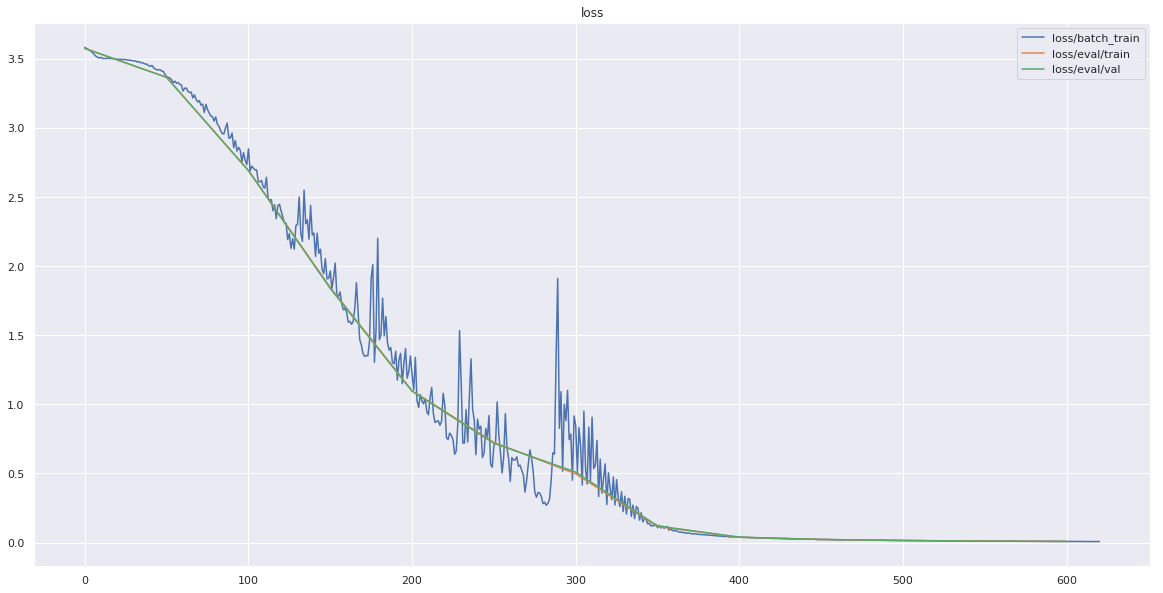

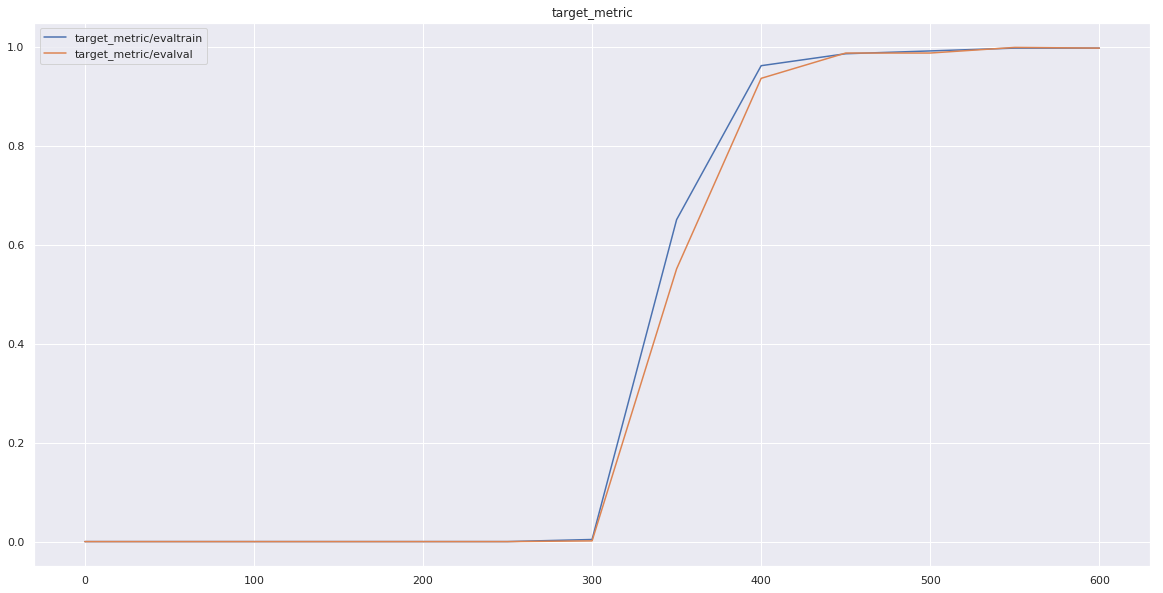

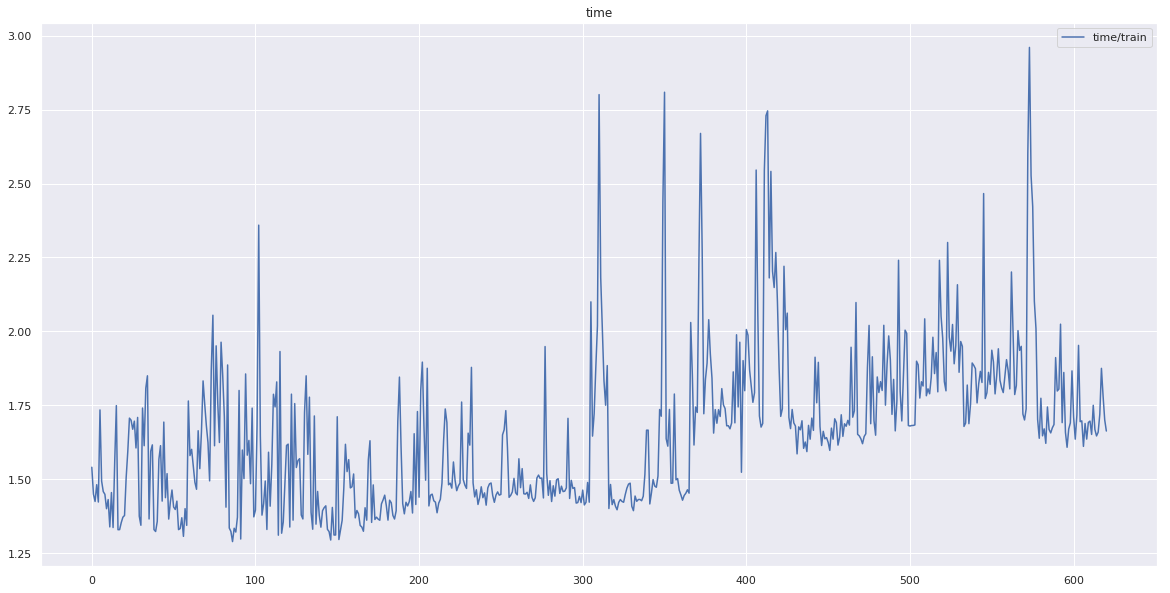

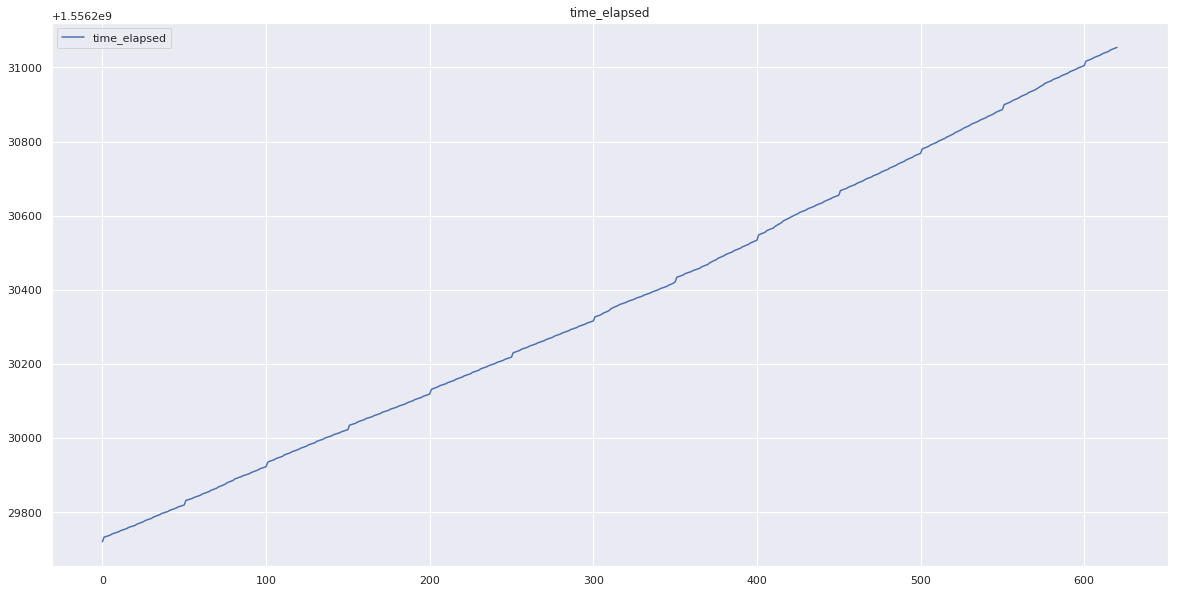

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=50,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

seq2seq_model = AttentionModel(
    64, 128, 3, len(train.encoder),
    train.sos_id, train.eos_id,
    attention_before_decoder=False,
    attention_after_decoder=True,
    bidirectional=True, 
    cell_type='lstm'
)

params = {
    "epochs":5,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(20, 10),
        "show_every":5
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}


loss_object = Seq2SeqUser(train)
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, 
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

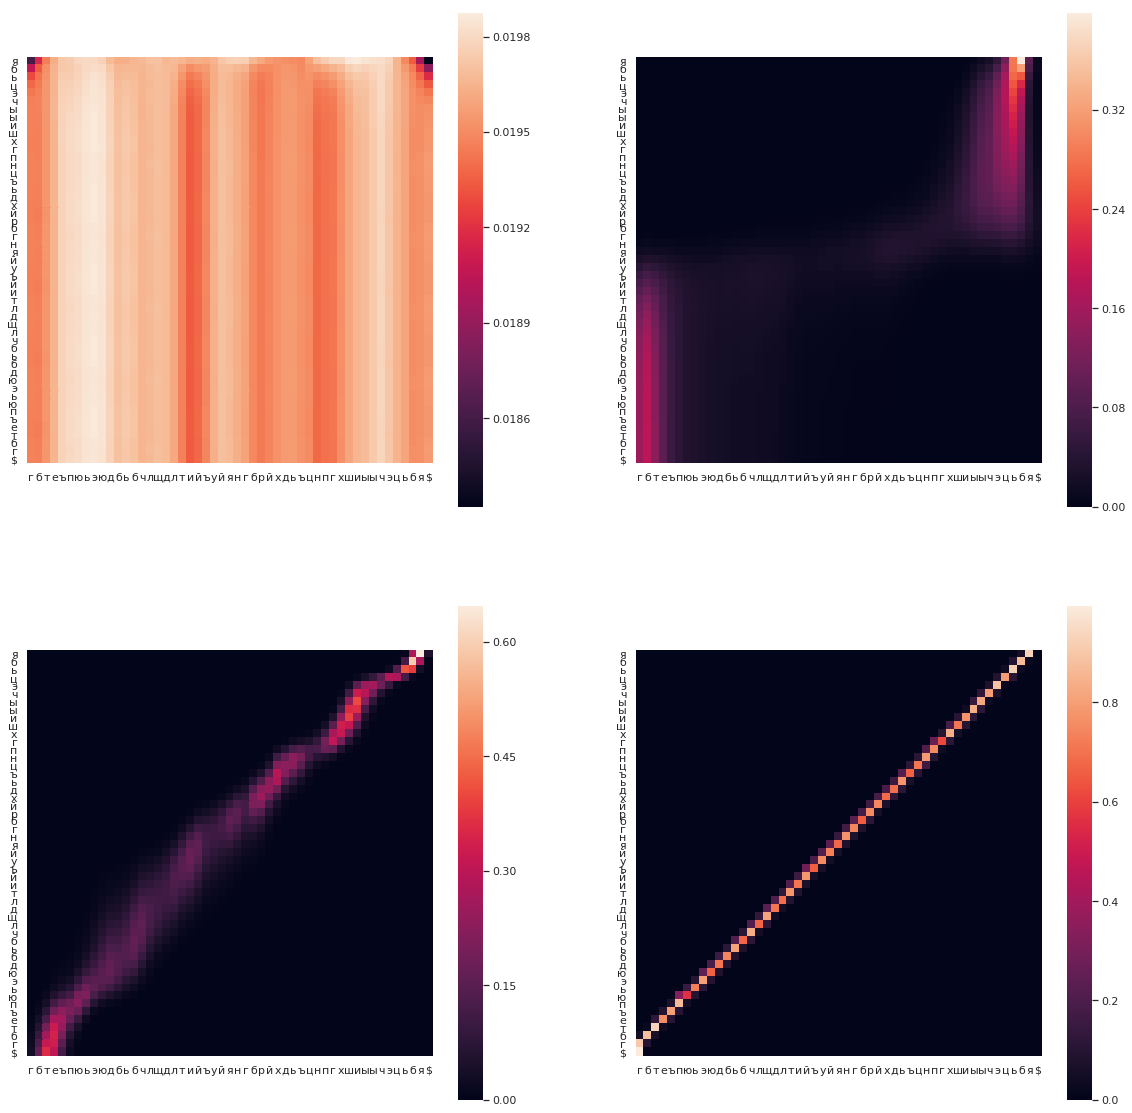

In [0]:
fix, axs = plt.subplots(2, 2, figsize=(20, 20))
visualize_func(0, axs[0, 0], loss_object)
visualize_func(1, axs[0, 1], loss_object)
visualize_func(2, axs[1, 0], loss_object)
visualize_func(-1, axs[1, 1], loss_object) 
plt.show()

## Feedback

Tell us: what did you learn, what did you like, what puzzled you?

It was hard to deal with sizes of tensors.

It also took a lot of time to run all the experiments.

It was rather hard to understand the architecture of seq_to_seq model and how attention works.

## Bonus: spelling correction data (3 points)

If you feel strength you can train a model on the competition data.
It is possible to train a model that achieves at least 0.5 of exact match accuracy on CPU with 8 GB of memory in 12 hours with moderate batches of at least 64, while watching videos and having >400 open tabs in browser (Firefox, actually).

If you beat this threshold (0.5 of exact match accuracy), you will be awarded the points for this part.
If your score is super high (to be determined after the deadline), you will be awarded by some points.

Also you can use the complete dataset (with retained correct entries) to improve models perfomance.

Maybe you need to play with teacher forcing params.

In [0]:
def load_surnames_dataset(csv_path, drop_correct, unique_x = True, train_val_test=[0.8,0.1,0.1]):
    """
    Loads the competition dataset.
    drop_correct: boolean flag whether to include the entries
    where X[i] == Y[i] (no misspelling)
    unique_x: every x in the dataset must be unique
    
    returns: 4 Seq2Seq datasets: train, val, test
    and correct: the dataset of surnames with no mistakes
    """
    
    data = pd.read_csv(csv_path)
    
    token_list = get_tokens(data)
    
    X = data['fullname']
    Y = data['fullname_true']
    
    mask = Y.isna()

    Y.loc[mask] = X[mask]
    
    
    new_X = []
    new_Y = []
    correct = []
    
    seen_x = set()
    for x, y in zip(X.values, Y.values):   
        if x in seen_x:
            continue
            
        if unique_x:
            seen_x.add(x)
        
        if x == y:
            correct.append(x)
            
        if drop_correct:
            if x != y:
                new_X.append(x)
                new_Y.append(y)
        else:
            new_X.append(x)
            new_Y.append(y)
    
    
    X = np.array(new_X)
    Y = np.array(new_Y)
    correct = np.array(correct)
    
    train, val, test = prepare_dataset(X, Y, token_list, train_val_test)
    correct = prepare_dataset(correct, correct, token_list, train_val_test=[0, 0, 1.0])[2]
    
    
    return train, val, test, correct
    
    

In [0]:
# When your are done playing with the toy data, try solving this problem
train, val, test, correct = load_surnames_dataset("./train.csv", drop_correct=True)

/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)
correct_batcher = DataLoader(correct, collate_fn=collate_sequences, batch_size=64, shuffle=False)

In [0]:
#### TODO

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

evaluate_result_correct = evaluate_test(
    seq2seq_model, correct_batcher, loss_object, max_batches=100, tag="correct", params=params
)